## Packages: install and import

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%%capture
!pip install transformers
!pip install scipy seaborn sklearn

In [4]:
from collections import defaultdict
from copy import copy, deepcopy
import gc
import json
from pathlib import Path
from tqdm import tqdm
from typing import Any, Callable, Dict, Iterable, List, Tuple


import numpy as np
from numpy.typing import NDArray
import torch
from torch.nn.functional import softmax as torch_softmax
from transformers import BertTokenizer, BertForSequenceClassification

import pandas as pd
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr
from typing import Callable, List
import sklearn
from tqdm.notebook import tqdm
from time import time

In [5]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
np.set_printoptions(suppress=True)

## Prepare

### Load models

In [6]:
model_path = Path("/content/drive/MyDrive/models_new/bert_imdb/full_trainer_20230912_custom_training_params_3/_final")

In [7]:
model = BertForSequenceClassification.from_pretrained("bert-base-cased", num_labels=2)
tokenizer = BertTokenizer.from_pretrained("bert-base-cased")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
model.load_state_dict(torch.load(model_path / "pytorch_model.bin"))

In [9]:
model.to("cuda")

### Classes

In [10]:
class BERTModelWrapper:
  def __init__(
      self, model: BertForSequenceClassification, tokenizer: BertTokenizer
    ) -> None:
    self.model = model
    self.tokenizer = tokenizer

  def __postinit__(self) -> None:
    self.model.eval()
    self.model.zero_grad()

  def tokenize(self, text: str) -> Dict[str, torch.Tensor]:
    return self.tokenizer(text, return_tensors='pt', truncation=True)

  def tokenize_to_list(self, text: str) -> Dict[str, List]:
    return self.tokenizer(text, truncation=True)

  def get_input_embeds(self, text: str) -> torch.Tensor:
    item = self.tokenize(text)
    item = {k: v.to(self.model.device) for k, v in item.items()}
    input_embeds = self._get_input_embeds_from_ids(item["input_ids"][0])
    return input_embeds.unsqueeze(0)

  def _get_input_embeds_from_ids(self, ids: torch.Tensor) -> torch.Tensor:
    return self.model.get_input_embeddings()(ids)

  def _get_input_embeds_from_ids_numpy(self, ids: NDArray) -> torch.Tensor:
    if type(ids) == np.ndarray:
      ids = torch.as_tensor(ids, device=self.model.device)
    embeds = self.model.get_input_embeddings()(ids)
    if len(embeds.shape) == 2:
      embeds = embeds.reshape(1, embeds.shape[0], embeds.shape[1])
    return embeds

  def get_outputs(
      self,
      input_embeds: torch.Tensor,
      attention_mask:
      torch.Tensor=None
    ) -> torch.Tensor:
    outputs = self.model(
        inputs_embeds=input_embeds, attention_mask=attention_mask
    )
    return outputs.logits

  def get_output_probabilities(
      self, input_embeds: torch.Tensor, attention_mask: torch.Tensor=None
    ) -> torch.Tensor:
    output_logits = self.get_outputs(input_embeds, attention_mask=None)
    return torch_softmax(output_logits, dim=1)

  def get_outputs_from_text(self, text: str) -> torch.Tensor:
    item = self.tokenize(text)
    item = {k: v.to(self.model.device) for k, v in item.items()}
    input_embeds = self._get_input_embeds_from_ids(item["input_ids"][0])
    input_embeds = input_embeds.unsqueeze(0)
    return self.get_outputs(
        input_embeds=input_embeds, attention_mask=item["attention_mask"]
    )

  def get_input_embeds_and_attention_mask(
      self, text: str
    ) -> Tuple[torch.Tensor, torch.Tensor]:
    item = self.tokenize(text)
    item = {k: v.to(self.model.device) for k, v in item.items()}
    input_embeds = self._get_input_embeds_from_ids(item["input_ids"][0])
    return input_embeds.unsqueeze(0), item["attention_mask"]

In [11]:
def squeeze_attributions(attributions: torch.Tensor) -> NDArray:
    attributions = attributions.sum(dim=2).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    attributions = attributions.detach().numpy()
    return attributions

In [12]:
class Explanation:
  def __init__(
      self,
      text_id: int,
      text: str,
      input_tokens: Dict[str, NDArray],
      label: int,
      model_outputs: NDArray,
      attr: NDArray,
      delta: float,
      attr_kwargs: Dict[str, Any],
      explainer_name: str,
      perturbation_info: Dict[str, Any]) -> None:
    self.text_id = text_id
    self.text = text
    self.input_tokens = input_tokens
    self.label = label
    self.model_outputs = model_outputs
    self.attr = attr
    self.delta = delta
    self.attr_kwargs = attr_kwargs
    self.explainer_name = explainer_name
    self.perturbation_info = perturbation_info

  @property
  def normalized_attr(self) -> NDArray:
    return self.attr / np.linalg.norm(self.attr, ord=1)

  @property
  def attr_no_special(self) -> NDArray:
    return self.attr[1:-1]

  @property
  def normalized_attr_no_special(self) -> NDArray:
    return self.attr_no_special / np.linalg.norm(self.attr_no_special, ord=1)

  @property
  def pred_label(self) -> int:
    return np.argmax(self.model_outputs)

  @property
  def model_outputs_prob(self) -> NDArray:
    return(np.exp(self.model_outputs)/np.exp(self.model_outputs).sum())

  def special_tokens_indices(self):
    ...

  def to_json(self) -> Dict[str, Any]:
    return {
        "text_id": self.text_id,
        "text": self.text,
        "label": self.label,
        "input_tokens": {k: v.astype(str).tolist() for k, v in self.input_tokens.items()},
        "model_outputs": [str(i) for i in self.model_outputs],
        "attr": [str(i) for i in self.attr],
        "attr_kwargs": self.attr_kwargs,
        "explainer_name": self.explainer_name,
        "perturbation_info": self.perturbation_info
    }

  @classmethod
  def from_dict(cls, exp: Dict[str, Any]):
    exp["text_id"] = int(exp["text_id"])
    exp["attr"] = np.array(exp["attr"]).astype('float32')
    exp["model_outputs"] = np.array(exp["model_outputs"]).astype('float32')
    exp["input_tokens"] = {k: np.array(v).astype(int) for k, v in exp["input_tokens"].items()}
    exp["delta"] = exp.get("delta")
    return Explanation(**exp)

In [13]:
class CustomExplanation:
  text_id: int
  attr: NDArray
  explainer_name: str
  model_outputs: NDArray
  perturbation_info: Dict

  def __init__(self, text_id, attr, explainer_name=None, model_outputs=None, perturbation_info=None):
    self.text_id = text_id
    self.attr=attr
    self.explainer_name=explainer_name
    self.model_outputs=model_outputs
    self.perturbation_info=perturbation_info

  @property
  def label(self) -> int:
    np.random.seed(self.text_id * len(self.attr))
    np.random.choice([0, 1])

  @property
  def normalized_attr(self) -> NDArray:
    return self.attr / np.linalg.norm(self.attr, ord=1)

  @property
  def model_outputs_prob(self) -> NDArray:
    return self.model_outputs

  @property
  def pred_label(self) -> int:
    return np.argmax(self.model_outputs)

  def assign_new_attr(self, new_attr):
    self.attr = new_attr

  @classmethod
  def from_dict(cls, d):
    return CustomExplanation(**d)

  @classmethod
  def from_dicts(cls, dd):
    return [CustomExplanation(**d) for d in dd]

  @classmethod
  def from_dicts_to_dicts(cls, dd):
    return {d["text_id"]: CustomExplanation(**d) for d in dd}

### Declarations

In [14]:
version_date = "20230916"

In [15]:
explanation_path = Path(f"/content/drive/MyDrive/explanations/bert_imdb/model_20230912/{version_date}/")

In [16]:
bert_wrapper = BERTModelWrapper(model, tokenizer)
def forward_func(input_embeds):
  return bert_wrapper.get_outputs(input_embeds)

In [17]:
with open(explanation_path / "selected_input_ids.json", "r") as file:
  selected_input_ids = np.array(json.load(file)).astype(int)

In [18]:
with open(explanation_path / "selected_inputs.json", "r") as file:
  selected_inputs = json.load(file)

In [19]:
selected_inputs = [{"text": text.replace("<br />", ""), "label": label} for text, label in zip(selected_inputs["text"], selected_inputs["label"])]

### Utils

In [20]:
def get_id_to_exp_mapping(explanations: List[Explanation]):
  return {exp.text_id: exp for exp in explanations}

In [21]:
def reverse_order_nested_dict(d: Dict[str, Dict[str, Any]]):
  final = defaultdict(dict)
  for k, mapping in d.items():
    for kk, item in mapping.items():
      final[kk][k] = item
  return final

In [22]:
def get_perturbed_by_lvl(perturbed_explanations: List[Explanation]):
  perturb_exp_by_lvl = defaultdict(list)
  for exp in perturbed_explanations:
    perturb_exp_by_lvl[int(exp.perturbation_info["lvl"])].append(exp)
  return perturb_exp_by_lvl

In [23]:
def get_perturbed_by_text_id(perturbed_explanations: List[Explanation], sort_by_lvl=False, reverse=False):
  perturb_exp_by_text_id = defaultdict(list)
  for exp in perturbed_explanations:
    perturb_exp_by_text_id[exp.text_id].append(exp)
  if sort_by_lvl:
    new_perturb_exp_by_text_id = {}
    for text_id, exp_list in perturb_exp_by_text_id.items():
      new_list = sorted(exp_list, key=lambda exp: int(exp.perturbation_info["lvl"]), reverse=reverse)
      new_perturb_exp_by_text_id[text_id] = new_list
    return new_perturb_exp_by_text_id
  return perturb_exp_by_text_id

In [24]:
def get_most_influential_token(exp: Explanation, label: int):
  token_index_max_attr = np.argmax(exp.attr[1:-1]) + 1 if label > 0 else np.argmin(exp.attr[1:-1]) + 1
  token_id = exp.input_tokens["input_ids"][token_index_max_attr]
  return token_index_max_attr , token_id

In [25]:
from copy import deepcopy
def replace_tokens_with_baseline(input_tokens, token_indices, baseline_value=-1):
  new_input_tokens = {}
  for k, v in input_tokens.items():
    vv = deepcopy(v)
    vv[token_indices] = np.full(len(token_indices), baseline_value)
    new_input_tokens[k] = vv
  return new_input_tokens

def replace_embeds_with_baseline(input_embeds, token_indices: List[int]):
  input_embeds[0, token_indices] = torch.zeros_like(input_embeds[0, token_indices])
  return input_embeds

In [26]:
def get_input_embeds_baseline_replaced_tokens(input_tokens: Dict[str, np.ndarray], input_embeds: np.ndarray, baseline_value=-1):
  baseline_indices = np.where(input_tokens["input_ids"] == -1)
  # check dimensions, axis, etc.
  input_embeds[baseline_indices] = np.zeros_like(input_embeds[baseline_indices])
  return input_embeds

In [27]:
def get_random_token_indices(input_len: int, n_samples: int, n_tokens: int, random_seed: int = 123, chunk_size: int=1) -> NDArray:
  np.random.seed(random_seed)
  upper_bound = input_len - 1 - chunk_size
  return np.array([np.random.choice(range(1, upper_bound), size=min(n_tokens, upper_bound-1), replace=False) for i in range(n_samples)])

## Metrics

#### Metrics utils

In [28]:
def get_auc(values: np.ndarray, dx: int = 1):
  """
  Return Area Under the Curve
  but how exactly should that work
  """

  return np.trapz(np.array(values), dx=dx)

In [29]:
def similarity_lp_norm(x, y, p=2):
  z = x - y
  z = z[~np.isnan(z)]
  return np.linalg.norm(z, axis=0, ord=p)

In [30]:
def get_attribution_complexity(abs_normalized_attr: np.ndarray):
  return scipy.stats.entropy(pk=abs_normalized_attr)

In [31]:
def softmax(x):
    return(np.exp(x)/np.exp(x).sum())

### Simplicity

In [32]:
def complexity(explanation: Explanation) -> float:
  return get_attribution_complexity(np.absolute(explanation.normalized_attr))

In [33]:
def sparseness(explanation: Explanation):
  attr = np.sort(np.absolute(explanation.attr), kind="mergesort")
  d = len(attr)
  def func(v_k, k, d):
    return v_k * (2*k - d - 1)
  attr_processed = np.array([func(v_k, k+1, d) for k, v_k in enumerate(attr)])
  gini_index = np.sum(attr_processed) / (d * np.sum(attr))
  return gini_index

### Faithfulness

In [34]:
def selectivity_og(perturbed_explanations_recurrent_baseline_replacement: List[Explanation], inverse=False, use_label="real", relative=False):
  """
  Checks differences in predictions after replacing most influential tokens.
  Not sure if it's the same as in quantus.
  Not sure how this should work, check https://arxiv.org/pdf/1706.07979.pdf
  """
  label = perturbed_explanations_recurrent_baseline_replacement[0].label if use_label=="real" else perturbed_explanations_recurrent_baseline_replacement[0].pred_label
  outputs = np.array([exp.model_outputs_prob[label] for exp in perturbed_explanations_recurrent_baseline_replacement])
  try:
    res = get_auc(np.array(sorted(outputs)), 1/len(sorted(outputs)))
  except:
    print(outputs)
  return 1-res if inverse else res

In [35]:
def selectivity(perturbed_explanations_recurrent_baseline_replacement: List[Explanation], output_metric: Callable, use_label=False):
  """
  Checks differences in predictions after replacing most influential tokens.
  Not sure if it's the same as in quantus.
  Not sure how this should work, check https://arxiv.org/pdf/1706.07979.pdf
  """
  label = perturbed_explanations_recurrent_baseline_replacement[0].label if use_label else 1
  outputs = [softmax(exp.model_outputs)[label] for exp in perturbed_explanations_recurrent_baseline_replacement]
  return output_metric(outputs) # they have different length

In [36]:
def faithfulness_correlation(explanations_mapping: Dict[str, Dict[str, Explanation]], explainer_names: List[str],
                             random_subset_size: int = 3, n_samples: int = 50, abs=False, chunk_size=1) -> float:
  """
  Correlation between
  * the sum of attributions of a random subset
  * the difference in model output with the subset replaced with baseline
  """
  correlations = defaultdict(list)
  attr_sums = {}
  pred_diffs = defaultdict(list)
  for text_id, exp_dict in tqdm(explanations_mapping.items()):
    exp = list(exp_dict.values())[0]
    input_len = len(exp.attr)
    np.random.seed(exp.text_id)
    random_subsets = get_random_token_indices(
      input_len=input_len,  n_samples=n_samples, n_tokens=random_subset_size, random_seed=exp.text_id, chunk_size=chunk_size
    )
    _attr_sums = defaultdict(list)
    for token_indices in random_subsets:
      token_indices = np.concatenate([(token_indices + (np.ones_like(token_indices) * i)) for i in range(chunk_size)])
      subset_input_tokens = replace_tokens_with_baseline(exp.input_tokens, token_indices)
      subset_model_outputs = predict(**subset_input_tokens).detach().cpu().detach().numpy()
      _pred_diff = (exp.model_outputs - subset_model_outputs)[0, exp.label]
      _pred_diff = np.abs(_pred_diff) if abs else _pred_diff
      pred_diffs[text_id].append(float(_pred_diff))
      for explainer_name, _exp in exp_dict.items():
        if explainer_name not in explainer_names:
          continue
        attribution_sum = np.sum(np.abs(_exp.normalized_attr[token_indices])) if abs else np.sum(_exp.normalized_attr[token_indices])
        _attr_sums[explainer_name].append(float(attribution_sum))
    attr_sums[text_id] = _attr_sums
  correlations = {
      text_id:
       {
          explainer_name: float(pearsonr(attr_sum, pred_diffs[text_id]).statistic)
          for explainer_name, attr_sum in attr_sums_per_explainer.items()
       }
      for text_id, attr_sums_per_explainer in attr_sums.items()
  }
  return attr_sums, pred_diffs, correlations

In [37]:
def faithfulness_correlation_precalculated_preds(explanations_mapping: Dict[str, Dict[str, Explanation]], explainer_names: List[str],
                                                 random_subset_size: int = 3, n_samples: int = 50, abs=False, chunk_size=1, pred_diffs=None) -> float:
  """
  Correlation between
  * the sum of attributions of a random subset
  * the difference in model output with the subset replaced with baseline
  """
  correlations = defaultdict(list)
  attr_sums = {}
  for text_id, exp_dict in tqdm(explanations_mapping.items()):
    exp = list(exp_dict.values())[0]
    input_len = len(exp.attr)
    np.random.seed(exp.text_id)
    random_subsets = get_random_token_indices(
      input_len=input_len,  n_samples=n_samples, n_tokens=random_subset_size, random_seed=exp.text_id, chunk_size=chunk_size
    )
    _attr_sums = defaultdict(list)
    for token_indices in random_subsets:
      token_indices = np.concatenate([(token_indices + (np.ones_like(token_indices) * i)) for i in range(chunk_size)])
      for explainer_name, _exp in exp_dict.items():
        if explainer_name not in explainer_names:
          continue
        attribution_sum = np.sum(np.abs(_exp.normalized_attr[token_indices])) if abs else np.sum(_exp.normalized_attr[token_indices])
        _attr_sums[explainer_name].append(float(attribution_sum))
    pred_diffs[text_id] = np.abs(pred_diffs[text_id]) if abs else pred_diffs[text_id]

    attr_sums[text_id] = _attr_sums

  correlations = {
      text_id:
       {
          explainer_name: float(pearsonr(attr_sum, pred_diffs[text_id]).statistic)
          for explainer_name, attr_sum in attr_sums_per_explainer.items()
       }
      for text_id, attr_sums_per_explainer in attr_sums.items()
  }
  return attr_sums, pred_diffs, correlations

### Stability

In [38]:
def distance_lp_norm(x, y, p=2):
  z = x - y
  z = z[~np.isnan(z)]
  return np.linalg.norm(z, axis=0, ord=p)

In [39]:
def _input_stability(
    exp1: Explanation,
    exp2: Explanation,
    input_distance_measure: Callable,
    exp_distance_measure: Callable, eps: float=0.05
  ):
  input_distance = max(input_distance_measure(exp1, exp2), eps)
  exp_distance = exp_distance_measure(exp1, exp2)
  stability = exp_distance / input_distance
  return stability

In [40]:
def _output_stability(
    exp1: Explanation,
    exp2: Explanation,
    output_distance_measure: Callable,
    exp_distance_measure: Callable, eps: float=0.05):

  output_distance =  max(output_distance_measure(exp1, exp2), eps)
  exp_distance = exp_distance_measure(exp1, exp2)
  stability = exp_distance / output_distance
  return stability

In [41]:
def output_stability(
    perturbed_explanations: List[Explanation],
    original_explanation: Explanation,
    output_distance_measure: Callable,
    exp_distance_measure: Callable,
    eps: float=0.05
    ):
  stability = []
  for exp in perturbed_explanations:
    _stability = _output_stability(original_explanation, exp, output_distance_measure, exp_distance_measure, eps)
    stability.append(_stability)
  return np.array(stability).astype(float)

In [42]:
def input_stability(
    perturbed_explanations: List[Explanation],
    original_explanation: Explanation,
    input_distance_measure: Callable,
    exp_distance_measure: Callable,
    eps: float=0.05):
  stability = []
  for exp in perturbed_explanations:
    _stability = _input_stability(original_explanation, exp, input_distance_measure, exp_distance_measure, eps)
    stability.append(_stability)
  # it looks like in the paper now (only it is a list of stability metrics, but can be averaged or smth)
  return np.array(stability)

In [43]:
def cont_wrapper(perturbed_explanations_with_original: List[Explanation]):
  perturbed_explanations = perturbed_explanations_with_original[1:]
  original_explanation = perturbed_explanations_with_original[0]
  n_token_diff = int(perturbed_explanations[0].perturbation_info['n_tokens_to_replace'])
  return continuity(perturbed_explanations=perturbed_explanations, original_explanation=original_explanation, n_token_diff=n_token_diff)

In [44]:
def continuity(perturbed_explanations: List[Explanation], original_explanation: Explanation, n_token_diff: int):
  cont = input_stability(
      perturbed_explanations,
      original_explanation,
      input_distance_measure=lambda x, y: 100 * n_token_diff / len(x.attr),
      exp_distance_measure=lambda x, y: distance_lp_norm(x.normalized_attr, y.normalized_attr, p=2)
  )
  output_cont = output_stability(
      perturbed_explanations,
      original_explanation,
      output_distance_measure=lambda x, y: 1,
      exp_distance_measure=lambda x, y: np.abs((x.model_outputs_prob[original_explanation.label]-y.model_outputs_prob[original_explanation.label])),
  )
  i = np.argmax(cont)
  return cont[i], output_cont[i]

# Analysis

In [45]:
analysis_path = Path(f"/content/drive/MyDrive/analysis/bert_imdb/model_20230912/{version_date}_final3/")
analysis_path.mkdir(parents=True, exist_ok=True)

In [46]:
inter_path = analysis_path / "inter"
inter_path.mkdir(parents=True, exist_ok=True)

In [47]:
figures_path = analysis_path / "figures"
figures_path.mkdir(parents=True, exist_ok=True)

#### Analysis utils

In [48]:
def load_all_explainers(explanation_path: Path, prefix: str, suffix: str, explainers_info: Dict[str, str], perturbed=False, possible_missing: bool=False):
  return {
    explainer_name: load_explanations(
      explanation_path, f'{prefix}{explainer_info}_{suffix}_{version_date}.json', perturbed=perturbed, possible_missing=possible_missing
    ) for explainer_name, explainer_info in explainers_info.items()
  }

In [49]:
def load_explanations(explanation_path, filename, perturbed=False, possible_missing=False):
  try:
    with open(explanation_path / filename, "r") as f:
      exp_dicts = json.load(f)
  except FileNotFoundError as e:
    if not possible_missing:
      raise(e)
    return []
  if perturbed:
    exp_dicts = np.concatenate(exp_dicts)
  explanations = [Explanation.from_dict(exp_dict) for exp_dict in exp_dicts]
  return explanations

In [50]:
def get_stats(a: NDArray):
  return {"min": np.min(a),
         "avg": np.mean(a),
         "median": np.median(a),
         "max": np.max(a)}

def get_stats_df(d: Dict[str, NDArray]):
  return pd.DataFrame(d).describe().drop("count")

In [51]:
def get_explainer_info_from_attr_kwargs(explainer_name: str, attr_kwargs: Dict[str, Any]) -> str:
  if explainer_name == "LayerIntegratedGradients":
    return f"IGG_{attr_kwargs['n_steps']}"
  elif explainer_name == "LayerIntegratedGradientsGlobal":
    return f"IGL_{attr_kwargs['n_steps']}"
  return explainer_name

In [52]:
def split_random_baseline_separate_files(random_baseline_raw):
  random_explanations_by_explainer = {k: defaultdict(list) for k in ["explanations", "completements"]}
  for raw_exps in random_baseline_raw:
    for k in ["explanations", "completements"]:
      explanations = raw_exps[k]
      for explainer_name, exps in explanations.items():
        exps = [Explanation.from_dict(i) for i in exps]
        for exp in exps:
          exp_info = get_explainer_info_from_attr_kwargs(exp.explainer_name, exp.attr_kwargs)
          random_explanations_by_explainer[k][exp_info].append(exp)
  return random_explanations_by_explainer

In [53]:
def load_random_baseline_files(explanation_path, prefix, explainers_info, suffix, explainer_mapping, possible_missing=False):
  rb_by_explainer = {}
  rb_compl_by_explainer = {}
  for k in explainers_info:
    try:
      with open(explanation_path / f"{prefix}{k}_{suffix}_{version_date}.json", "r") as f:
        random_baseline_raw = json.load(f)
    except Exception as e:
      if possible_missing:
        pass
      else:
        raise e

    all_rb_raw = split_random_baseline_separate_files(random_baseline_raw)
    for j, d in all_rb_raw.items():
      for _explainer_name, exps in d.items():
        explainer_name = explainer_mapping.get(_explainer_name, _explainer_name)
        if j == "explanations":
          rb_by_explainer[explainer_name] = exps
        else:
          rb_compl_by_explainer[explainer_name] = exps
  return rb_by_explainer, rb_compl_by_explainer

In [54]:
def get_random_model_outputs(text_id, attr) -> NDArray:
  np.random.seed(abs(text_id) * len(np.argwhere(attr != 0)))
  x = np.random.uniform(0, 1)
  return np.array([1-x, x])

In [55]:
def generate_random_uniform_attribution(sample_explanations: List[Explanation], normalized=False):
  np.random.seed(123)
  res = []
  for exp in sample_explanations:
    attr = np.random.uniform(-1, 1, size=len(exp.attr))
    if normalized:
      attr = attr / np.linalg.norm(attr, ord=1)
    res.append({
          "text_id": exp.text_id,
          "attr": attr,
          "model_outputs": get_random_model_outputs(exp.text_id, attr)
      })
  return res

In [56]:
def predict(input_ids, token_type_ids=None, attention_mask=None):
  model.eval()
  model.zero_grad()
  output = model(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)
  return output.logits

In [57]:
def replace_tokens_with_baseline(input_tokens: Dict[str, NDArray[Any]], token_indices: Iterable[int], baseline_value: int=0) -> Dict[str, NDArray[Any]]:
  new_input_tokens = {}
  for k, v in input_tokens.items():
    vv = deepcopy(v)
    if k == "input_ids":
      vv[token_indices] = np.full(len(token_indices), baseline_value)
    new_input_tokens[k] = torch.Tensor(vv).unsqueeze(dim=0).to(model.device).long()
  return new_input_tokens

In [59]:
def get_model_outputs_for_baseline(input_tokens: Dict[str, NDArray[Any]], replace_special_tokens=False):
  try:
    token_indices = list(range(len(input_tokens["input_ids"]))) if replace_special_tokens else list(range(1, len(input_tokens["input_ids"])-1))
  except:
    print(input_tokens)
  input_tokens_baseline = replace_tokens_with_baseline(input_tokens, token_indices, baseline_value=0)
  return predict(**input_tokens_baseline)

### Load explanations

##### Info

In [60]:
ig_nsteps = [5, 10, 15]

In [61]:
explainers_info = {
    "GradientLocal": "gradient",
    "GradientGlobal": "GradientXActivation".lower(),
    "DeepLiftLocal": "deeplift",
    "DeepLiftGlobal": "DeepLiftXActivation".lower(),
}
explainers_info.update({
  f"IGG_{n_steps}": f"integratedgradientsxactivation_n_steps_{n_steps}" for n_steps in ig_nsteps
})
explainers_info.update({
  f"IGL_{n_steps}": f"integratedgradients_n_steps_{n_steps}" for n_steps in ig_nsteps
})

In [62]:
explainers_simple = ["DeepLiftLocal", "DeepLiftGlobal", "GradientLocal", "GradientGlobal"]
explainers_ig = ['IGL_5', 'IGG_5', 'IGL_10', 'IGG_10', 'IGL_15', 'IGG_15']
explainers_custom = ["RandomUniform", "Constant"]
explainers_regular = explainers_simple + explainers_ig
explainers_local = ["DeepLiftLocal", "GradientLocal", 'IGL_5', 'IGL_10', 'IGL_15']
explainers_global = ["DeepLiftGlobal", "GradientGlobal", 'IGG_5', 'IGG_10', 'IGG_15']

In [63]:
explainer_mapping = {
    "LayerDeepLiftXActivation": "DeepLiftGlobal",
    "LayerDeepLift": "DeepLiftLocal",
    "LayerGradientXActivation": "GradientGlobal",
    "LayerGradient": "GradientLocal",
    "LayerIntegratedGradientsActivation": "IntegratedGradientsGlobal",
    "LayerIntegratedGradients": "IntegratedGradientsLocal",

}

In [64]:
explainer_mapping_reversed = {
    "Layer"+explainer_name: explainer_name for explainer_name in explainers_simple + ["IntegratedGradients"]
}

In [65]:
local_global_order = np.concatenate([[i, j] for i, j in zip(explainers_local, explainers_global)]).tolist()
global_local_order = np.concatenate([[i, j] for i, j in zip(explainers_global, explainers_local)]).tolist()

In [150]:
custom_mapping_short = {"RandomUniform": "RandUnif", "Constant": "Const"}

##### Examples

In [66]:
suffix = "default_examples_extra"
folder = "examples_extra"
all_examples = load_all_explainers(explanation_path=explanation_path / folder, prefix="", suffix=suffix, explainers_info=explainers_info)
all_examples_mapping = reverse_order_nested_dict({explainer_name: get_id_to_exp_mapping(exp_list) for explainer_name, exp_list in all_examples.items()})

##### Default

In [67]:
suffix = "default"
folder = "regular"
all_default = load_all_explainers(explanation_path=explanation_path / folder, prefix="", suffix=suffix, explainers_info=explainers_info, possible_missing=True)
all_default_mapping = reverse_order_nested_dict({explainer_name: get_id_to_exp_mapping(exp_list) for explainer_name, exp_list in all_default.items()})

Custom

In [68]:
sample_attributions = all_default["DeepLiftLocal"]

In [69]:
random_uniform_attributions = generate_random_uniform_attribution(sample_attributions)
random_uniform_norm_attributions = generate_random_uniform_attribution(sample_attributions, normalized=True)

In [70]:
constant_attributions = [{"text_id": exp.text_id, "attr": np.array([1/len(exp.attr)]* len(exp.attr)), "model_outputs": np.array([0.5, 0.5])} for exp in sample_attributions]

In [72]:
# with torch.no_grad():
#   model_outputs_for_baselines = {exp.text_id: get_model_outputs_for_baseline(exp.input_tokens) for exp in sample_attributions}
#   model_outputs_for_baselines_special_replaced = {exp.text_id: get_model_outputs_for_baseline(exp.input_tokens, replace_special_tokens=True) for exp in sample_attributions}

In [73]:
exp_length = [len(exp.attr) for exp in sample_attributions]

In [74]:
custom_attr = {"RandomUniform": CustomExplanation.from_dicts(random_uniform_attributions), "Constant": CustomExplanation.from_dicts(constant_attributions)}
custom_attr_dicts = {"RandomUniform": CustomExplanation.from_dicts_to_dicts(random_uniform_attributions), "Constant": CustomExplanation.from_dicts_to_dicts(constant_attributions)}
custom_attr_mapping = reverse_order_nested_dict(custom_attr_dicts)

In [75]:
pred_label_equal_true = {text_id: i["IGG_5"].label == i["IGG_5"].pred_label for text_id, i in all_default_mapping.items()}
pred_label_equal_true_df = pd.Series(pred_label_equal_true).rename("pred==true").to_frame()

In [76]:
exp_len = {text_id: len(exps["IGG_5"].attr) for text_id, exps in all_default_mapping.items()}
exp_len_df = pd.Series(exp_len).rename("Token Length").to_frame()

##### Random baseline replacement

In [77]:
prefix = "random_token_baseline_replacement_"
folder = "random_baseline"
explainers_info_rb = ["simple", "ig", "ig_global"]

In [78]:
prefix = "random_token_baseline_replacement_"
folder = "random_baseline"
explainers_info_rb = ["simple", "ig", "ig_global"]

In [79]:
n_tokens_list = [1, 2]
rb_by_explainer_n = {}
for n_tokens in n_tokens_list:
  suffix = f"n_samples_5_n_tokens_{n_tokens}"
  rb_by_explainer_n[n_tokens], _ = load_random_baseline_files(explanation_path / folder, prefix, explainers_info_rb, suffix, explainer_mapping)

In [80]:
rb_by_explainer_n_by_text_id = {
    k: {
        explainer_name: get_perturbed_by_text_id(exps) for explainer_name, exps in v.items()
  } for k, v in rb_by_explainer_n.items()
}

In [81]:
def random_token_baseline_replacement_custom(custom_exp, sample_exps):
  explanations = []
  np.random.seed(custom_exp.text_id)
  for exp in sample_exps:
    tokens_replaced_with_baselines = np.argwhere(exp.input_tokens["input_ids"] == 0)[:, 0]
    new_attr = np.random.uniform(-1, 1, size=len(exp.attr))
    new_attr[tokens_replaced_with_baselines] = 0
    explanations.append(CustomExplanation.from_dict({
        "text_id": custom_exp.text_id,
        "attr": new_attr / np.sum(np.abs(new_attr)),
        "explainer_name": custom_exp.explainer_name,
        "perturbation_info": exp.perturbation_info,
        "model_outputs": get_random_model_outputs(custom_exp.text_id, custom_exp.attr)
    }))
  return explanations

In [82]:
# get recurrent random
def get_random_custom(custom_attr_mapping, sample_random_exps):
  all_random = defaultdict(dict)
  for text_id, exp_dict in custom_attr_mapping.items():
    for explainer_name, exp in exp_dict.items():
      sample_exps = sample_random_exps[text_id]
      all_random[explainer_name][text_id] = random_token_baseline_replacement_custom(exp, sample_exps)
  return all_random

In [83]:
all_sample_exps = {i: rb_by_explainer_n_by_text_id[i]["IGG_5"] for i in [1, 2]}
random_custom_n_by_text_id = {k: get_random_custom(custom_attr_mapping, sample_random_exps) for k, sample_random_exps in all_sample_exps.items()}

##### Recurrent baseline replacement

In [84]:
folder = "recurrent_baseline"
prefix = "recurrent_token_baseline_replacement_"
n_samples = 20
suffix = f"n_samples_{n_samples}_diff_pred"
all_recurrent = load_all_explainers(
  explanation_path=explanation_path / folder,
  prefix=prefix,
  suffix=suffix,
  explainers_info=explainers_info,
  perturbed=True,
  possible_missing=True
)

In [85]:
all_recurrent_sorted = {explainer_name: get_perturbed_by_text_id(exp_list, sort_by_lvl=True, reverse=False) for explainer_name, exp_list in all_recurrent.items()}
all_recurrent_sorted_with_originals = {
    explainer_name: {
        text_id: [all_default_mapping[text_id][explainer_name]] + _exps for text_id, _exps in _exps_sorted.items()
    } for explainer_name, _exps_sorted in all_recurrent_sorted.items()
}

In [86]:
def get_most_relevant_attribution(attr: NDArray, label: int):
  # taking [CLS] and [SEP] into account
  # return np.argmax(attr[1:-1]) + 1 if label > 0 else np.argmin(attr[1:-1]) + 1
  n = np.argmax(np.abs(attr[1:-1]))
  return n + 1

def recurrent_token_baseline_replacement_custom(
    explanation: Explanation,
    explainer_name: str,
    max_n_samples: int,
    while_same_pred_label=False
  ):
  curr_exp = deepcopy(explanation)
  input_token_len = len(explanation.attr)-2
  explanations, max_attr_indices = [], []
  for i in range(min(max_n_samples, input_token_len)):
    if while_same_pred_label and np.argmax(curr_exp.model_outputs) != explanation.pred_label:
      break
    curr_exp_max_attr_ind = get_most_relevant_attribution(attr=curr_exp.attr, label=explanation.label)
    max_attr_indices.append(curr_exp_max_attr_ind)
    attr_with_tokens_replaced = np.random.uniform(-1, 1, size=len(explanation.attr))
    attr_with_tokens_replaced[max_attr_indices] = 0
    factor = np.random.uniform([-0.05, 0.05])
    _explanation = CustomExplanation.from_dict({
        "text_id": explanation.text_id,
        "attr": attr_with_tokens_replaced / np.sum(np.abs(attr_with_tokens_replaced)),
        "explainer_name": explainer_name,
        "model_outputs": np.clip(curr_exp.model_outputs + np.array([factor, -factor]), 0, 1)
    })
    curr_exp = _explanation
    explanations.append(_explanation)
  return explanations

In [87]:
def get_recurrent_custom(custom_attr_mapping):
  all_recurrent = defaultdict(dict)
  for text_id, exp_dict in custom_attr_mapping.items():
    for explainer_name, exp in exp_dict.items():
      all_recurrent[explainer_name][text_id] = recurrent_token_baseline_replacement_custom(exp, explainer_name, max_n_samples=20)
  return all_recurrent

In [88]:
def get_comb_name(comb: List[str]) -> str:
  return "__".join(["".join([i for i in _name if i.isupper() or i.isnumeric() or i=="_"]) for _name in comb])

In [89]:
all_recurrent_custom = get_recurrent_custom(custom_attr_mapping)
all_recurrent_custom_with_originals = {
    explainer_name: {
        text_id: [custom_attr_mapping[text_id][explainer_name]] + _exps for text_id, _exps in _exps_sorted.items()
    } for explainer_name, _exps_sorted in all_recurrent_custom.items()
}

In [90]:
columns_mapping_short = {explainer_name: get_comb_name([explainer_name]) for explainer_name in explainers_regular}

#### Ensemble

##### Meta-explainers

###### Utils

In [91]:
def get_attr_similarity(exps_1: List[Explanation], exps_2: List[Explanation], similarity_func: Callable, aggr_func: Callable):
  res = []
  exps_1_mapping = {e.text_id: e for e in exps_1}
  try:
    for exp_2 in exps_2:
      res.append(similarity_func(exp_2.attr, exps_1_mapping[exp_2.text_id].attr))
  except:
    print(exp_2.text_id, exp_2.explainer_name)
    print(exp_2.attr.shape)
    print(exps_1_mapping[exp_2.text_id].attr.shape)
    print(exps_1_mapping[exp_2.text_id].text_id, exps_1_mapping[exp_2.text_id].explainer_name)
  return aggr_func(res)

In [92]:
def combine_nested_dictionaries(dict_list: List[Dict[Any, Dict]]):
  res = defaultdict(dict)
  outer_keys = np.concatenate([list(d.keys()) for d in dict_list])
  inner_keys = np.concatenate([list(dd.keys()) for d in dict_list for dd in d.values()])
  for outer_key in outer_keys:
    for inner_key in inner_keys:
      for d in dict_list:
        v = d.get(outer_key, {}).get(inner_key) or d.get(inner_key, {}).get(outer_key)
        if v is not None:
          res[outer_key][inner_key] = v
          res[inner_key][outer_key] = v
  return res

In [93]:
def check_if_all_explanations_for_the_same_input(explanations: List[Explanation], check_tokens=False):
  sample_explanation = explanations[0]
  assert all([v.text_id == sample_explanation.text_id for v in explanations])
  assert all([v.text == sample_explanation.text for v in explanations])
  if check_tokens:
    assert all([all(v.input_tokens["input_ids"] == sample_explanation.input_tokens["input_ids"]) for v in explanations])
    assert all([all(np.isclose(v.model_outputs, sample_explanation.model_outputs)) for v in explanations])

In [94]:
def combine_explanations(explanations: Dict[str, Explanation], combination: List[str], combination_name: str = None, aggr_func: Callable=np.mean, nt=False):
  sample_explanation = list(explanations.values())[0].to_json()
  check_if_all_explanations_for_the_same_input(list(explanations.values()), check_tokens=not nt)
  exps_for_combination = [e for k, e in explanations.items() if k in combination]
  exp_dict = {k: v for k, v in sample_explanation.items() if k in ["text", "text_id", "input_tokens", "model_outputs", "label"]}
  exp_dict["attr"] = aggr_func(np.array([e.normalized_attr for e in exps_for_combination]), axis=0)
  exp_dict["explainer_name"] = get_comb_name(combination) if not combination_name else combination_name
  exp_dict["perturbation_info"] = {"meta-explainer": True, "components": {e.explainer_name: e.perturbation_info for e in exps_for_combination}, "nt": nt}
  exp_dict["attr_kwargs"] = {e.explainer_name: e.attr_kwargs for e in exps_for_combination}
  new_exp = Explanation.from_dict(exp_dict)
  return new_exp

In [95]:
def abs_max(arr, axis=0):
  max_abs_values = np.max(np.abs(arr), axis=axis)
  max_values = arr[np.argmax(np.abs(arr), axis=0), np.arange(arr.shape[1])]
  return max_values


def abs_min(arr, axis=0):
  min_abs_values = np.min(np.abs(arr), axis=axis)
  min_values = arr[np.argmin(np.abs(arr), axis=0), np.arange(arr.shape[1])]
  return min_values

##### Create

In [96]:
combs = [
    ["GradientLocal", "GradientGlobal"],
    ["DeepLiftLocal", "DeepLiftGlobal"],
     ["IGL_5", "IGG_5"],
      ["IGL_10", "IGG_10"],
       ["IGL_15", "IGG_15"],
    ]
metric_names = ["mean", "absmax", "absmin"]
metrics = [np.mean, abs_max, abs_min]

combinations = {}
for name, metric in zip(metric_names, metrics):
  combinations[name] = {
      get_comb_name(comb): [
        combine_explanations(v, combination=comb, aggr_func=metric)
          for k, v in all_default_mapping.items()
          ] for comb in combs
}

In [97]:
def combine_explanations(explanations: Dict[str, Explanation], combination: List[str], combination_name: str = None, aggr_func: Callable=np.mean, nt=False):
  sample_explanation = list(explanations.values())[0].to_json()
  check_if_all_explanations_for_the_same_input(list(explanations.values()), check_tokens=not nt)
  exps_for_combination = [e for k, e in explanations.items() if k in combination]
  exp_dict = {k: v for k, v in sample_explanation.items() if k in ["text", "text_id", "input_tokens", "model_outputs", "label"]}
  exp_dict["attr"] = aggr_func(np.array([e.normalized_attr for e in exps_for_combination]), axis=0)
  exp_dict["explainer_name"] = get_comb_name(combination) if not combination_name else combination_name
  exp_dict["perturbation_info"] = {"meta-explainer": True, "components": {e.explainer_name: e.perturbation_info for e in exps_for_combination}, "nt": nt}
  exp_dict["attr_kwargs"] = {e.explainer_name: e.attr_kwargs for e in exps_for_combination}
  new_exp = Explanation.from_dict(exp_dict)
  return new_exp

In [98]:
def combine_explanations_perturbed(explanations: Dict[str, List[Explanation]], combination: List[str], combination_name: str = None, aggr_func: Callable=np.mean, nt=False):
  exps_for_combination_lists = [e for k, e in explanations.items() if k in combination]
  new_exps = []
  for exps_for_combination in zip(*exps_for_combination_lists):
    sample_explanation = exps_for_combination[0].to_json()
    exp_dict = {k: v for k, v in sample_explanation.items() if k in ["text", "text_id", "input_tokens", "model_outputs", "label"]}
    exp_dict["attr"] = aggr_func(np.array([e.normalized_attr for e in exps_for_combination]), axis=0)
    exp_dict["explainer_name"] = get_comb_name(combination) if not combination_name else combination_name
    exp_dict["perturbation_info"] = exps_for_combination[0].perturbation_info
    exp_dict["attr_kwargs"] = {e.explainer_name: e.attr_kwargs for e in exps_for_combination}
    new_exps.append(Explanation.from_dict(exp_dict))
  return new_exps

In [99]:
combs = [
    ["GradientLocal", "GradientGlobal"],
    ["DeepLiftLocal", "DeepLiftGlobal"],
     ["IGL_5", "IGG_5"],
      ["IGL_10", "IGG_10"],
       ["IGL_15", "IGG_15"],
    ]
metric_names = ["mean", "absmax", "absmin"]
metrics = [np.mean, abs_max, abs_min]
rb_reversed = {k: reverse_order_nested_dict(v) for k, v in rb_by_explainer_n_by_text_id.items()}
combinations_rb_mappings = {n: defaultdict(dict) for n in [1, 2]}
for n in [1, 2]:
  for name, metric in zip(metric_names, metrics):
    combinations_rb_mappings[n][name] = {
      get_comb_name(comb): {text_id:
        combine_explanations_perturbed(exp_dict, combination=comb, aggr_func=metric)
          for text_id, exp_dict in rb_reversed[n].items()
       } for comb in combs
}

#### Visualization

In [100]:
default_hist_palette = sns.color_palette("Reds")
default_violin_palette = sns.color_palette("Reds")
default_heatmap_cmap = sns.color_palette("Reds", as_cmap=True)
# default_scatter_palette = sns.color_palette("PuOr")

In [101]:
def create_heatmap(df, figsize=None, triang=False, title=None, cmap=default_heatmap_cmap, fontsize_x=12, fontsize_y=12, fontsize_title=15, filename=None, path=analysis_path, **plot_kwargs):
  if not figsize:
    figsize = (len(df.columns)+2, max(len(df.index)-6, 3))
  fig, ax = plt.subplots(figsize=figsize)
  mask = np.triu(df) if triang else None
  sns.heatmap(ax=ax, data=df.round(3), mask=mask, cmap=cmap, **plot_kwargs)
  plt.tick_params(length=0)
  x_ticks = list(np.arange(0.5, len(df.columns), 1))
  ax.set_xticks(x_ticks, df.columns, rotation=45, ha='right', fontsize=fontsize_x)
  y_ticks = list(np.arange(0.5, len(df.index), 1))
  ax.set_yticks(y_ticks, df.index, rotation=0, ha='right', fontsize=fontsize_y)
  ax.set_title(title, fontsize=fontsize_title)
  save_plot(path, filename, "heatmap", title)

In [102]:
def save_plot(path, filename, suffix, title):
  if not title and not filename:
    return
  filename = "_".join(title.lower().split()) if not filename else filename
  path.mkdir(parents=True, exist_ok=True)
  plt.savefig(path / f"{filename}_{suffix}.png", bbox_inches="tight")

In [103]:
def create_violin_plot(df, figsize=(15, 7), title=None, filename=None, path=analysis_path, palette=default_violin_palette, **plot_kwargs):
  fig, ax = plt.subplots(figsize=figsize)
  sns.violinplot(ax=ax, data=df, palette=palette, **plot_kwargs)
  ax.set_title(title)
  x_ticks = list(np.arange(0, len(df.columns), 1))
  ax.set_xticks(x_ticks, df.columns, rotation=45, ha='right')
  save_plot(path, filename, "violin", title)

In [104]:
def create_scatterplot(data, x, y, hue=None, figsize=(12, 10), alpha=0.5, title=None, filename=None, path=analysis_path, same_lim=False, **plot_kwargs):
  fig, ax = plt.subplots(figsize=figsize)
  sns.scatterplot(ax=ax, data=data, x=x, y=y, hue=hue, style=hue, alpha=alpha, **plot_kwargs)
  ax.set_title(title)
  if same_lim:
    max_lim = data[[x, y]].max().max()
    min_lim = data[[x, y]].min().min()
    ax.set_xlim(min_lim, max_lim)
    ax.set_ylim(min_lim, max_lim)
  save_plot(path, filename, "scatter", title)

In [105]:
def create_multiple_histograms_from_df(df, nrows, ncols, figsize, title=None, path=analysis_path, filename=None, x_lim=None, sub_font=10, title_y=0.98, common_axis=True, add_mean=True, **plot_kwargs):
  fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 3), sharey='row')
  plt.rc('font', size=sub_font)
  plt.rc('axes', titlesize=sub_font)
  if title:
    fig.suptitle(title, y=title_y)
  a = df.columns
  for i, col in enumerate(ax):
    col_name = a[i]
    d = df[col_name]
    if add_mean:
      mean_value = np.mean(d)
      col.axvline(mean_value, color='coral', linestyle='dashed', linewidth=2)

    col.hist(d, color="maroon", **plot_kwargs)
    col.title.set_text(col_name)
  if common_axis:
    _min = df.min().min()
    _max = df.max().max()
    plt.xlim(_min, _max)
  if x_lim:
    plt.xlim(x_lim[0], x_lim[1])
  save_plot(path, filename, "multi_hist", title)

#### Examples

In [106]:
sample_examples = all_examples['DeepLiftLocal']
example_random = generate_random_uniform_attribution(sample_examples, normalized=True)

In [107]:
example_kwargs = {"annot": True, "path": analysis_path / "examples"}

In [108]:
suffixes = [" positive", " negative", " negative 2", " positive 2"]

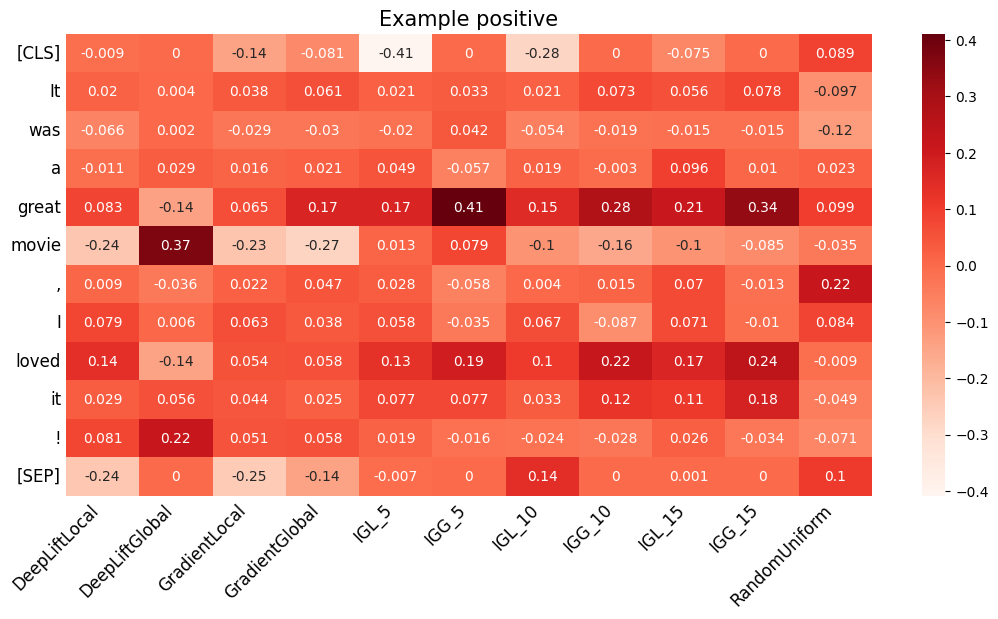

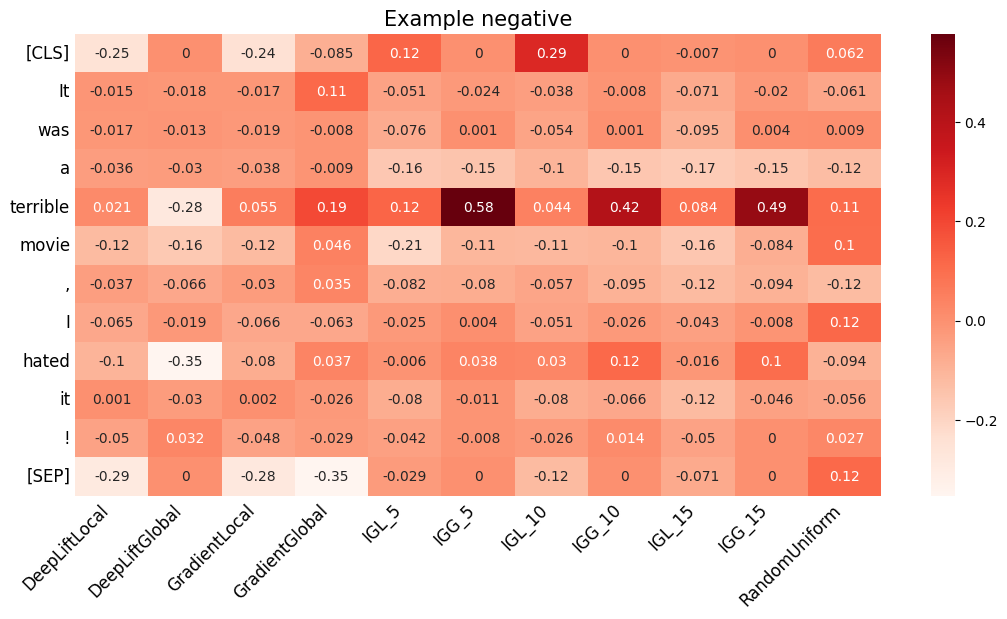

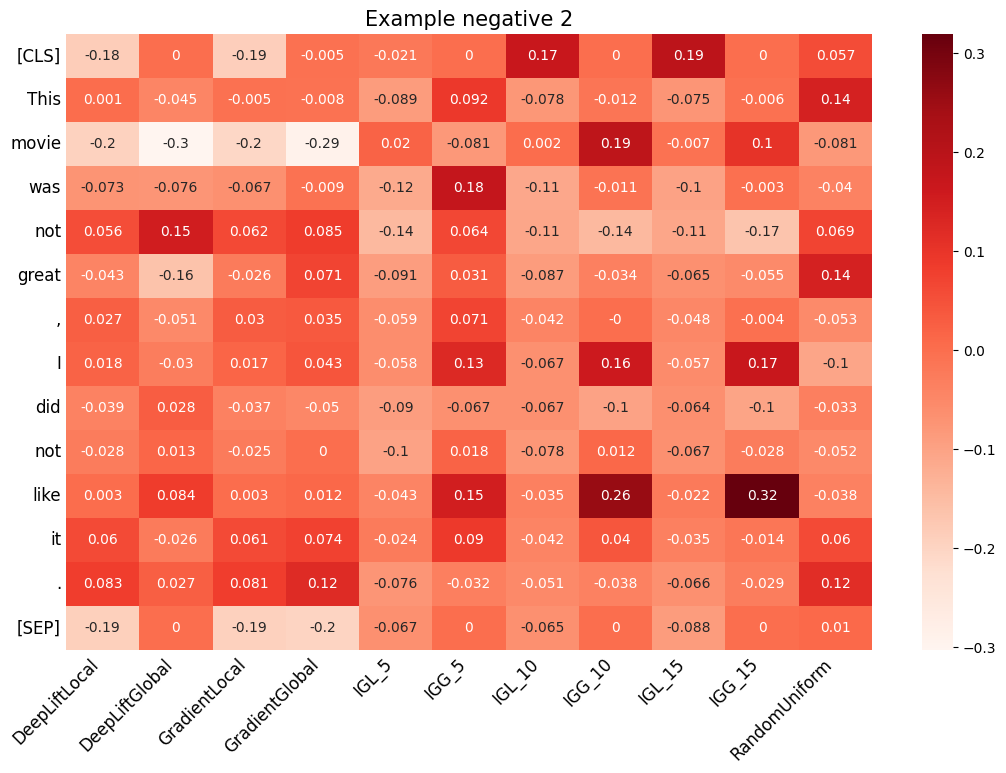

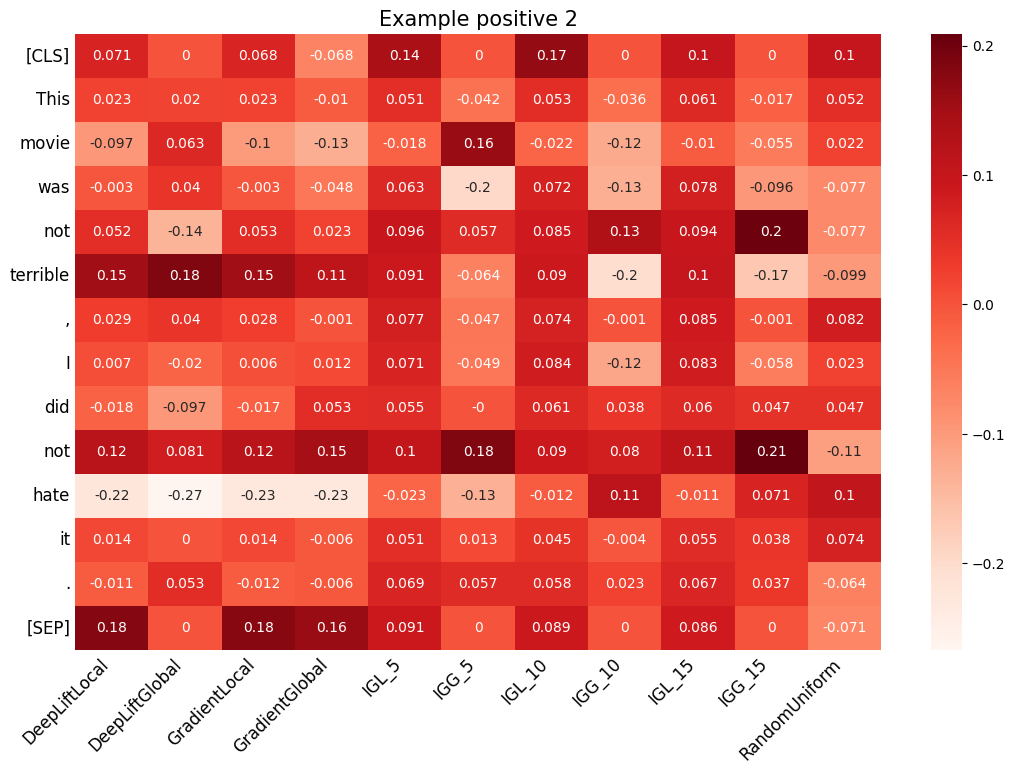

In [109]:
for i in range(len(sample_examples)):
  ind = ["[CLS]"] + tokenizer.tokenize(sample_examples[i].text) + ["[SEP]"]
  df = pd.DataFrame({explainer_name: example[i].normalized_attr for explainer_name, example in all_examples.items()}, index=ind)[local_global_order]
  df["RandomUniform"] = example_random[i]["attr"]
  create_heatmap(df, title="Example" + suffixes[i], **example_kwargs)

### Correlation between explainers

In [110]:
corr_path = figures_path / "correlation"

#### Utils

In [111]:
def aggr_similarity_values(similarity_values, aggr_func):
  return {
    explainer_name_1: {
      explainer_name_2: aggr_func(sim_values) for explainer_name_2, sim_values in sim_values_dict.items()
    } for explainer_name_1, sim_values_dict in similarity_values.items()
}

In [112]:
def get_similarity_all_explainer_pairs(exp_mapping1, explainer_names1, similarity_func, exp_mapping2=None, explainer_names2=None, only_label=None):
  if exp_mapping2 is None or explainer_names2 is None:
    exp_mapping2, explainer_names2 = exp_mapping1, list(explainer_names1)
  res = {explainer_name: defaultdict(list) for explainer_name in set(explainer_names1).union(explainer_names2)}
  for text_id, explanations_dict in exp_mapping1.items():
    for i, (explainer_name, exp) in enumerate(explanations_dict.items()):
      for j, explainer_name2 in enumerate(explainer_names2):
        if only_label is None or (only_label is not None and exp.label == only_label):
          exp2 = exp_mapping2[text_id][explainer_name2]
          res[explainer_name][explainer_name2].append(similarity_func(exp.attr, exp2.attr))
  return res

In [113]:
def update_with_custom(d1, d2, col="RandomUniform"):
  d = deepcopy(d1)
  a = {}
  for k in d1.keys():
    if k in d2:
      d[k][col] = d2[k][col]
      a[k] = d2[k][col]
  a[col] = [1.0] * len(a[k])
  d[col] = a
  return d

#### Calculations

In [114]:
spearman_default_kwargs = {
    "exp_mapping1": all_default_mapping,
    "explainer_names1": explainers_regular,
    "similarity_func": lambda x, y: spearmanr(x, y).statistic
}

In [115]:
spearmanr_values_default = get_similarity_all_explainer_pairs(**spearman_default_kwargs)
# with open(inter_path / "spearmanr_values_default.json", "w") as f:
#   json.dump(spearmanr_values_default, f)
# with open(inter_path / "spearmanr_values_default.json", "r") as f:
#   spearmanr_values_default = json.load(f)

In [116]:
spearmanr_default_custom = get_similarity_all_explainer_pairs(
    **spearman_default_kwargs,
    exp_mapping2=custom_attr_mapping,
    explainer_names2=["RandomUniform"],
)
# with open(inter_path / "spearmanr_values_default_custom.json", "w") as f:
#   json.dump(spearmanr_default_custom, f)
# with open(inter_path / "spearmanr_values_default_custom.json", "r") as f:
#   spearmanr_default_custom = json.load(f)

In [117]:
spearmanr_values_default = update_with_custom(spearmanr_values_default, spearmanr_default_custom)

In [118]:
spearmanr_values_default_mean = aggr_similarity_values(spearmanr_values_default, np.mean)
spearmanr_values_default_median = aggr_similarity_values(spearmanr_values_default, np.median)

In [119]:
spearmanr_values_default_pos = get_similarity_all_explainer_pairs(**spearman_default_kwargs, only_label=1)

In [120]:
spearmanr_values_default_neg = get_similarity_all_explainer_pairs(**spearman_default_kwargs, only_label=0)

In [121]:
spearmanr_values_default_mean_pos = aggr_similarity_values(spearmanr_values_default_pos, np.mean)
spearmanr_values_default_mean_neg = aggr_similarity_values(spearmanr_values_default_neg, np.mean)

In [122]:
def aggr_pctg_negative_values(x):
  return np.mean(np.array(x) < 0)

In [123]:
spearmanr_values_negative_pctg_pos = aggr_similarity_values(spearmanr_values_default_pos, aggr_pctg_negative_values)
spearmanr_values_negative_pctg_neg = aggr_similarity_values(spearmanr_values_default_neg, aggr_pctg_negative_values)
spearmanr_values_negative_pctg = aggr_similarity_values(spearmanr_values_default, aggr_pctg_negative_values)

#### Visualization

% of negative correlations

In [124]:
corr_heatmap_full_kwargs = {
    "annot": True,
    "path": corr_path,
    "figsize": (12, 5),
    "triang": False
}
corr_heatmap_small_kwargs = {
    "annot": True,
    "path": corr_path,
    "figsize": (7, 4),
    "triang": False
}

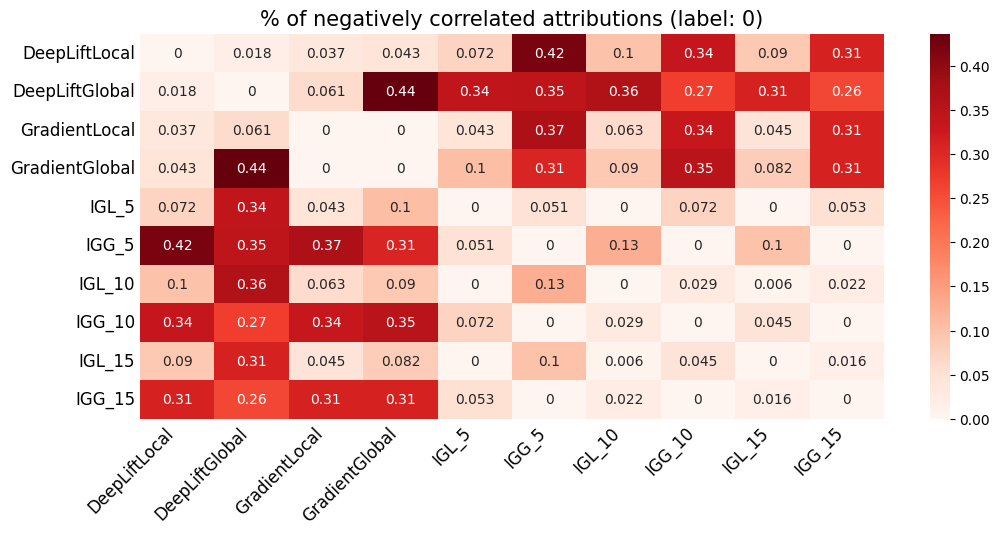

In [125]:
title = "% of negatively correlated attributions (label: 0)"
filename = "pctg_neg_corr_neg"
df = pd.DataFrame(spearmanr_values_negative_pctg_neg).loc[local_global_order, local_global_order]
create_heatmap(df, title=title, filename=filename, **corr_heatmap_full_kwargs)

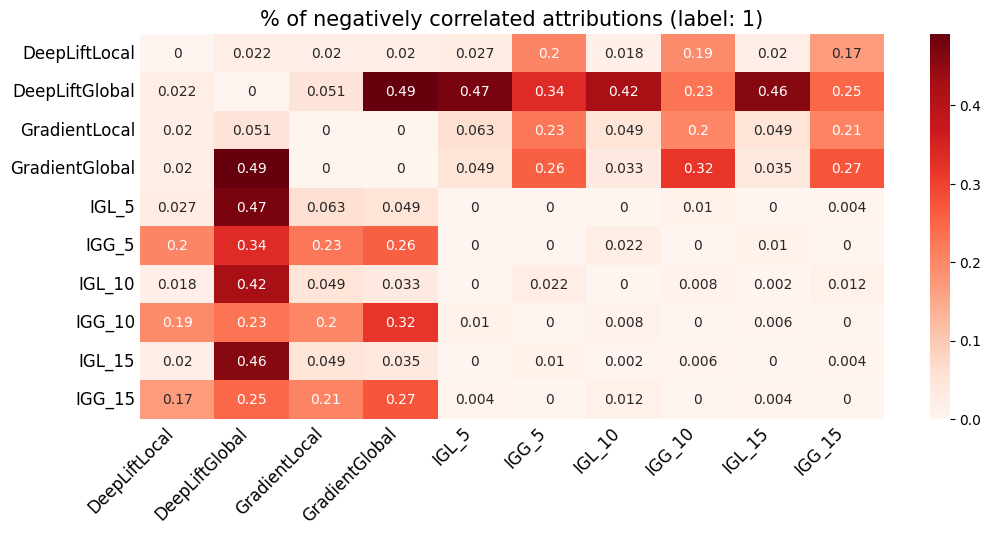

In [126]:
title = "% of negatively correlated attributions (label: 1)"
filename = "pctg_neg_corr_pos"
df = pd.DataFrame(spearmanr_values_negative_pctg_pos).loc[local_global_order, local_global_order]
create_heatmap(df, title=title, filename=filename, **corr_heatmap_full_kwargs)

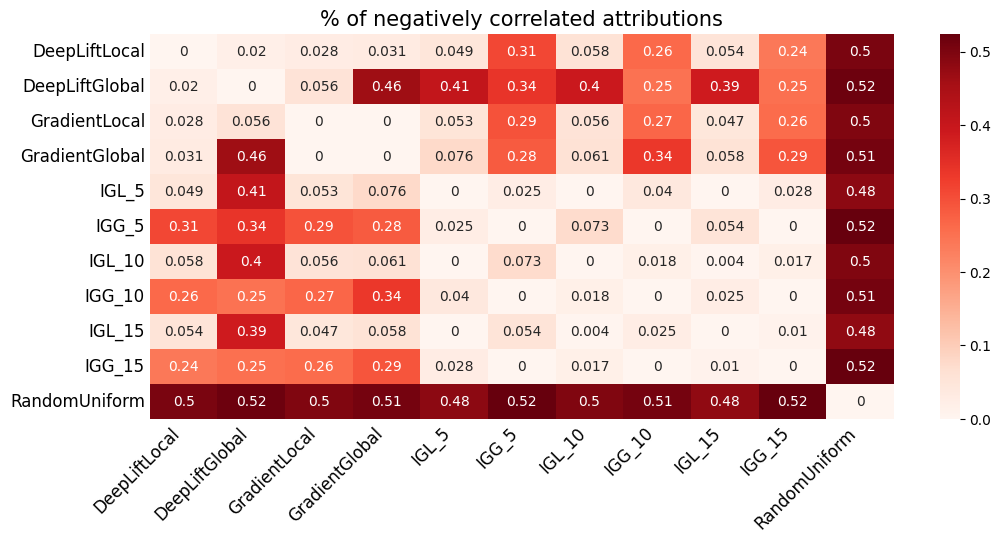

In [127]:
title = "% of negatively correlated attributions"
filename = "pctg_neg_corr"
df = pd.DataFrame(spearmanr_values_negative_pctg).loc[local_global_order+["RandomUniform"], local_global_order+["RandomUniform"]]
create_heatmap(df, title=title, filename=filename, **corr_heatmap_full_kwargs)

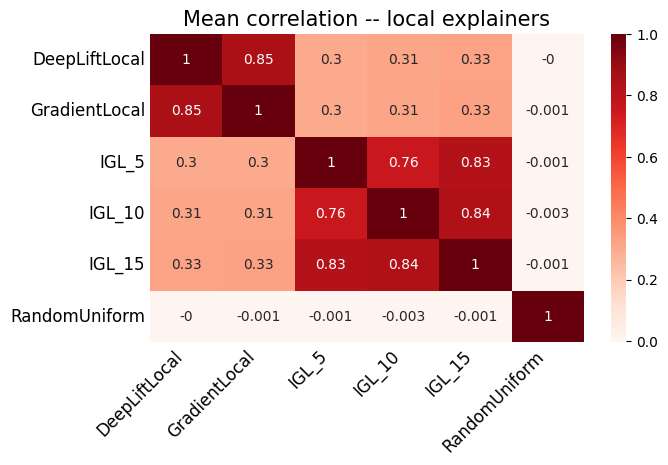

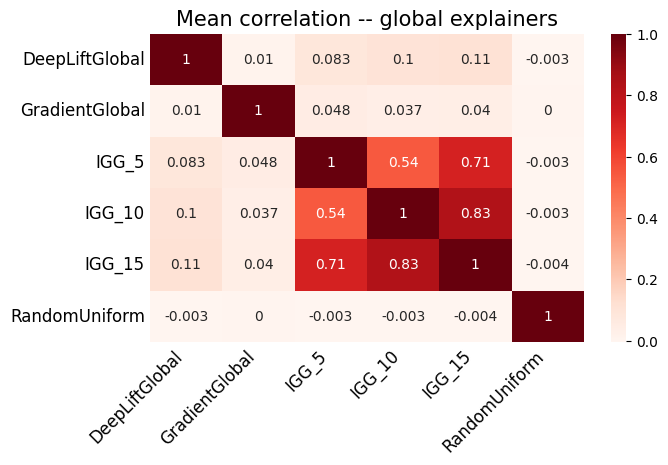

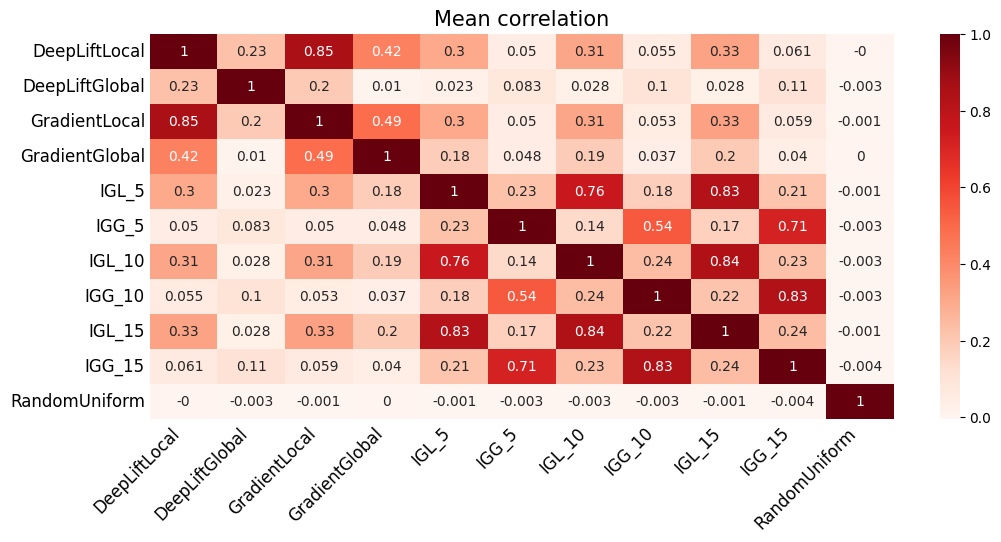

In [128]:
_df = pd.DataFrame(spearmanr_values_default_mean)
explainers_to_use = explainers_local + ['RandomUniform']
create_heatmap(_df.loc[explainers_to_use, explainers_to_use], title= "Mean correlation -- local explainers", filename="mean_correlation_local", **corr_heatmap_small_kwargs)

explainers_to_use = explainers_global+ ['RandomUniform']
create_heatmap(_df.loc[explainers_to_use, explainers_to_use], title= "Mean correlation -- global explainers", filename="mean_correlation_global", **corr_heatmap_small_kwargs)

explainers_to_use = explainers_regular + ['RandomUniform']
create_heatmap(
    _df.loc[explainers_to_use, explainers_to_use], **corr_heatmap_full_kwargs,
    title= "Mean correlation", filename="mean_correlation_all"
)

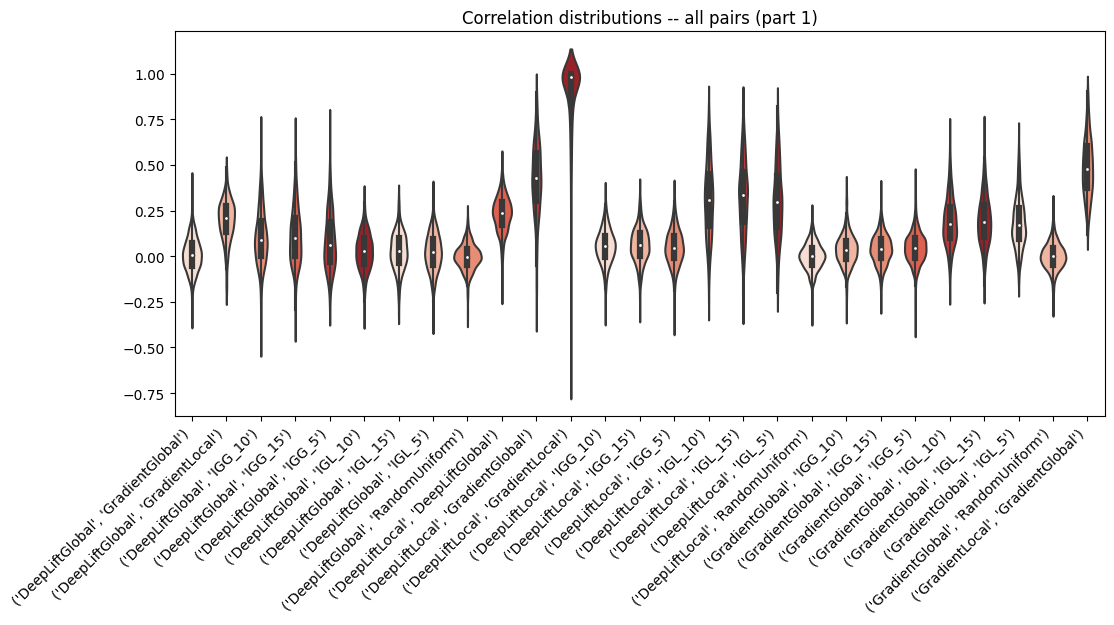

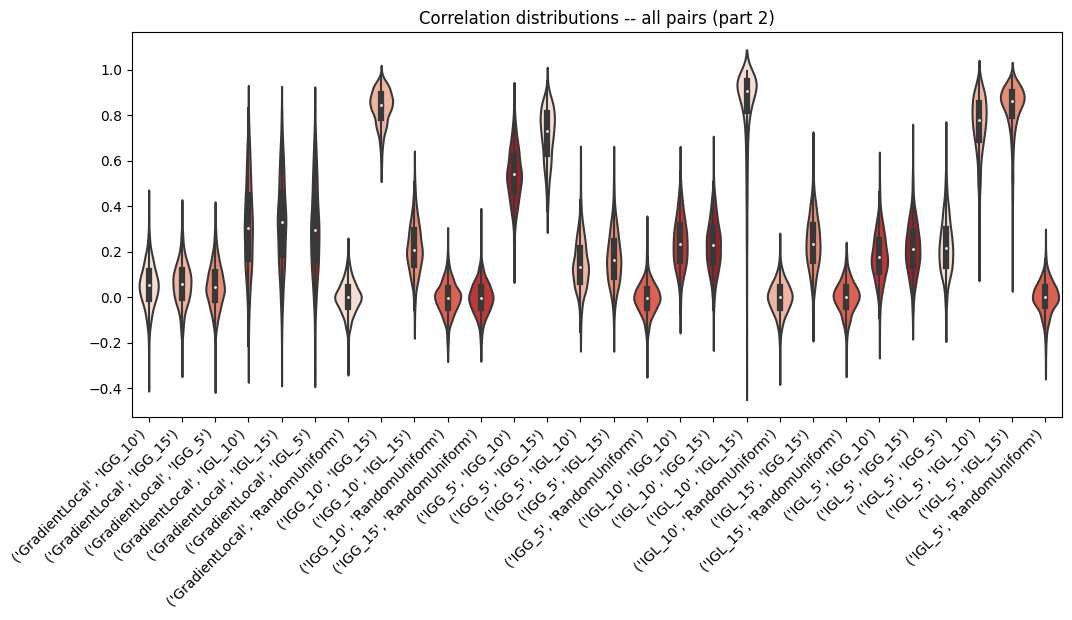

In [129]:
df = pd.DataFrame(spearmanr_values_default).stack(level=0).to_frame().T.apply(lambda x: x.explode(), axis=0)
a = []
for i in df.columns:
  if i[0] != i[1] and (i[1], i[0]) not in a:
    a.append(i)
_df = df[sorted(a)]
half = int(len(_df.columns) / 2)
create_violin_plot(_df.iloc[:, :half], figsize=(12, 5), title="Correlation distributions -- all pairs (part 1)", filename="corr_dist_all_pairs_1", path=corr_path)
create_violin_plot(_df.iloc[:, half:], figsize=(12, 5), title="Correlation distributions -- all pairs (part 2)", filename="corr_dist_all_pairs_2", path=corr_path)

#### Ensemble Correlation

In [130]:
spearmanr_values_meta_explainers = defaultdict(dict)
for metric_name, combs in combinations.items():
  for k, v in combs.items():
    for k2, v2 in combs.items():
      spearmanr_values_meta_explainers[k][k2] = get_attr_similarity(v, v2, spearmanr, lambda x: [i.statistic for i in x])
  with open(inter_path / f"spearmanr_values_meta_explainers_{metric_name}.json", "w") as f:
    json.dump(spearmanr_values_meta_explainers, f)

In [131]:
spearmanr_values_meta_explainers = {}
for metric_name in metric_names:
  with open(inter_path / f"spearmanr_values_meta_explainers_{metric_name}.json", "r") as f:
    spearmanr_values_meta_explainers[metric_name] = json.load(f)

In [132]:
spearmanr_values_default_meta_explainers = defaultdict(dict)
aggr_func = lambda x: np.mean([i.statistic for i in x])
for metric_name, combs in combinations.items():
  for k, v in combs.items():
    for k2, v2 in all_default.items():
      val = get_attr_similarity(v, v2, spearmanr, lambda x: [i.statistic for i in x])
      spearmanr_values_default_meta_explainers[k][k2] = val
      spearmanr_values_default_meta_explainers[k2][k] = val
  with open(inter_path / f"spearmanr_values_default_meta_explainers_{metric_name}.json", "w") as f:
    json.dump(spearmanr_values_default_meta_explainers, f)

In [133]:
spearmanr_values_default_meta_explainers = {}
for metric_name in metric_names:
  with open(inter_path / f"spearmanr_values_default_meta_explainers_{metric_name}.json", "r") as f:
    spearmanr_values_default_meta_explainers[metric_name] = json.load(f)

In [134]:
spearmanr_values_meta_explainers_mean = {metric_name: aggr_similarity_values(v, np.mean) for metric_name, v in spearmanr_values_meta_explainers.items()}

In [135]:
spearmanr_values_default_meta_explainers_mean = {metric_name: aggr_similarity_values(v, np.mean) for metric_name, v in spearmanr_values_default_meta_explainers.items()}

In [136]:
all_spearman_mean = {metric_name: combine_nested_dictionaries(
  [spearmanr_values_meta_explainers_mean[metric_name], spearmanr_values_default_meta_explainers_mean[metric_name], spearmanr_values_default_mean]
) for metric_name in metric_names}

In [137]:
# _df = pd.DataFrame(spearmanr_values_default_mean)
# explainers_to_use = local_global_order + ["RandomUniform"]
# create_heatmap(_df.loc[explainers_to_use, explainers_to_use], figsize=(10, 6), triang=True)

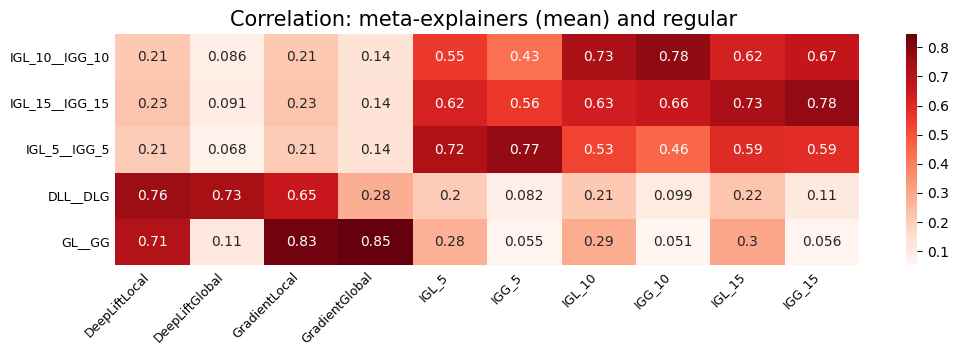

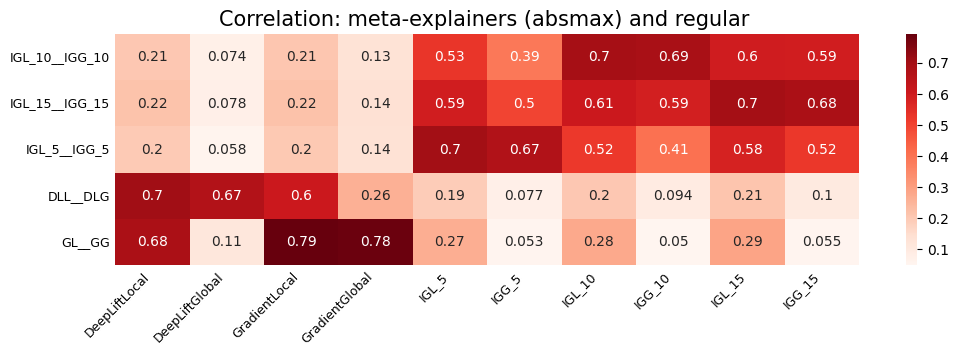

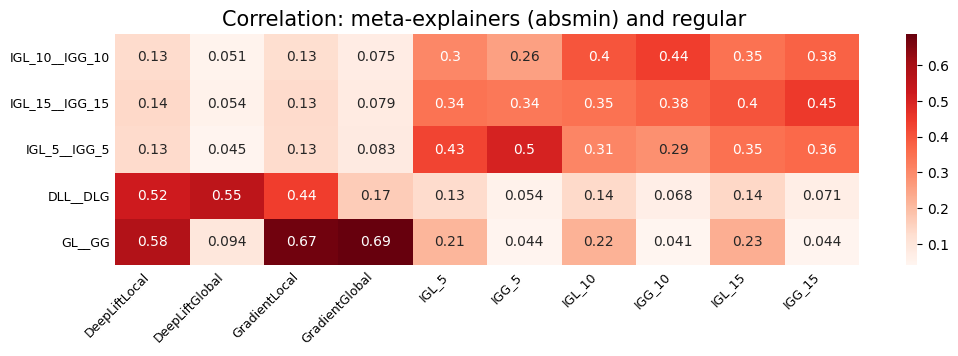

In [138]:
for metric_name in metric_names:
  comb_names = sorted(combinations[metric_name].keys(), key=len, reverse=True)
  create_heatmap(
    pd.DataFrame(all_spearman_mean[metric_name]).loc[explainers_regular, comb_names].T,
    figsize=(12, 3),
    title= f"Correlation: meta-explainers ({metric_name}) and regular ", annot=True, filename=f"{metric_name}_corr_meta_mean_reg_",
    fontsize_x=9, fontsize_y=9, path=corr_path
  )

### Complexity metrics analysis

In [139]:
compl_path = figures_path / "complexity"
compl_plot_kwargs = {"path": compl_path, "filename": "complexity"}

#### Complexity

In [140]:
custom_attr_complexity = {k: [complexity(i) for i in v] for k, v in custom_attr.items()}

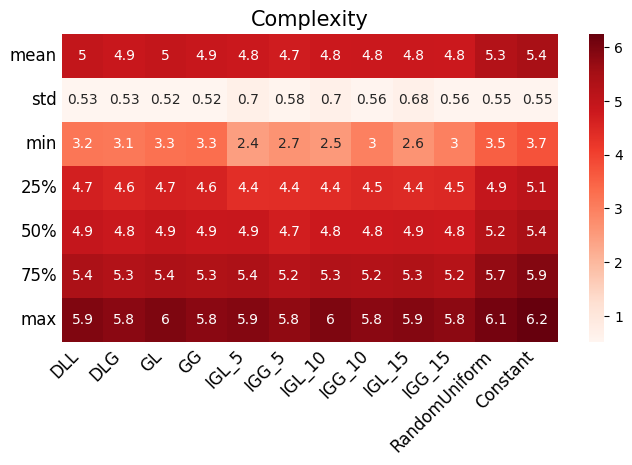

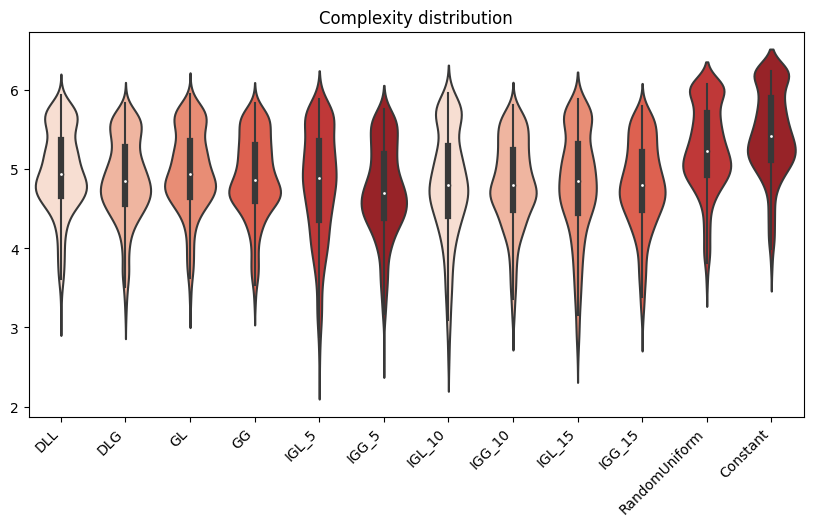

In [141]:
_complexity = {k: [complexity(i) for i in v] for k, v in all_default.items()}
_complexity.update(custom_attr_complexity)
_complexity_df = pd.DataFrame(_complexity)[local_global_order+["RandomUniform", "Constant"]].rename(columns=columns_mapping_short)
complexity_stats_df = get_stats_df(_complexity)[local_global_order+["RandomUniform", "Constant"]].rename(columns=columns_mapping_short).round(3)

create_heatmap(complexity_stats_df, figsize=(8, 4), triang=False, title= "Complexity", annot=True, **compl_plot_kwargs)

create_violin_plot(_complexity_df, figsize=(10, 5), title="Complexity distribution", **compl_plot_kwargs)

# create_multiple_histograms_from_df(
#     _complexity_df, title="Complexity distribution", figsize=(12, 5), nrows=1, ncols=len(_complexity_df.columns), sub_font=10, title_y=1.04, **compl_plot_kwargs, add_mean=False)

In [142]:
meta_local_global_order = np.concatenate([[i, j, k] for i, j, k in zip(sorted(combinations["mean"].keys()), sorted(explainers_local), sorted(explainers_global))]).tolist()
meta_local_global_custom_order = meta_local_global_order  + ["RandomUniform", "Constant"]

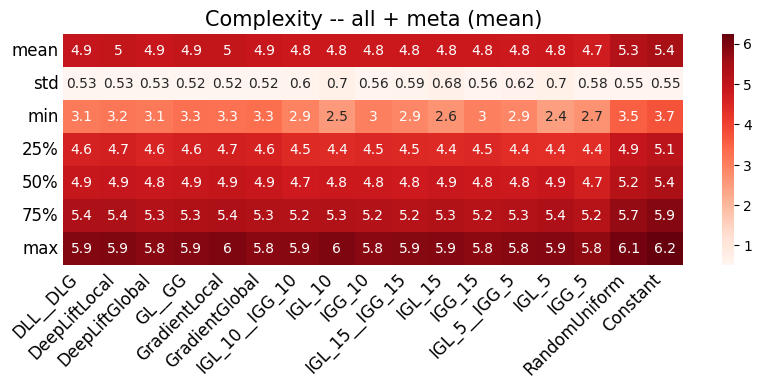

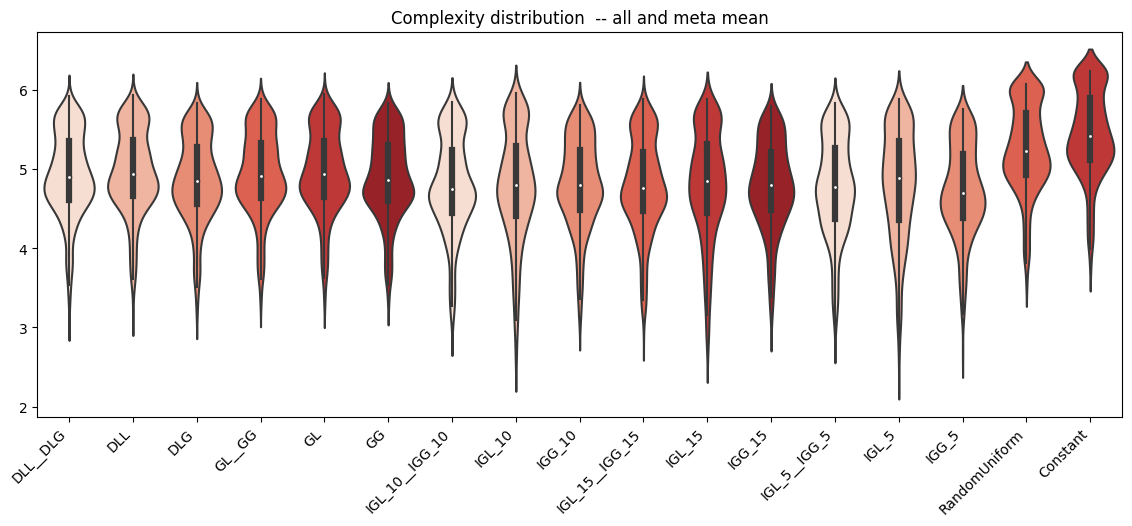

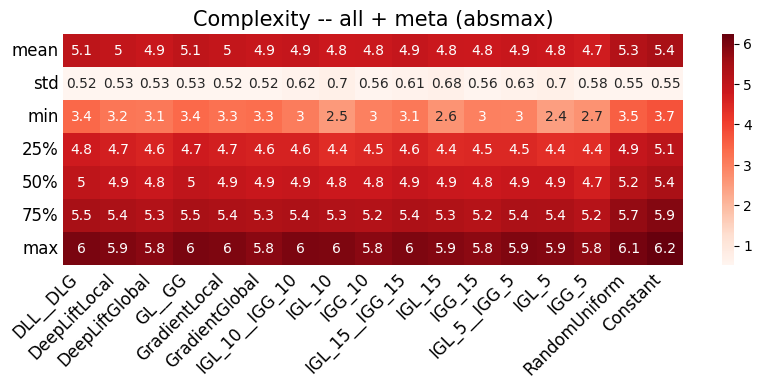

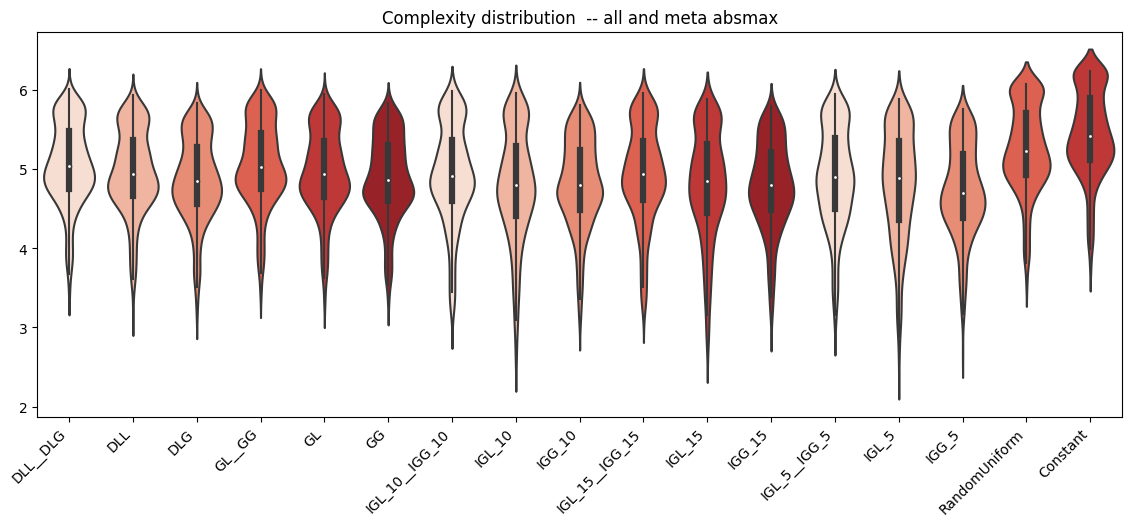

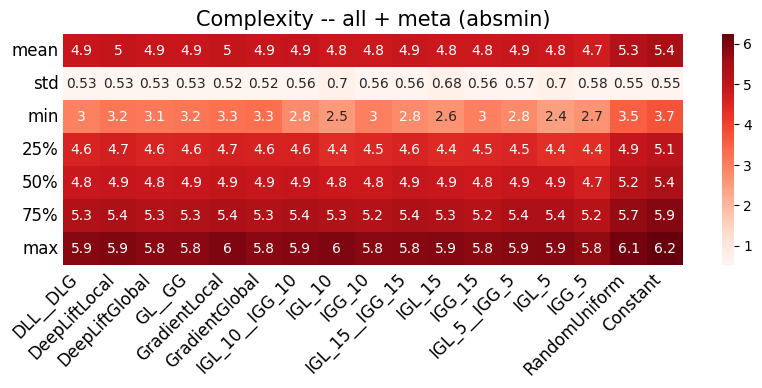

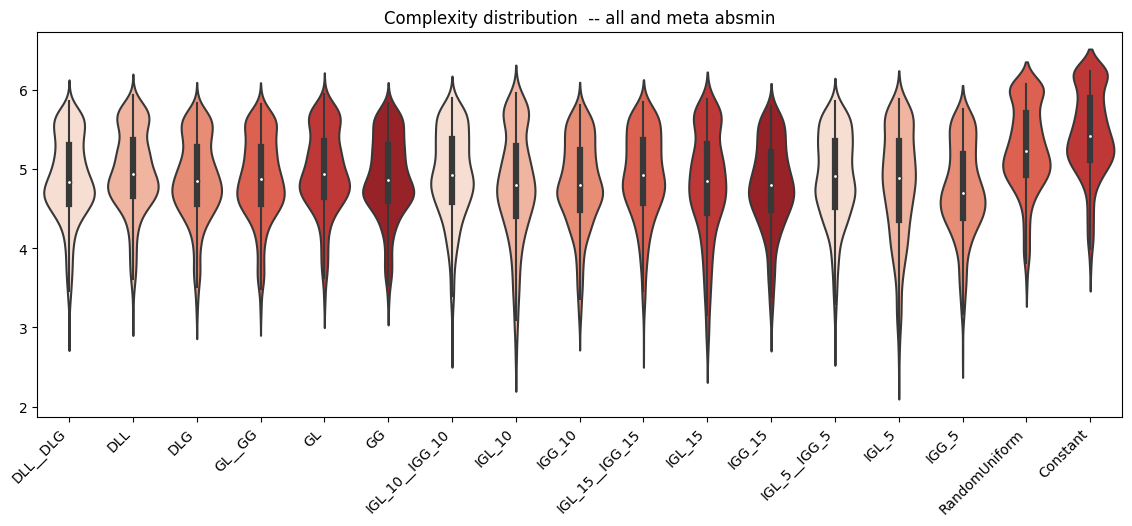

In [143]:
_complexity_comb = {}
for metric_name, combs in combinations.items():
  _complexity_comb[metric_name] = {k: [complexity(i) for i in v] for k, v in combs.items()}
  _complexity_comb[metric_name].update(_complexity)
  create_heatmap(
      get_stats_df(_complexity_comb[metric_name])[meta_local_global_custom_order].round(3), figsize=(10, 3), triang=False, title= f"Complexity -- all + meta ({metric_name})",
      annot=True, path=compl_path, filename=f"complexity_all_meta_{metric_name}"
  )
  _complexity_comb_df = pd.DataFrame(_complexity_comb[metric_name])[meta_local_global_custom_order].rename(columns=columns_mapping_short)
  create_violin_plot(_complexity_comb_df, figsize=(14, 5), title=f"Complexity distribution  -- all and meta {metric_name}", filename=f"complexity_all_meta_{metric_name}", path=compl_path)
  # create_multiple_histograms_from_df(
  #     _complexity_comb_df, figsize=(16, 5), nrows=1, ncols=len(_complexity_comb_df.columns),
  #     title=f"Complexity -- all + meta ({metric_name})", title_y=1.04,
  #     filename=f"complexity_all_meta_{metric_name}", path=compl_path, sub_font=10)

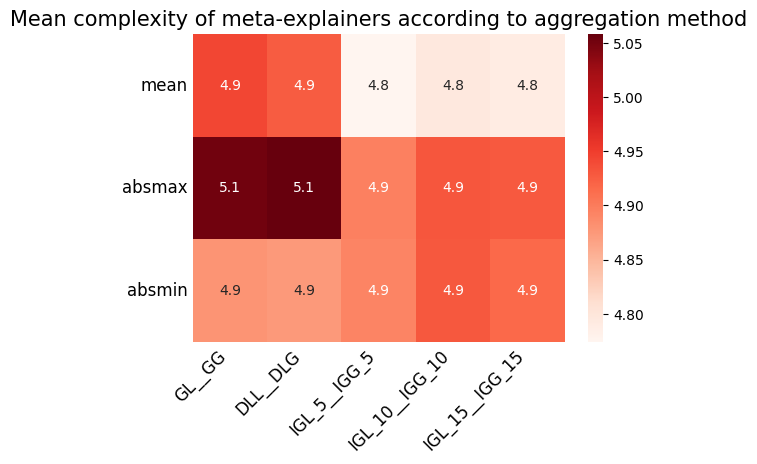

In [144]:
_df = pd.concat([get_stats_df(v)[combinations[metric_name].keys()].rename(columns=columns_mapping_short).loc["mean", :].rename(metric_name).to_frame().T for metric_name, v in _complexity_comb.items()])
create_heatmap(_df, annot=True, figsize=(6, 4), title="Mean complexity of meta-explainers according to aggregation method", filename="complexity_meta_mean", path=compl_path)

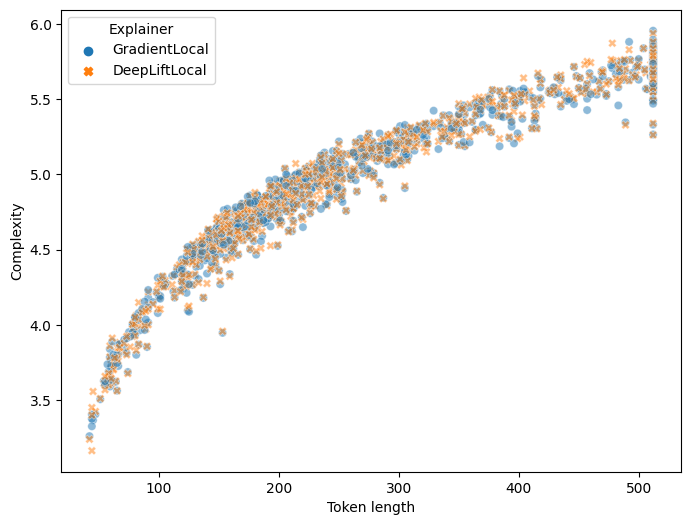

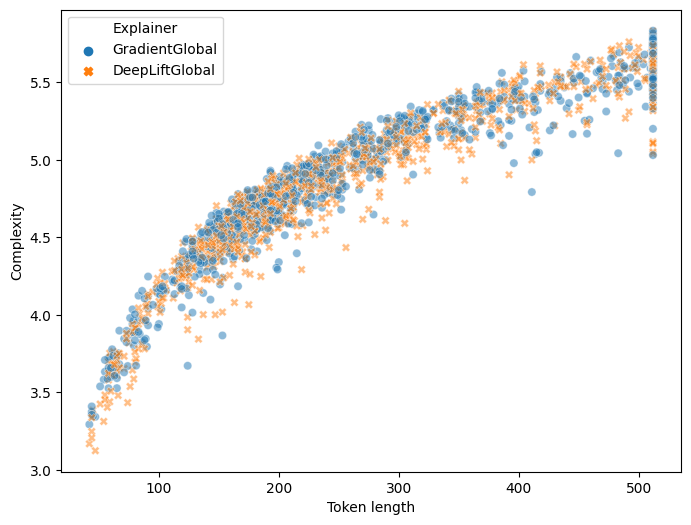

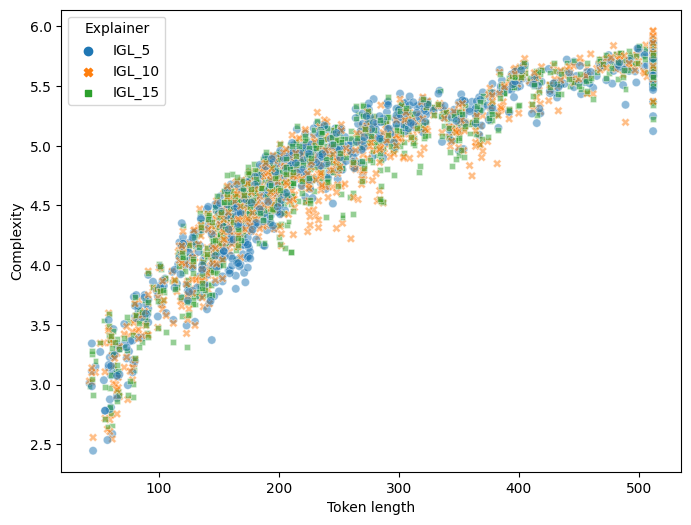

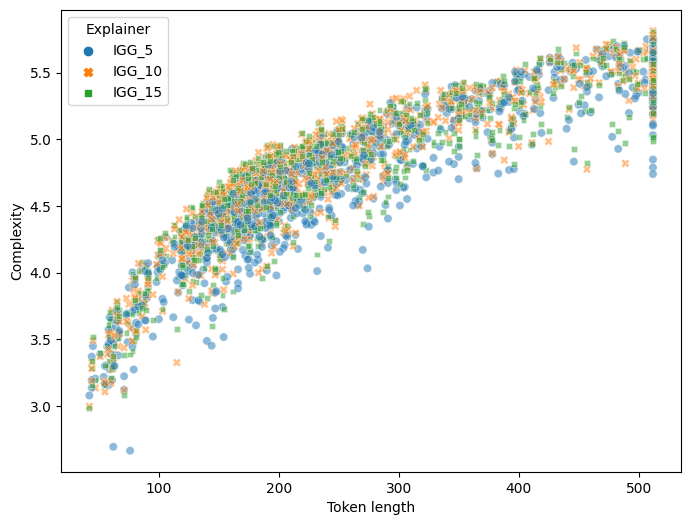

In [145]:
_df = pd.DataFrame(_complexity, index=pd.Series(exp_length, name="Len_tokens"))
_df = _df.stack().to_frame().reset_index()
_df.columns = ["Token length", "Explainer", "Complexity"]

create_scatterplot(_df.query("Explainer in @explainers_local and Explainer in @explainers_simple"), "Token length", "Complexity", hue="Explainer",
                   figsize=(8, 6), alpha=0.5, filename="complexity_local_simple_token_len", path=compl_path)
create_scatterplot(_df.query("Explainer in @explainers_global and Explainer in @explainers_simple"), "Token length", "Complexity", hue="Explainer",
                   figsize=(8, 6), alpha=0.5, filename="complexity_global_simple_token_len", path=compl_path)

create_scatterplot(_df.query("Explainer in @explainers_local and Explainer in @explainers_ig"), "Token length", "Complexity", hue="Explainer",
                   figsize=(8, 6), alpha=0.5, filename="complexity_local_ig_token_len", path=compl_path)
create_scatterplot(_df.query("Explainer in @explainers_global and Explainer in @explainers_ig"), "Token length", "Complexity", hue="Explainer",
                   figsize=(8, 6), alpha=0.5, filename="complexity_global_ig_token_len", path=compl_path)

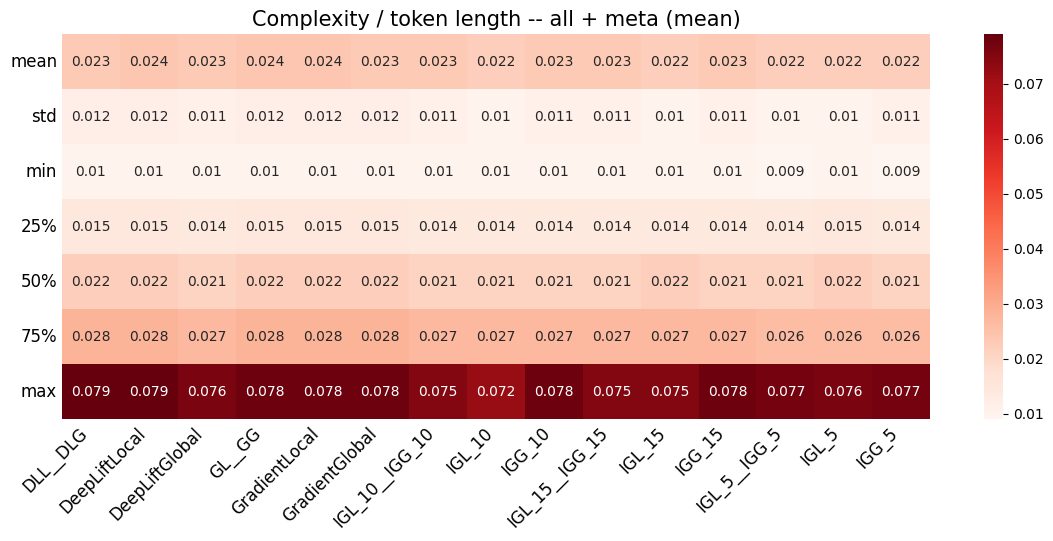

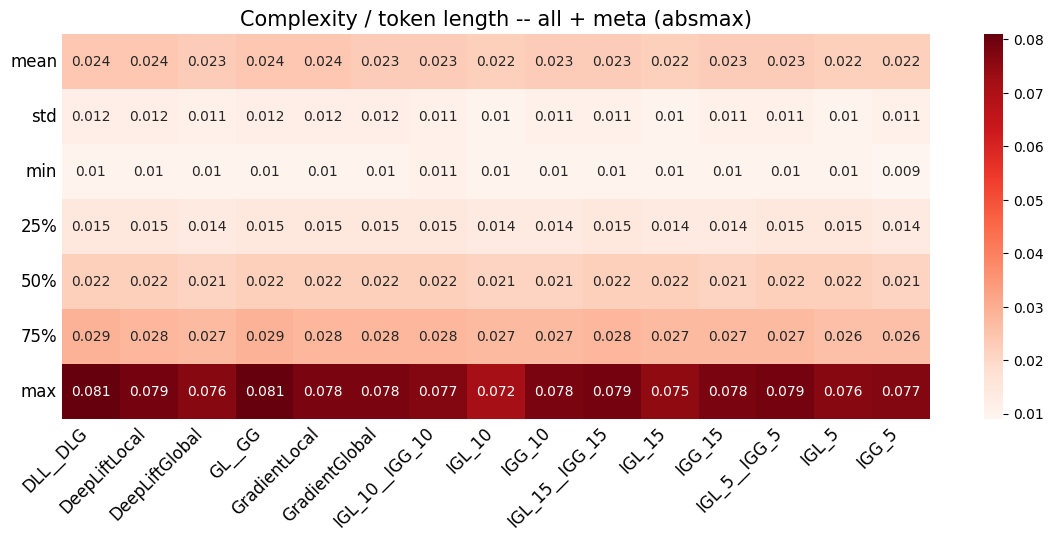

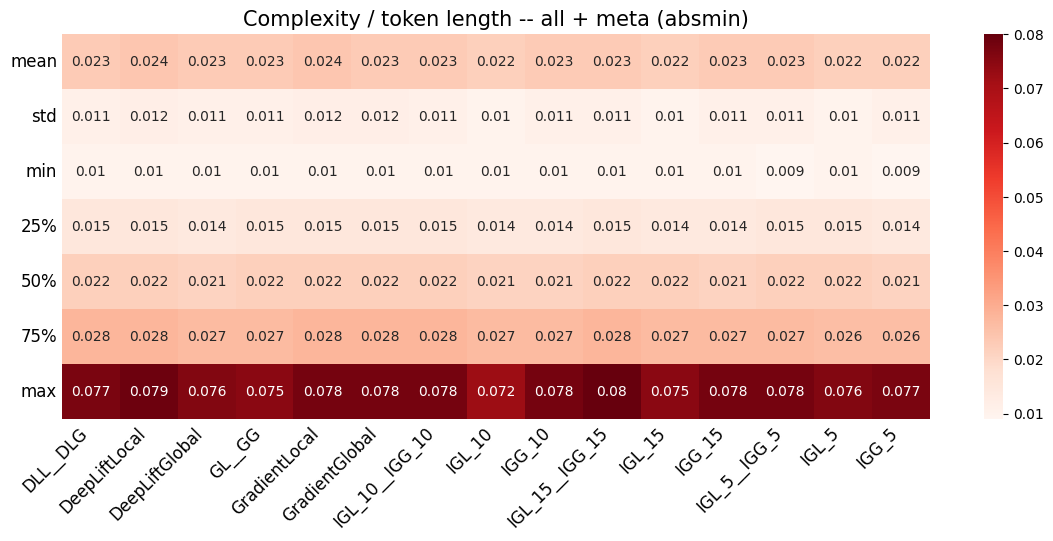

In [146]:
# complexity / token len
for metric_name, combs in combinations.items():
  custom_attr_complexity = {k: [complexity(i) / len(i.attr) for i in v] for k, v in custom_attr.items()}
  _complexity = {k: [complexity(i) / len(i.attr) for i in v] for k, v in all_default.items()}
  _complexity.update(custom_attr_complexity)
  _complexity_comb = {k: [complexity(i) / len(i.attr) for i in v] for k, v in combs.items()}
  _complexity_comb.update(_complexity)
  create_heatmap(
      get_stats_df(_complexity_comb)[meta_local_global_order].round(3), figsize=(14, 5), triang=False, title= f"Complexity / token length -- all + meta ({metric_name})",
      annot=True, path=compl_path, filename=f"complexity_div_by_token_length_all_meta_{metric_name}"
  )
  _complexity_comb_df = pd.DataFrame(_complexity_comb)[meta_local_global_order].rename(columns=columns_mapping_short)
  # create_violin_plot(_complexity_comb_df, figsize=(14, 5), title=f"Complexity / token length -- all and meta  {metric_name}", filename=f"complexity_div_by_token_length_all_meta_{metric_name}", path=compl_path)
  # create_multiple_histograms_from_df(
  #     pd.DataFrame(_complexity_comb), figsize=(16, 5), nrows=1, ncols=len(list(_complexity_comb)),
  #     title=f"Complexity / token length -- all + meta ({metric_name})", title_y=1.04,
  #     filename=f"complexity_div_by_token_length_all_meta_{metric_name}", path=compl_path, sub_font=10)

#### Sparseness

In [147]:
local_global_custom_order = local_global_order + ["RandomUniform", "Constant"]

In [148]:
_sparseness = {k: [sparseness(i) for i in v] for k, v in all_default.items()}
_len = {k: [len(i.attr) for i in v] for k, v in all_default.items()}

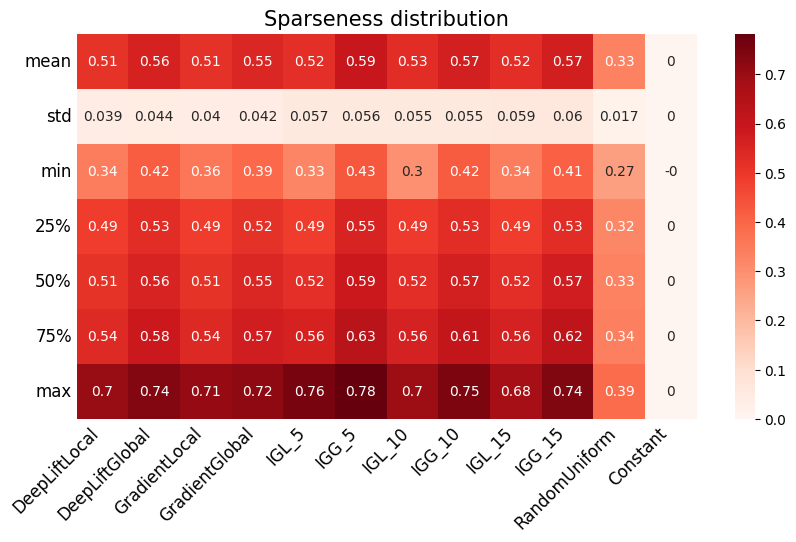

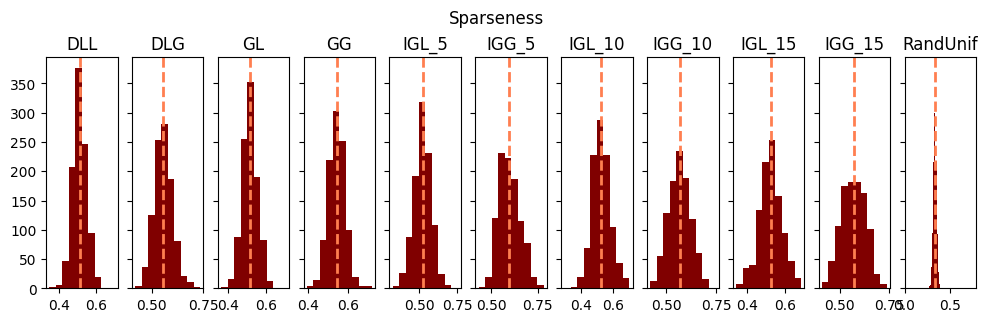

In [151]:
_sparseness = {k: [sparseness(i) for i in v] for k, v in all_default.items()}
_custom_attr_sparseness = {k: [sparseness(i) for i in v] for k, v in custom_attr.items()}
_sparseness.update(_custom_attr_sparseness)
create_heatmap(
    get_stats_df(_sparseness)[local_global_custom_order].round(3), figsize=(10, 5), triang=False, title= f"Sparseness distribution",
    annot=True, path=compl_path, filename=f"sparseness_all"
)
_sparseness_df = pd.DataFrame(_sparseness)[local_global_custom_order].rename(columns=columns_mapping_short)
# create_violin_plot(_sparseness_df, figsize=(14, 5), title=f"Sparseness", filename=f"sparseness_all", path=compl_path)
create_multiple_histograms_from_df(
    _sparseness_df.rename(columns=custom_mapping_short), figsize=(16, 5), nrows=1, ncols=len(_sparseness_df.columns)-1,
    title=f"Sparseness", title_y=1.04,
    filename=f"sparseness", path=compl_path, sub_font=10)

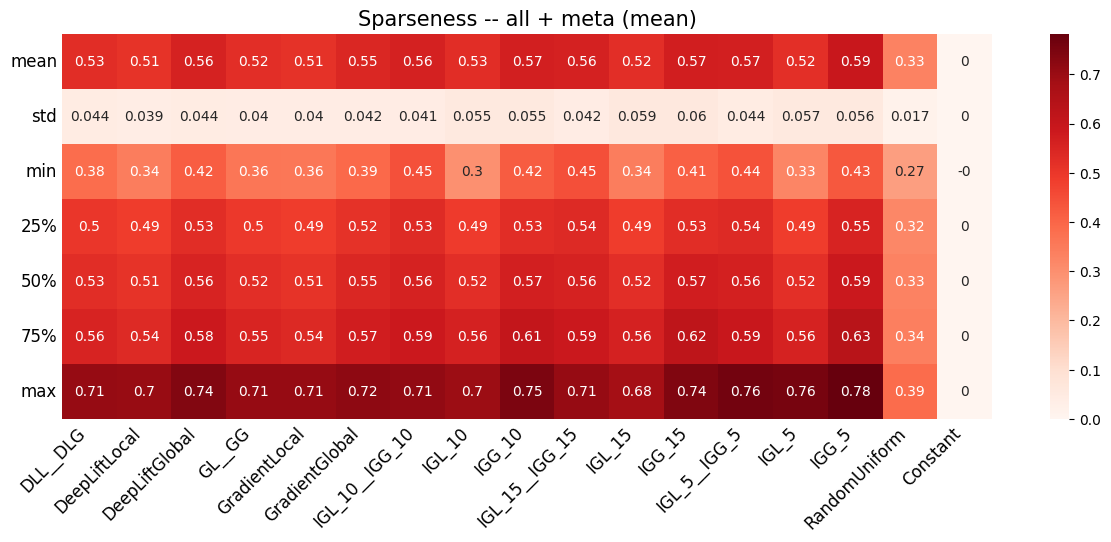

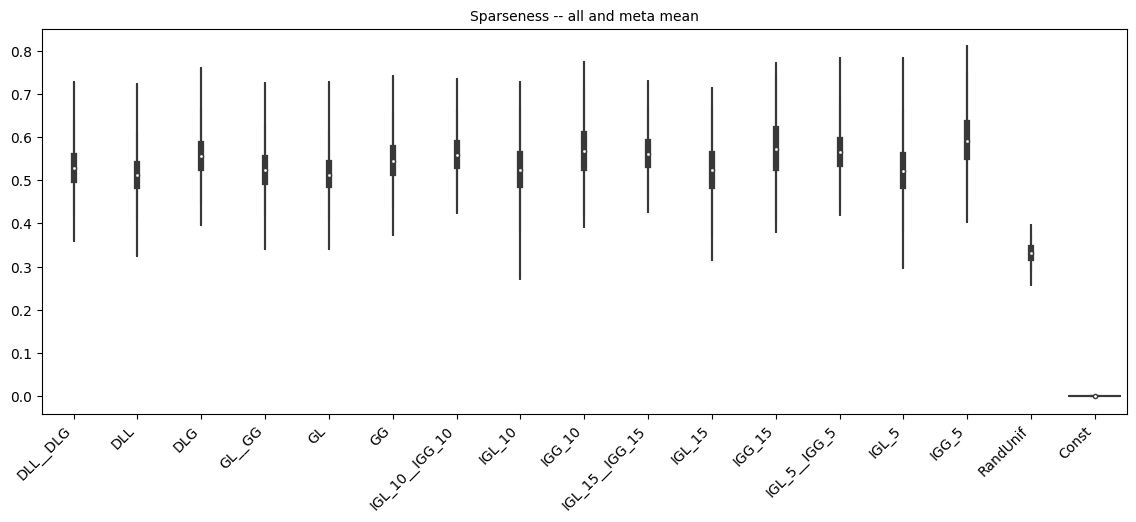

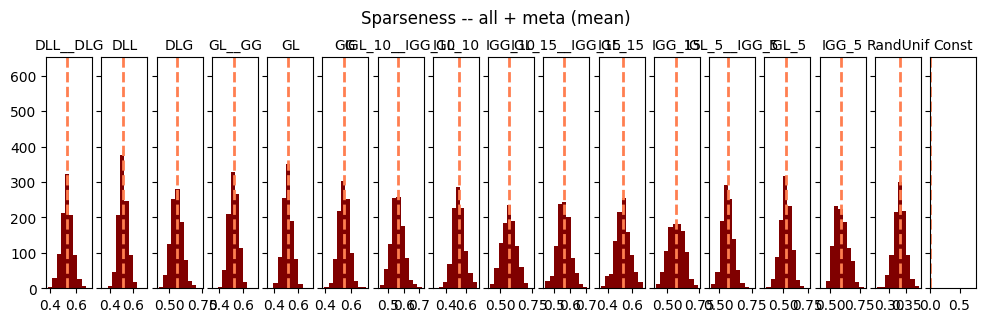

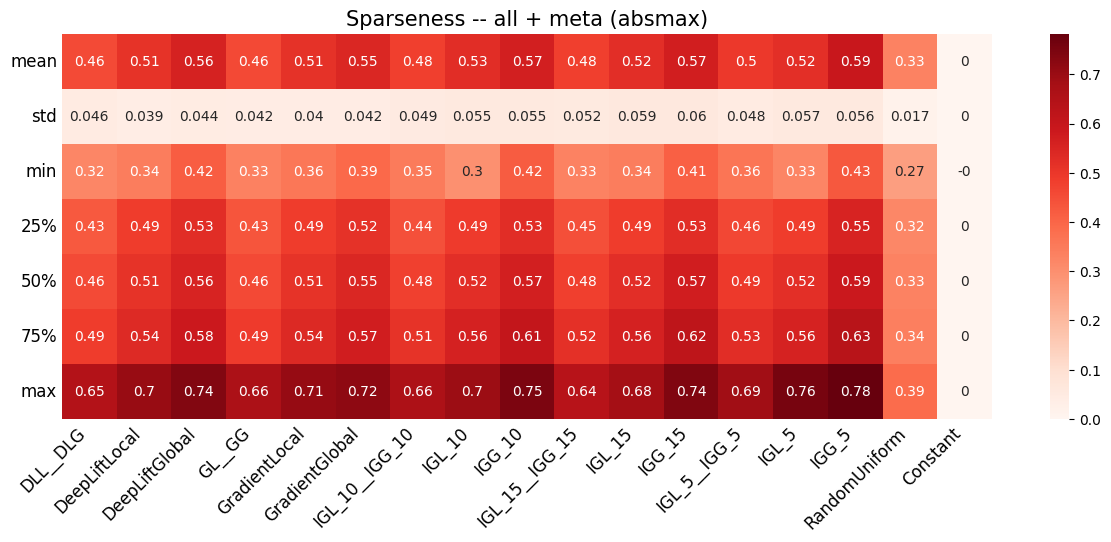

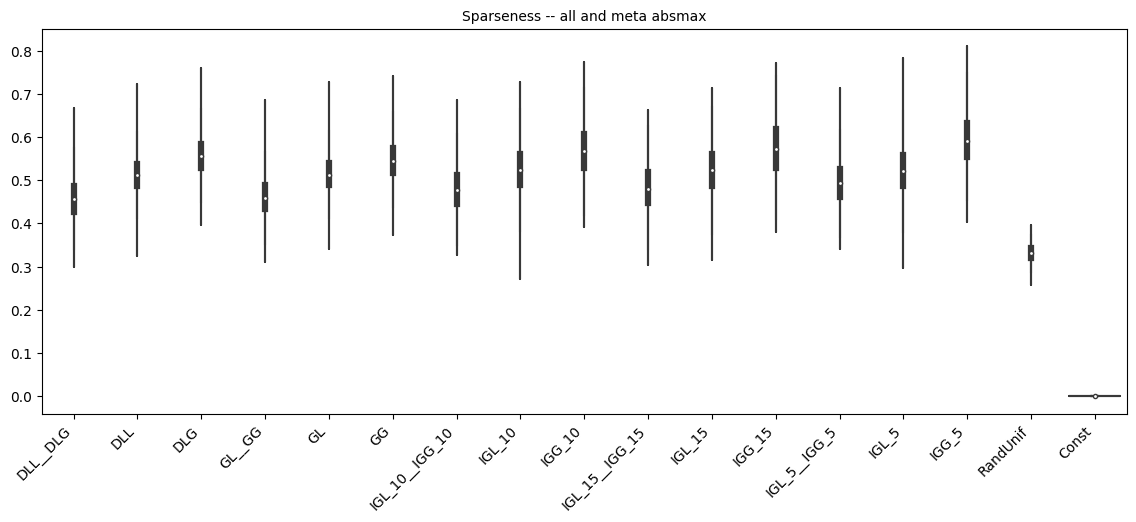

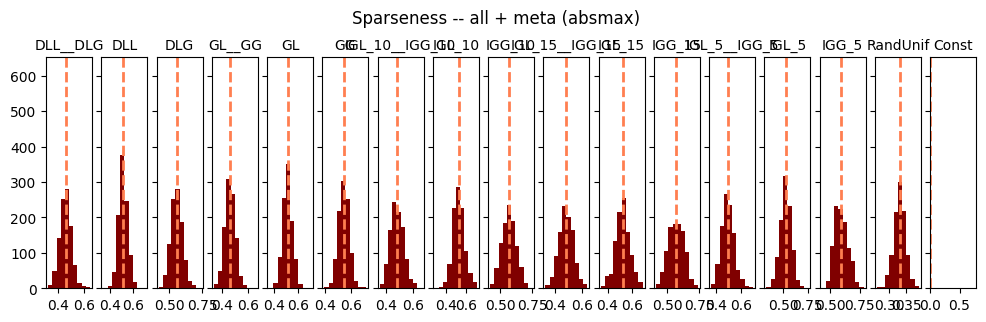

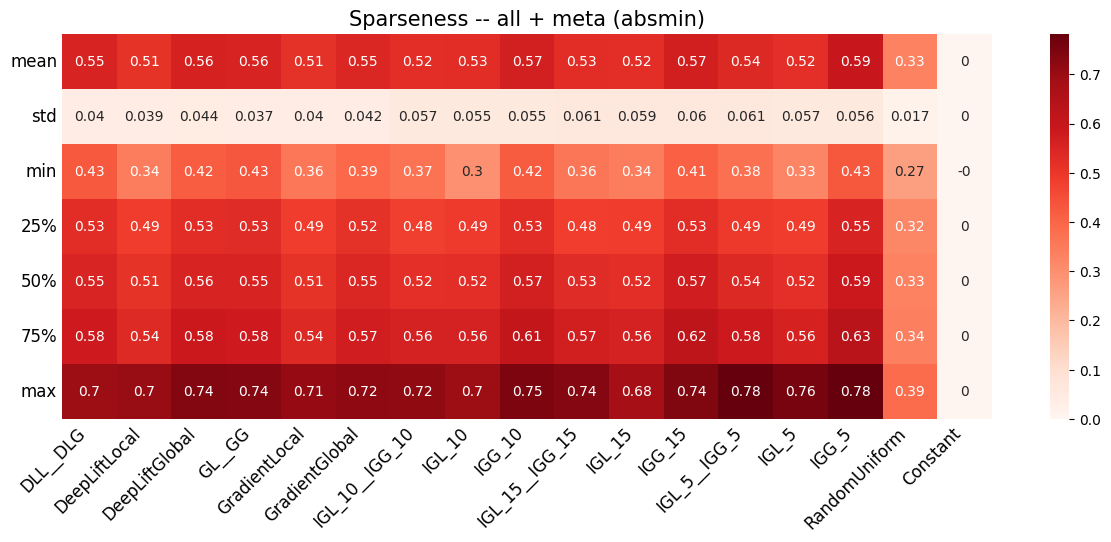

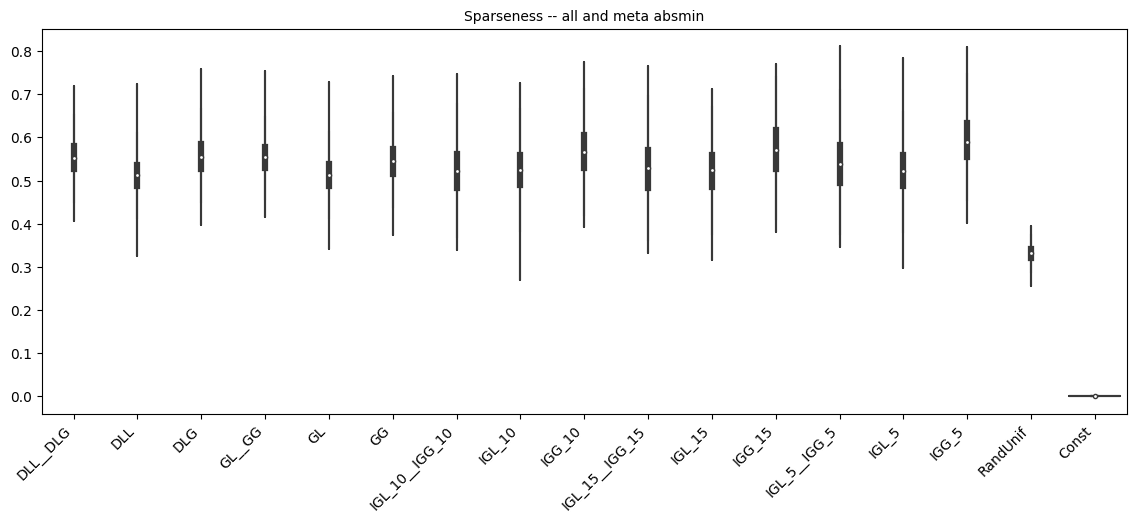

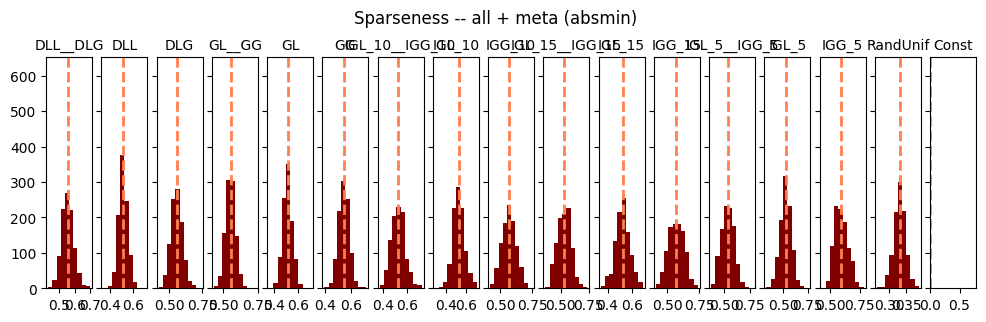

In [152]:
sp_all = {}
for metric_name, combs in combinations.items():
  _sparseness = {k: [sparseness(i) for i in v] for k, v in all_default.items()}
  _custom_attr_sparseness = {k: [sparseness(i) for i in v] for k, v in custom_attr.items()}
  _sparseness.update(_custom_attr_sparseness)
  _sparseness_comb = {k: [sparseness(i) for i in v] for k, v in combs.items()}
  _sparseness_comb.update(_sparseness)
  create_heatmap(
      get_stats_df(_sparseness_comb)[meta_local_global_custom_order].round(3), figsize=(15, 5), triang=False, title= f"Sparseness -- all + meta ({metric_name})",
      annot=True, path=compl_path, filename=f"sparseness_all_meta_{metric_name}"
  )
  _sparseness_comb_df = pd.DataFrame(_sparseness_comb)[meta_local_global_custom_order].rename(columns=columns_mapping_short).rename(columns=custom_mapping_short)
  create_violin_plot(_sparseness_comb_df, figsize=(14, 5), title=f"Sparseness -- all and meta {metric_name}", filename=f"sparseness_all_meta_{metric_name}", path=compl_path)
  create_multiple_histograms_from_df(
      _sparseness_comb_df, figsize=(16, 5), nrows=1, ncols=len(_sparseness_comb_df.columns),
      title=f"Sparseness -- all + meta ({metric_name})", title_y=1.04,
      filename=f"sparseness_all_meta_{metric_name}", path=compl_path, sub_font=10)
  sp_all[metric_name] = _sparseness_comb

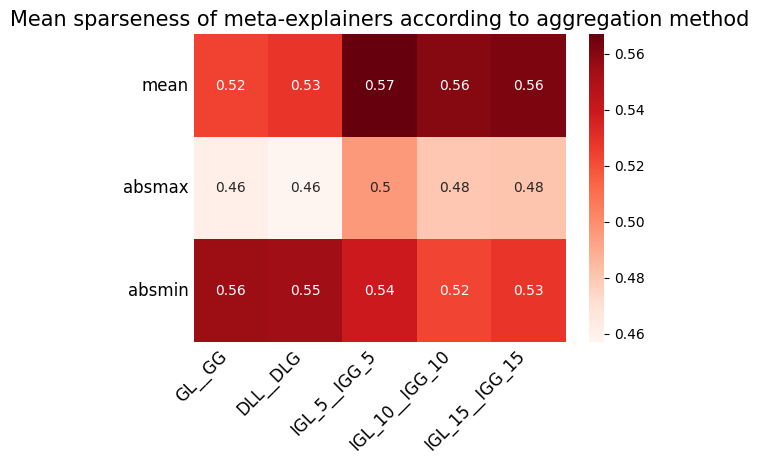

In [153]:
_df = pd.concat([get_stats_df(v)[combinations[metric_name].keys()].rename(columns=columns_mapping_short).loc["mean", :].rename(metric_name).to_frame().T for metric_name, v in sp_all.items()])
create_heatmap(_df, annot=True, figsize=(6, 4), title="Mean sparseness of meta-explainers according to aggregation method", filename="sparseness_meta_mean", path=compl_path)

### Faithfulness metrics

#### Faithfulness correlation

##### Utils

In [154]:
inter_path = Path('/content/drive/MyDrive/analysis/bert_imdb/model_20230912/20230916/inter')
f_path = figures_path / "faithfulness"

In [155]:
def create_barplot(data, figsize, x, y, hue, palette, title=None, filename=None, path=figures_path):
  fig, ax = plt.subplots(figsize=figsize)
  plt.rc('font', size=12)
  sns.barplot(ax=ax, data=data, x=x, y=y, hue=hue, palette=palette)
  ax.set_xlabel(x, fontsize=10)
  ax.set_ylabel(y, fontsize=10)
  ax.set_title(title)
  save_plot(path=path, filename=filename, suffix="bar", title=title)

In [156]:
def create_fc_plots(f_corr, aggr_func_name, random_subset_sizes, abs=False, path=figures_path):
  for random_subset_size in random_subset_sizes:
    _df = pd.concat([pd.DataFrame(f_corr[random_subset_size][n_samples]).aggregate(aggr_func_name).to_frame()\
                     .rename(columns={0:n_samples}).T.rename(columns=columns_mapping_short) for n_samples in [10, 20, 50]]).unstack()
    _df = _df.reset_index()
    fc_col = f"{aggr_func_name.capitalize()} (abs) FC" if abs else f"{aggr_func_name.capitalize()} FC"
    _df.columns = ["Explainer name", "N of samples", fc_col]
    title = f"{aggr_func_name} absolute faithfulness correlation, random subset size: {random_subset_size}"
    title = title.replace("absolute ", "").capitalize() if not abs else title.capitalize()
    palette_fc_ns = {50: "maroon", 20: "brown", 10: "lightcoral"}
    create_barplot(_df, figsize=(12, 4), x="Explainer name", y=fc_col, hue="N of samples",
                palette=palette_fc_ns, title=title, filename=f"{aggr_func_name}_abs_fc_{random_subset_size}",
                   path=path)

##### Calculation

In [157]:
combination_mappings = {
  metric_name: reverse_order_nested_dict(
    {
      explainer_name: get_id_to_exp_mapping(exp_list) for explainer_name, exp_list in combs.items()
    }
  ) for metric_name, combs in combinations.items()
}

In [158]:
inter_fc_path = analysis_path / "inter_fc"
inter_fc_path.mkdir(exist_ok=True, parents=True)

In [159]:
# regular FC
# for random_subset_size in [1, 2, 3]:
#   for n_samples in [10, 20, 50]:
#     start_time = time()
#     a, p, c = faithfulness_correlation(all_default_mapping, explainer_names=explainers_regular, random_subset_size=random_subset_size, n_samples=n_samples)
#     a = {k: {i: [str(s) for s in j] for i, j in v.items()} for k, v in a.items()}
#     with open(inter_fc_path / f"fc_all_regular_rs_{random_subset_size}_ns_{n_samples}.json", "w") as f:
#       json.dump([a, p, c], f)
#     end_time = time()
#     print(f"random_subset_size: {random_subset_size}, n_samples: {n_samples}")
#     print(end_time - start_time)

In [160]:
# # regular FC abs
# for random_subset_size in [1, 2, 3]:
#   for n_samples in [10, 20, 50]:
#     start_time = time()
#     with open(inter_fc_path / f"fc_all_regular_rs_{random_subset_size}_ns_{n_samples}.json", "r") as f:
#       a, p, c = json.load(f)
#     p = {int(k): v for k, v in p.items()}
#     a, p, c = faithfulness_correlation_precalculated_preds(
#         all_default_mapping, explainer_names=explainers_regular, random_subset_size=random_subset_size, n_samples=n_samples, abs=True, pred_diffs=p)
#     a = {k: {i: [str(s) for s in j] for i, j in v.items()} for k, v in a.items()}
#     p = {k: v.tolist() for k, v in p.items()}
#     with open(inter_fc_path / f"fc_abs_all_regular_rs_{random_subset_size}_ns_{n_samples}.json", "w") as f:
#       json.dump([a, p, c], f)
#     end_time = time()
#     print(f"random_subset_size: {random_subset_size}, n_samples: {n_samples}")
#     print(end_time - start_time)

In [161]:
# # meta FC
# for metric_name, _combinations in combination_mappings.items():
#   explainer_names = list(_combinations.keys())
#   for random_subset_size in [1, 2, 3]:
#     for n_samples in [10, 20, 50]:
#       start_time = time()
#       with open(inter_fc_path / f"fc_all_regular_rs_{random_subset_size}_ns_{n_samples}.json", "r") as f:
#         a, p, c = json.load(f)
#       p = {int(k): v for k, v in p.items()}
#       a, p, c = faithfulness_correlation_precalculated_preds(_combinations, explainer_names=explainer_names, random_subset_size=random_subset_size, n_samples=n_samples, pred_diffs=p)
#       a = {k: {i: [str(s) for s in j] for i, j in v.items()} for k, v in a.items()}
#       with open(inter_fc_path / f"fc_meta_{metric_name}_rs_{random_subset_size}_ns_{n_samples}.json", "w") as f:
#         json.dump([a, p, c], f)
#       end_time = time()
#       print(f"random_subset_size: {random_subset_size}, n_samples: {n_samples}")
#       print(end_time - start_time)

In [162]:
# # meta FC abs
# for metric_name, _combinations in combination_mappings.items():
#   explainer_names = list(_combinations.keys())
#   for random_subset_size in [1, 2, 3]:
#     for n_samples in [10, 20, 50]:
#       start_time = time()
#       with open(inter_fc_path / f"fc_all_regular_rs_{random_subset_size}_ns_{n_samples}.json", "r") as f:
#         a, p, c = json.load(f)
#       p = {int(k): v for k, v in p.items()}
#       a, p, c = faithfulness_correlation_precalculated_preds(_combinations, explainer_names=explainer_names, random_subset_size=random_subset_size, n_samples=n_samples, abs=True, pred_diffs=p)
#       a = {k: {i: [str(s) for s in j] for i, j in v.items()} for k, v in a.items()}
#       p = {k: v.tolist() for k, v in p.items()}
#       with open(inter_fc_path / f"fc_abs_meta_{metric_name}_rs_{random_subset_size}_ns_{n_samples}.json", "w") as f:
#         json.dump([a, p, c], f)
#       end_time = time()
#       print(f"random_subset_size: {random_subset_size}, n_samples: {n_samples}")
#       print(end_time - start_time)

In [163]:
# # regular FC chunks
# for random_subset_size, chunk_size in tqdm([(1, 2), (1, 3), (1, 4), (2, 2), (2, 3)]):
#   for n_samples in [50]:
#     start_time = time()
#     a, p, c = faithfulness_correlation(
#         all_default_mapping, explainer_names=explainers_regular,
#         random_subset_size=random_subset_size, n_samples=n_samples, chunk_size=chunk_size
#     )
#     # a = {k: {i: [str(s) for s in j] for i, j in v.items()} for k, v in a.items()}
#     with open(inter_fc_path / f"fc_all_regular_rs_{random_subset_size}_ns_{n_samples}_chunk_size_{chunk_size}.json", "w") as f:
#       json.dump([a, p, c], f)
#     end_time = time()
#     print(f"random_subset_size: {random_subset_size}, n_samples: {n_samples}, chunk_size: {chunk_size}")
#     print(end_time - start_time)

In [164]:
# # regular FC abs chunks
# for random_subset_size, chunk_size in tqdm([(1, 2), (1, 3), (1, 4), (2, 2), (2, 3)]):
#   for n_samples in [50]:
#     start_time = time()
#     with open(inter_fc_path / f"fc_all_regular_rs_{random_subset_size}_ns_{n_samples}_chunk_size_{chunk_size}.json", "r") as f:
#         a, p, c = json.load(f)
#     p = {int(k): v for k, v in p.items()}
#     a, p, c = faithfulness_correlation_precalculated_preds(
#         all_default_mapping, explainer_names=explainers_regular
#         random_subset_size=random_subset_size, n_samples=n_samples, chunk_size=chunk_size, abs=True, pred_diffs=p
#     )
#     # a = {k: {i: [str(s) for s in j] for i, j in v.items()} for k, v in a.items()}
#     with open(inter_fc_path / f"fc_abs_all_regular_rs_{random_subset_size}_ns_{n_samples}_chunk_size_{chunk_size}.json", "w") as f:
#       json.dump([a, p, c], f)
#     end_time = time()
#     print(f"random_subset_size: {random_subset_size}, n_samples: {n_samples}, chunk_size: {chunk_size}")
#     print(end_time - start_time)

In [165]:
# # meta FC chunks
# for metric_name, _combinations in combination_mappings.items():
#   explainer_names = list(_combinations.keys())
#   for random_subset_size, chunk_size in tqdm([(1, 2), (1, 3), (1, 4), (2, 2), (2, 3)]):
#     for n_samples in [50]:
#       start_time = time()
#       with open(inter_fc_path / f"fc_all_regular_rs_{random_subset_size}_ns_{n_samples}_chunk_size_{chunk_size}.json", "r") as f:
#         a, p, c = json.load(f)
#       p = {int(k): v for k, v in p.items()}
#       a, p, c = faithfulness_correlation_precalculated_preds(
#           _combinations, explainer_names=explainers_regular
#           random_subset_size=random_subset_size, n_samples=n_samples, chunk_size=chunk_size, pred_diffs=p
#       )
#       # a = {k: {i: [str(s) for s in j] for i, j in v.items()} for k, v in a.items()}
#       with open(inter_fc_path / f"fc_meta_{metric_name}_rs_{random_subset_size}_ns_{n_samples}_chunk_size_{chunk_size}.json", "w") as f:
#         json.dump([a, p, c], f)
#       end_time = time()
#       print(f"random_subset_size: {random_subset_size}, n_samples: {n_samples}, chunk_size: {chunk_size}")
#       print(end_time - start_time)

In [166]:
# # meta FC abs chunks
# for metric_name, _combinations in combination_mappings.items():
#   explainer_names = list(_combinations.keys())
#   for random_subset_size, chunk_size in tqdm([(1, 2), (1, 3), (1, 4), (2, 2), (2, 3)]):
#     for n_samples in [50]:
#       start_time = time()
#       with open(inter_fc_path / f"fc_all_regular_rs_{random_subset_size}_ns_{n_samples}_chunk_size_{chunk_size}.json", "r") as f:
#         a, p, c = json.load(f)
#       p = {int(k): v for k, v in p.items()}
#       a, p, c = faithfulness_correlation_precalculated_preds(
#           _combinations, explainer_names=explainers_regular
#           random_subset_size=random_subset_size, n_samples=n_samples, chunk_size=chunk_size, abs=True, pred_diffs=p
#       )
#       # a = {k: {i: [str(s) for s in j] for i, j in v.items()} for k, v in a.items()}
#       with open(inter_fc_path / f"fc_abs_meta_{metric_name}_rs_{random_subset_size}_ns_{n_samples}_chunk_size_{chunk_size}.json", "w") as f:
#         json.dump([a, p, c], f)
#       end_time = time()
#       print(f"random_subset_size: {random_subset_size}, n_samples: {n_samples}, chunk_size: {chunk_size}")
#       print(end_time - start_time)

##### Read data

In [168]:
def read_all_fc_data(prefix, subsets, samples, chunks=False, path=inter_fc_path):
  f_corr = {k: defaultdict(dict) for k in ["attr", "pred", "fc"]}
  for subset in subsets:
    for n_samples in samples:
      if chunks:
        filename = f"{prefix}_rs_{subset[0]}_ns_{n_samples}_chunk_size_{subset[1]}.json"
      else:
        filename = f"{prefix}_rs_{subset}_ns_{n_samples}.json"
      with open(path / filename, "r") as f:
        a, p, c = json.load(f)
      f_corr["fc"][subset][n_samples] = reverse_order_nested_dict(c)
      f_corr["attr"][subset][n_samples] = reverse_order_nested_dict(a)
      f_corr["pred"][subset][n_samples] = p
  return f_corr

In [169]:
def read_fc_data(prefix, subsets, samples, chunks=False, path=inter_fc_path):
  f_corr = defaultdict(dict)
  for subset in subsets:
    for n_samples in samples:
      if chunks:
        filename = f"{prefix}_rs_{subset[0]}_ns_{n_samples}_chunk_size_{subset[1]}.json"
      else:
        filename = f"{prefix}_rs_{subset}_ns_{n_samples}.json"
      with open(path / filename, "r") as f:
        a, p, c = json.load(f)
      f_corr[subset][n_samples] = reverse_order_nested_dict(c)
  return f_corr

In [170]:
f_corr_all = read_all_fc_data(prefix="fc_all_regular", subsets=[1, 2, 3], samples=[10, 20, 50])
f_corr_all_abs = read_all_fc_data(prefix="fc_abs_all_regular", subsets=[1, 2, 3], samples=[10, 20, 50])

In [171]:
f_corr = read_fc_data(prefix="fc_all_regular", subsets=[1, 2, 3], samples=[10, 20, 50])
f_corr_abs = read_fc_data(prefix="fc_abs_all_regular", subsets=[1, 2, 3], samples=[10, 20, 50])

f_corr_meta = {metric_name: read_fc_data(prefix=f"fc_meta_{metric_name}", subsets=[1, 2, 3], samples=[10, 20, 50]) for metric_name in combination_mappings.keys()}
f_corr_meta_abs = {metric_name: read_fc_data(prefix=f"fc_abs_meta_{metric_name}", subsets=[1, 2, 3], samples=[10, 20, 50]) for metric_name in combination_mappings.keys()}

In [172]:
f_corr_chunks = read_fc_data(prefix="fc_all_regular", subsets=[(1, 2), (1, 3), (1, 4), (2, 2), (2, 3)], samples=[50], chunks=True)
f_corr_abs_chunks = read_fc_data(prefix="fc_abs_all_regular", subsets=[(1, 2), (1, 3), (1, 4), (2, 2), (2, 3)], samples=[50], chunks=True)

f_corr_meta_chunks = {
  metric_name: read_fc_data(
    prefix=f"fc_meta_{metric_name}", subsets=[(1, 2), (1, 3), (1, 4), (2, 2), (2, 3)], samples=[50], chunks=True
  ) for metric_name in combination_mappings.keys()}
f_corr_meta_abs_chunks = {
  metric_name: read_fc_data(
    prefix=f"fc_abs_meta_{metric_name}", subsets=[(1, 2), (1, 3), (1, 4), (2, 2), (2, 3)], samples=[50], chunks=True
  ) for metric_name in combination_mappings.keys()}

##### Visualization

In [173]:
def create_fc_histograms(f_corr, filename_prefix="fc", title_prefix="Faithfulness correlation", path=f_path):
  for subset, v in f_corr.items():
    for n_samples, vv in v.items():
      if type(subset) == tuple:
        subset, chunk_size = subset
      else:
        chunk_size = 1
      create_multiple_histograms_from_df(
          pd.DataFrame(vv).rename(columns=columns_mapping_short), nrows=1, ncols=len(list(vv.keys())),
          figsize=(10, 5), title_y=1.04, filename = f"{filename_prefix}_rs_{subset}_ns_{n_samples}_cs_{chunk_size}",
          title=f"{title_prefix}, n random: {subset}, chunk size: {chunk_size}, n of samples: {n_samples}", path=path
      )

In [174]:
def create_fc_dist_heatmaps(f_corr, filename_prefix="fc", title_prefix="Faithfulness correlation", path=f_path):
  for subset, v in f_corr.items():
    for n_samples, vv in v.items():
      if type(subset) == tuple:
        subset, chunk_size = subset
      else:
        chunk_size = 1
      create_heatmap(
          get_stats_df(vv).rename(columns=columns_mapping_short), figsize=(10, 4), annot=True,
          title=f"{title_prefix}, n random: {subset}, chunk size: {chunk_size}, n of samples: {n_samples}",
          filename = f"{filename_prefix}_rs_{subset}_ns_{n_samples}_cs_{chunk_size}", path=path)

In [175]:
def create_fc_violin_plots(f_corr, filename_prefix="fc", title_prefix="Faithfulness correlation", path=f_path):
  for subset, v in f_corr.items():
    for n_samples, vv in v.items():
      if type(subset) == tuple:
        subset, chunk_size = subset
      else:
        chunk_size = 1
      create_violin_plot(pd.DataFrame(vv).rename(columns=columns_mapping_short), figsize=(8, 4),
                         title=f"{title_prefix}, n random: {subset}, chunk size: {chunk_size}, n of samples: {n_samples}",
                         filename = f"{filename_prefix}_rs_{subset}_ns_{n_samples}_cs_{chunk_size}", path=path)

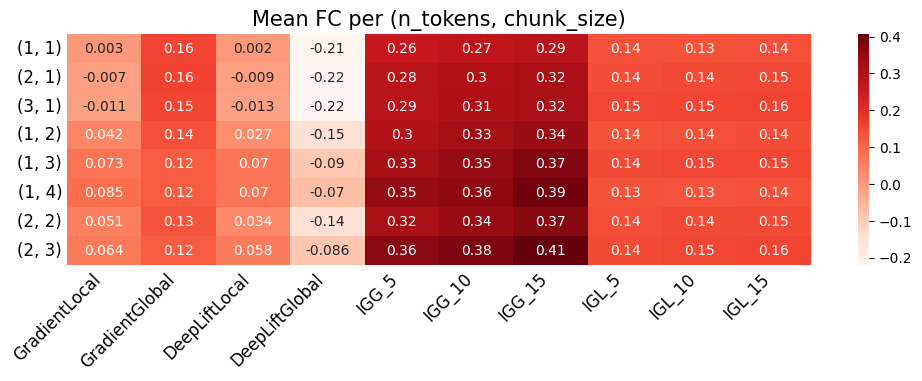

In [176]:
dfs1 = [pd.DataFrame(f_corr[i][50]).mean().to_frame().T for i in [1, 2, 3]]
dfs2 = [pd.DataFrame(f_corr_chunks[i][50]).mean().to_frame().T for i in [(1, 2), (1, 3), (1, 4), (2, 2), (2, 3)]]
df = pd.concat(dfs1 + dfs2)
df.index = [(1, 1), (2, 1), (3, 1)] + [(1, 2), (1, 3), (1, 4), (2, 2), (2, 3)]
create_heatmap(df, annot=True, title="Mean FC per (n_tokens, chunk_size)", filename="mean_fc_n_tokens_chunk", path=f_path)

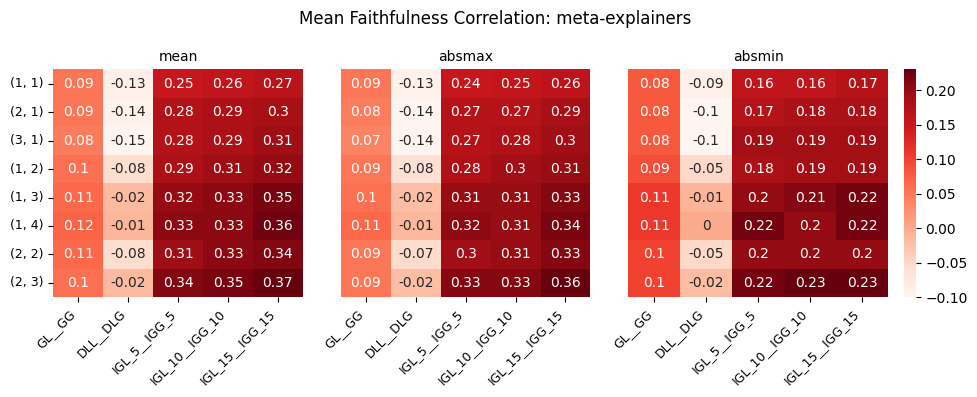

In [177]:
fig, axes = plt.subplots(1, 3, figsize=(10, 4), gridspec_kw={'width_ratios': [1, 1, 1.3]})
for i, metric_name in enumerate(f_corr_meta.keys()):
  dfs1 = [pd.DataFrame(f_corr_meta[metric_name][i][50]).mean().to_frame().T for i in [1, 2, 3]]
  dfs2 = [pd.DataFrame(f_corr_meta_chunks[metric_name][i][50]).mean().to_frame().T for i in [(1, 2), (1, 3), (1, 4), (2, 2), (2, 3)]]
  df = pd.concat(dfs1 + dfs2).round(2)
  df.index = [(1, 1), (2, 1), (3, 1)] + [(1, 2), (1, 3), (1, 4), (2, 2), (2, 3)]
  # create_heatmap(df, annot=True, figsize=(6, 4), title=f"Mean FC: meta explainers ({metric_name})", filename=f"mean_fc_n_tokens_chunk_meta_{metric_name}", path=f_path)
  cbar=True if i==2 else False
  sns.heatmap(df, ax=axes[i], annot=True, cmap=default_heatmap_cmap, cbar=cbar)
  axes[i].set_title(f"{metric_name}")
  x_ticks = list(np.arange(0.5, len(df.columns), 1))
  axes[i].set_xticks(x_ticks, df.columns, rotation=45, ha='right', fontsize=9)
  if i==0:
    y_ticks = list(np.arange(0.5, len(df.index), 1))
    axes[i].set_yticks(y_ticks, df.index, rotation=0, ha='right', fontsize=9)
  else:
    axes[i].set_yticks([])
fig.suptitle("Mean Faithfulness Correlation: meta-explainers")
plt.tight_layout()
save_plot(filename="mean_fc_n_tokens_chunk_meta", suffix="heatmap", path=f_path, title=None)

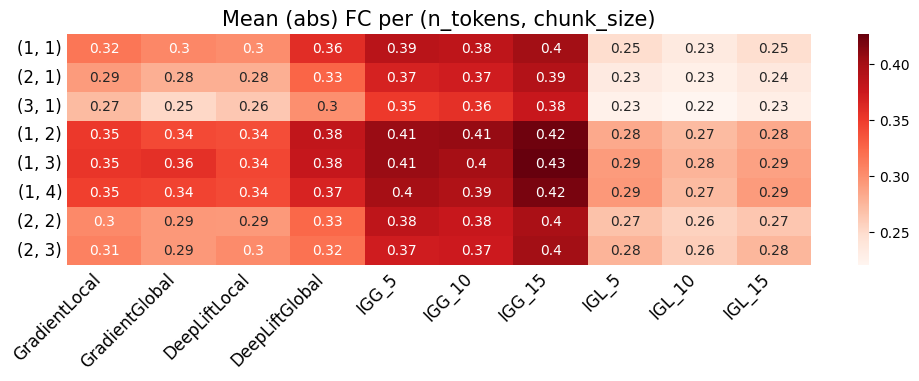

In [178]:
dfs1 = [pd.DataFrame(f_corr_abs[i][50]).mean().to_frame().T for i in [1, 2, 3]]
dfs2 = [pd.DataFrame(f_corr_abs_chunks[i][50]).mean().to_frame().T for i in [(1, 2), (1, 3), (1, 4), (2, 2), (2, 3)]]
df = pd.concat(dfs1 + dfs2)
df.index = [(1, 1), (2, 1), (3, 1)] + [(1, 2), (1, 3), (1, 4), (2, 2), (2, 3)]
create_heatmap(df, annot=True, title="Mean (abs) FC per (n_tokens, chunk_size)", filename="mean_abs_fc_n_tokens_chunk", path=f_path)

In [179]:
# create_fc_violin_plots(f_corr, filename_prefix="fc", title_prefix="Faithfulness correlation")
# create_fc_violin_plots(f_corr_chunks, filename_prefix="fc_chunks", title_prefix="Faithfulness correlation")

In [180]:
# for metric_name in combination_mappings.keys():
#   create_fc_violin_plots(f_corr_meta[metric_name], filename_prefix=f"fc_meta_{metric_name}", title_prefix=f"Faithfulness correlation meta-explainers ({metric_name})")
#   create_fc_violin_plots(f_corr_meta_chunks[metric_name], filename_prefix=f"fc_meta_{metric_name}_chunks", title_prefix=f"Faithfulness correlation meta-explainers ({metric_name})")

In [181]:
# create_fc_dist_heatmaps(f_corr, filename_prefix="fc", title_prefix="Faithfulness correlation")
# create_fc_dist_heatmaps(f_corr_chunks, filename_prefix="fc_chunks", title_prefix="Faithfulness correlation")

In [182]:
# for metric_name in combination_mappings.keys():
#   create_fc_dist_heatmaps(f_corr_meta[metric_name], filename_prefix=f"fc_meta_{metric_name}", title_prefix="Faithfulness correlation meta-explainers")
#   create_fc_dist_heatmaps(f_corr_meta_chunks[metric_name], filename_prefix=f"fc_meta_{metric_name}_chunks", title_prefix="Faithfulness correlation meta-explainers")

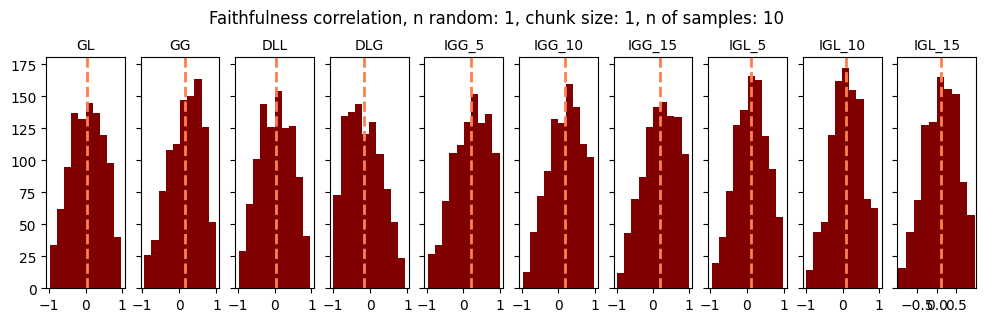

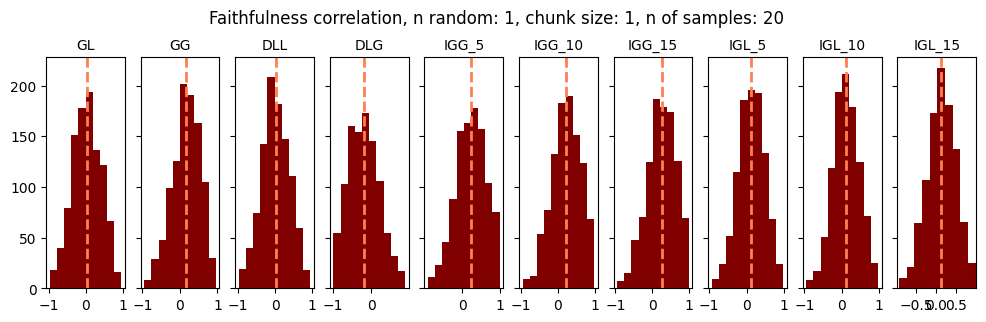

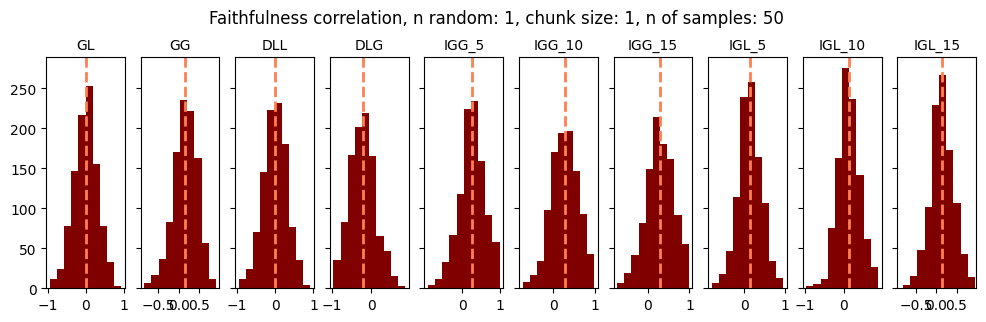

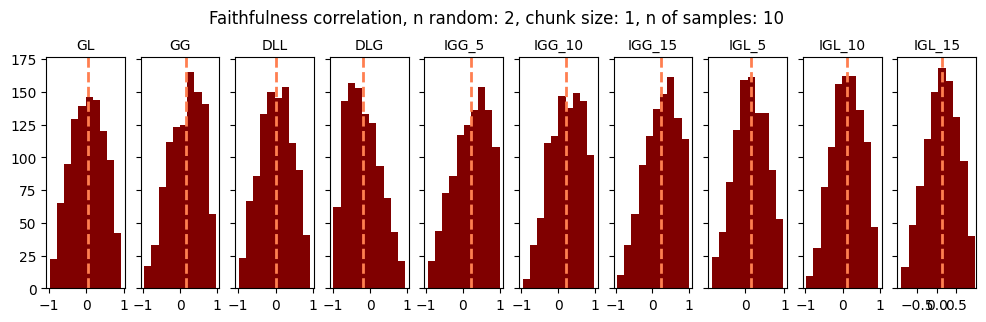

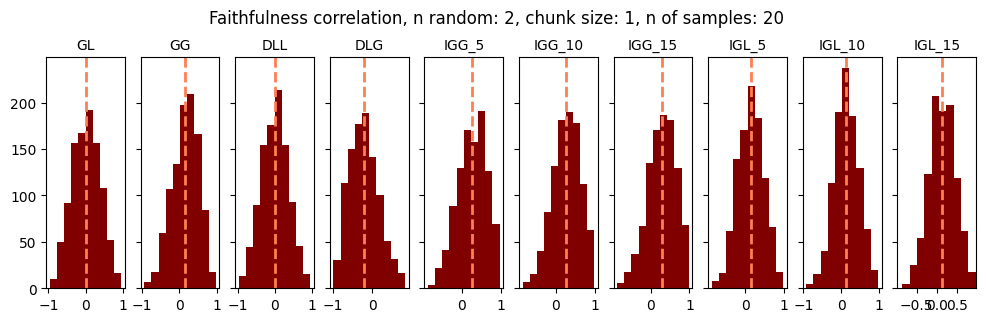

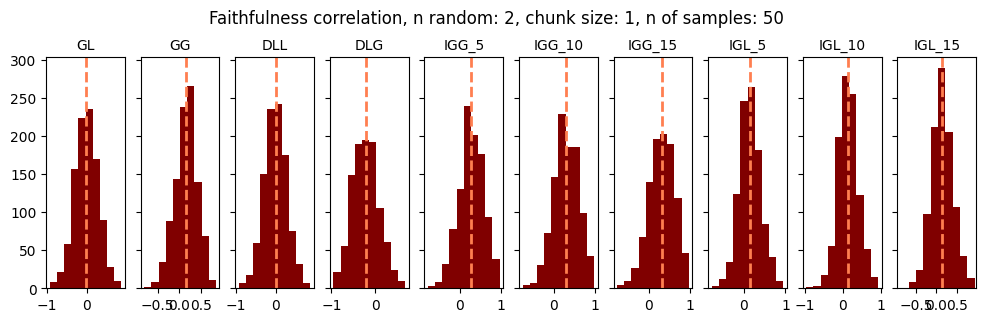

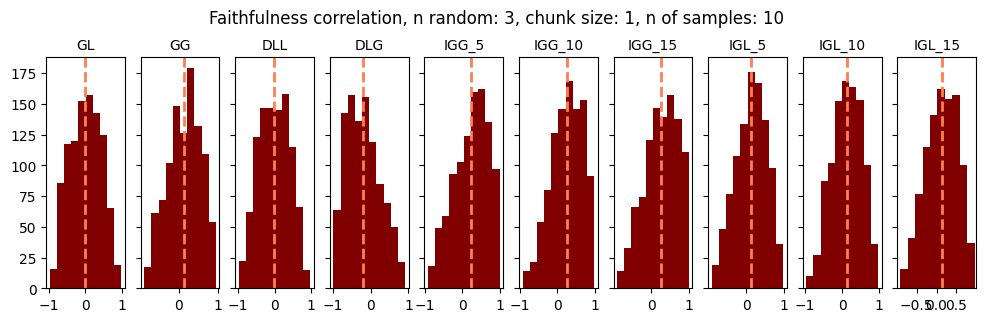

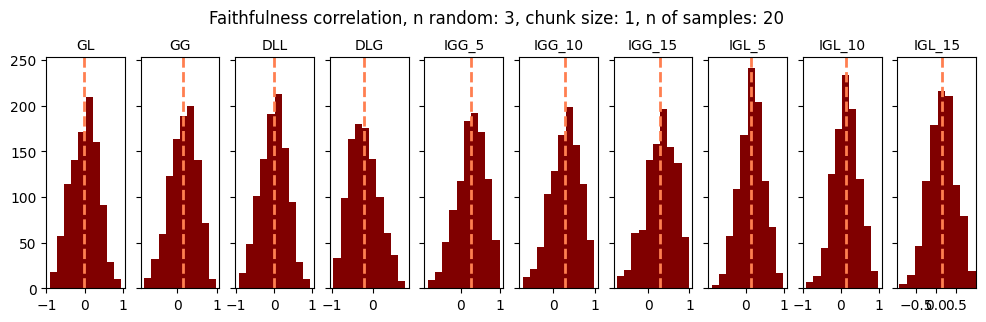

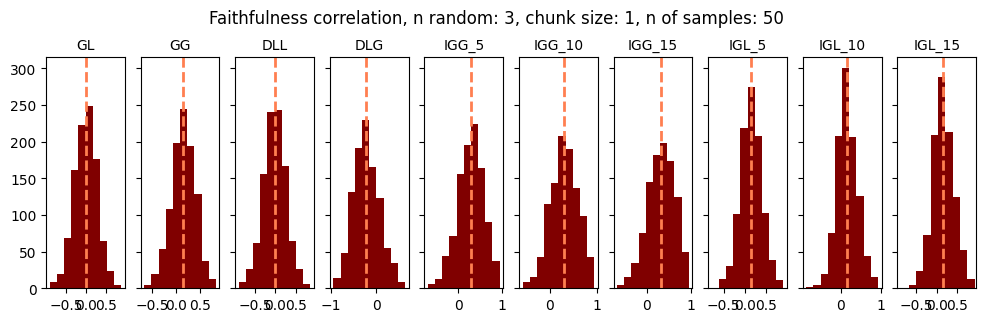

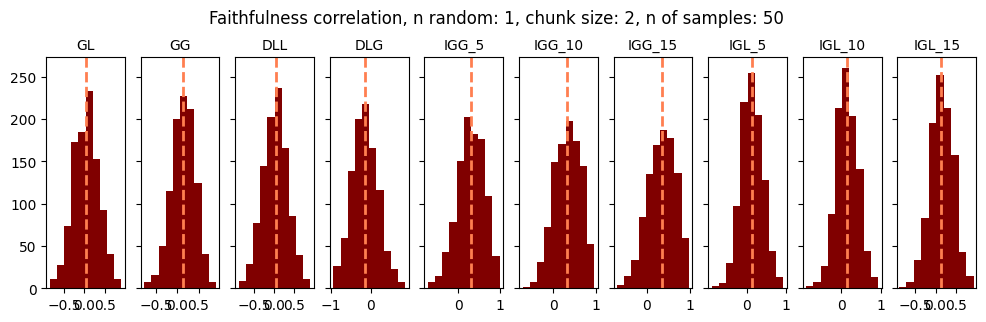

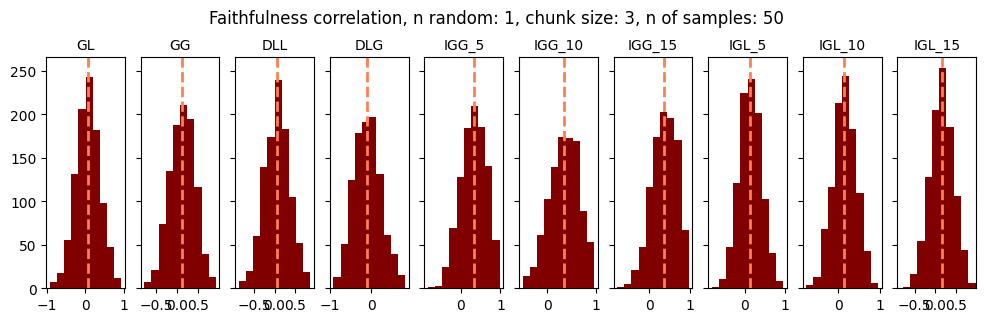

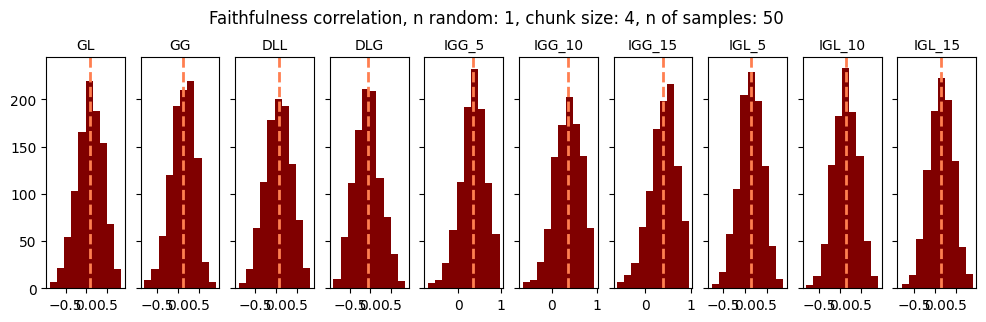

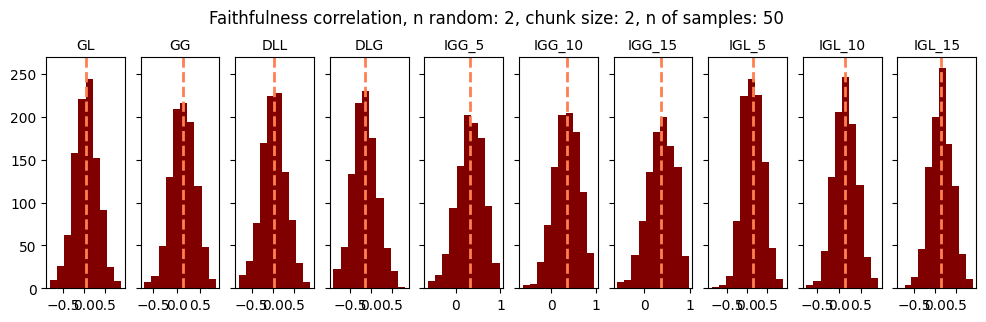

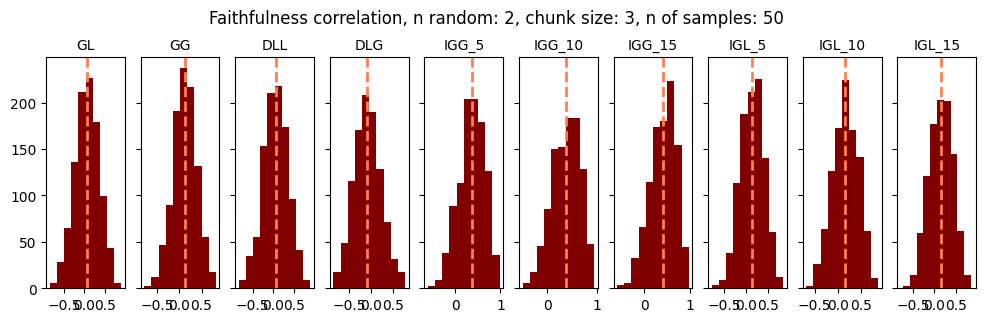

In [183]:
create_fc_histograms(f_corr, filename_prefix="fc", title_prefix="Faithfulness correlation")
create_fc_histograms(f_corr_chunks, filename_prefix="fc_chunks", title_prefix="Faithfulness correlation")

<ipython-input-105-3d640cb685b3>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 3), sharey='row')


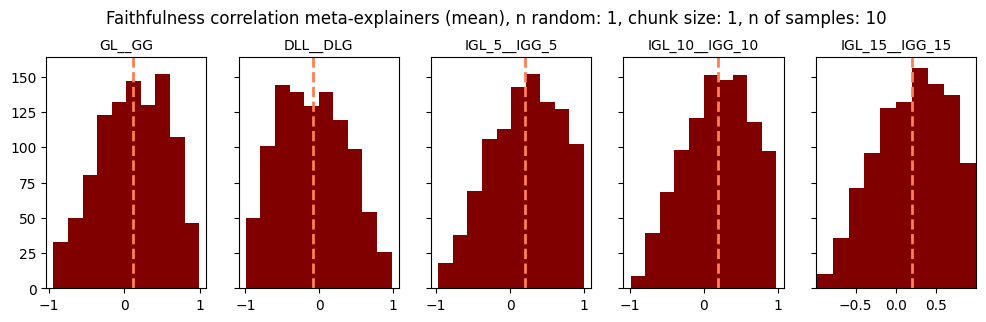

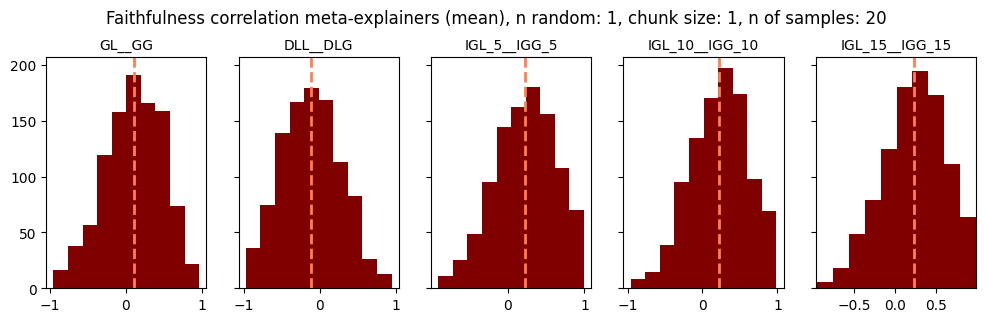

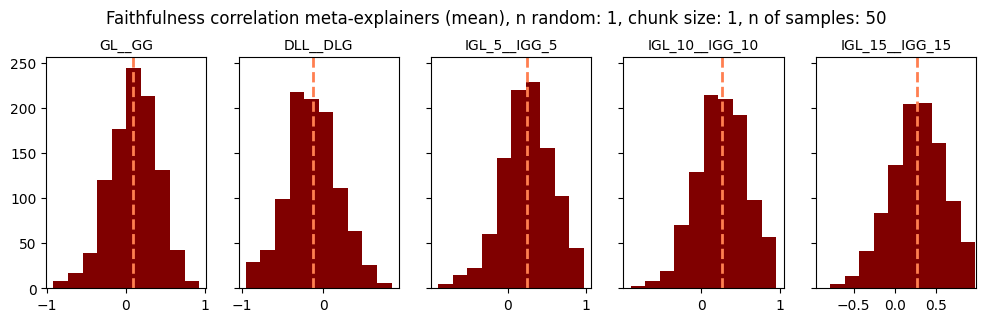

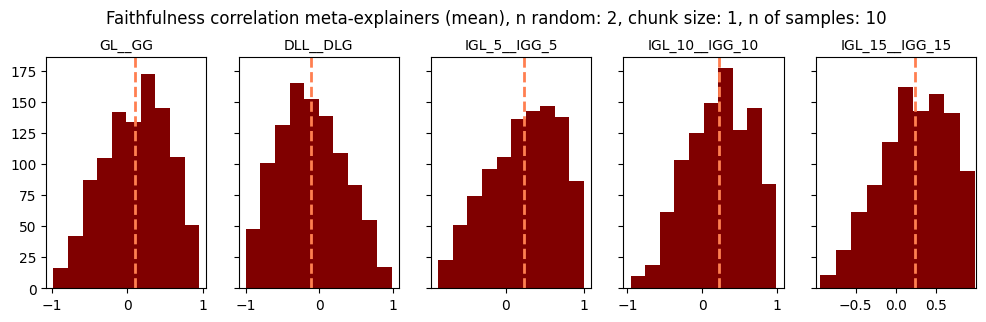

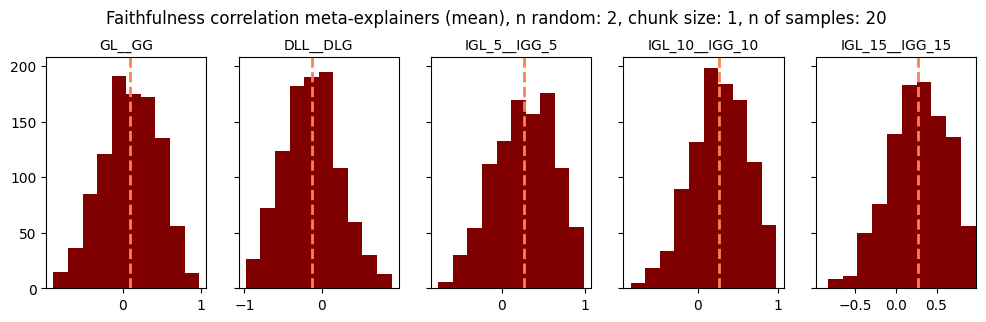

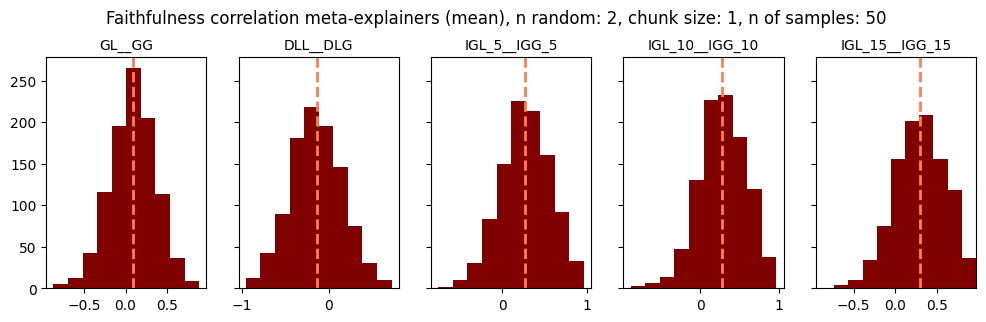

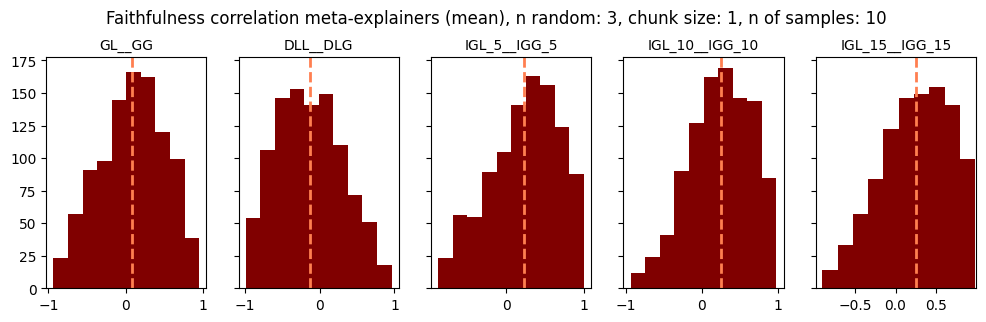

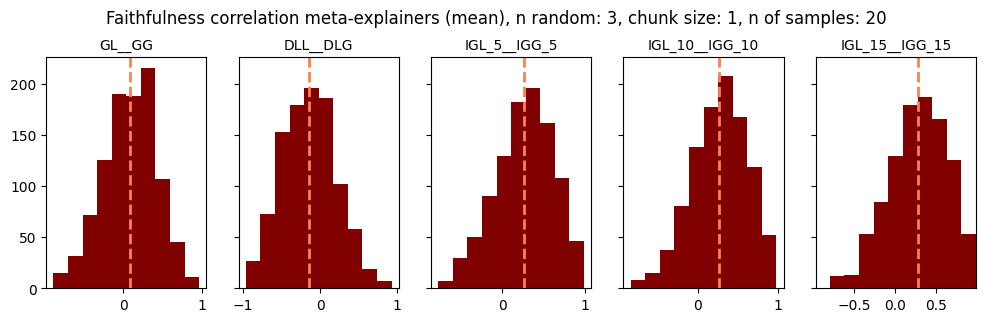

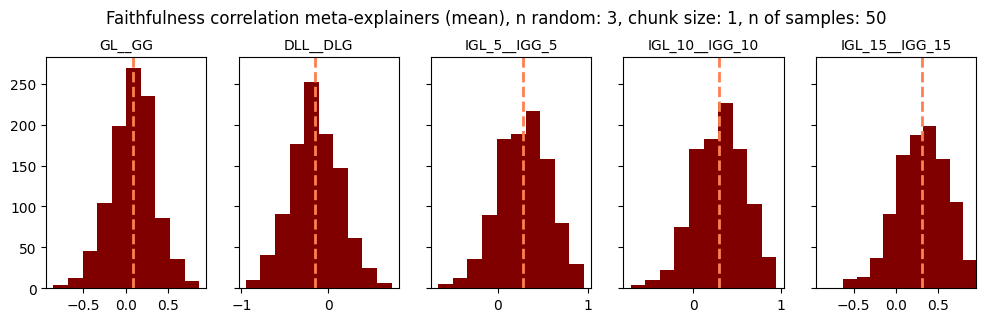

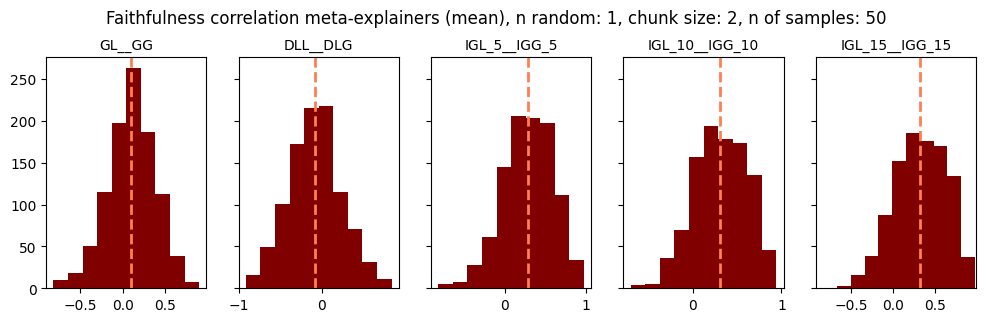

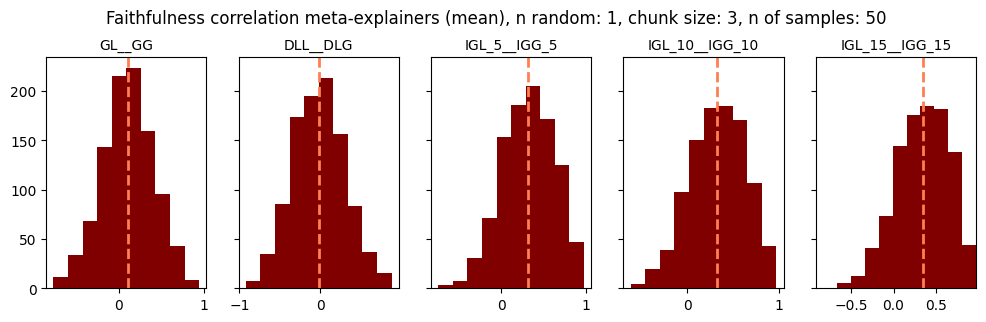

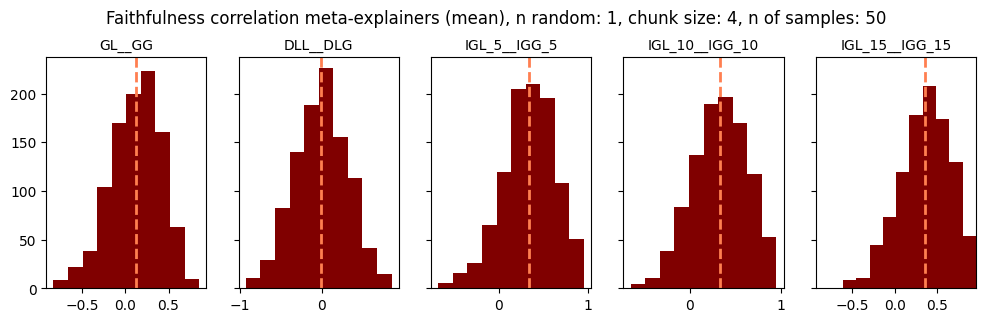

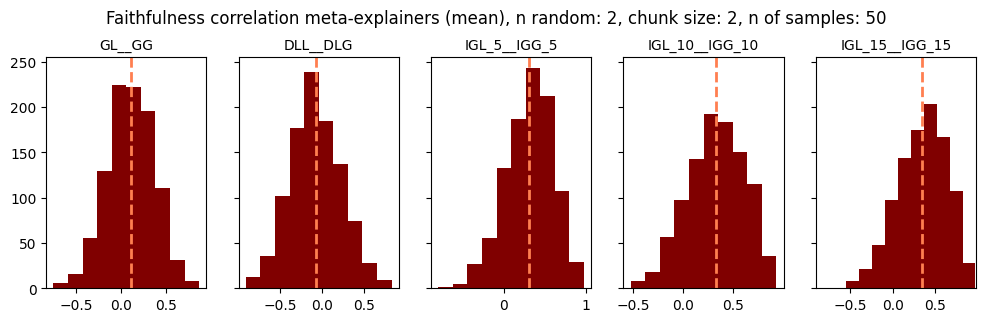

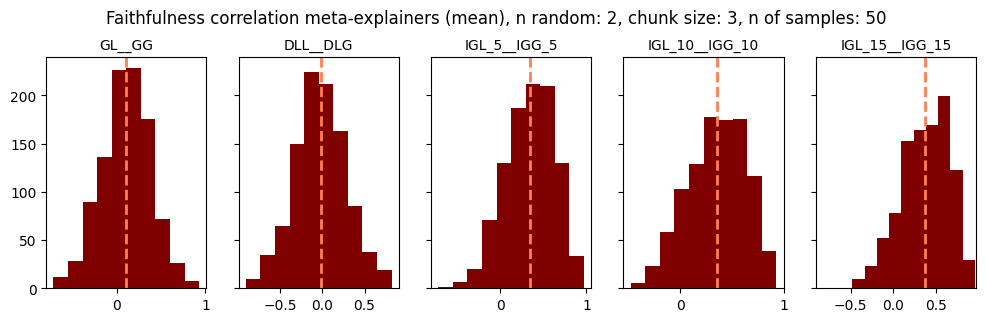

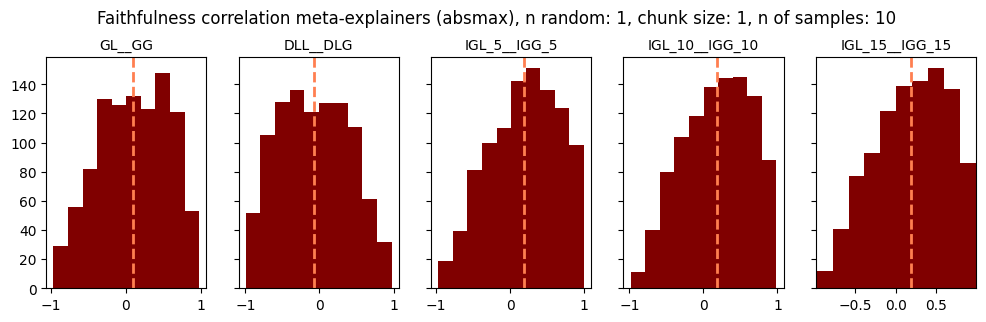

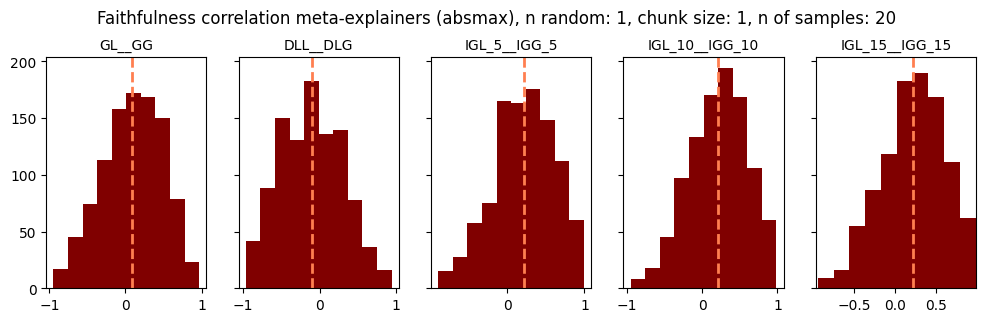

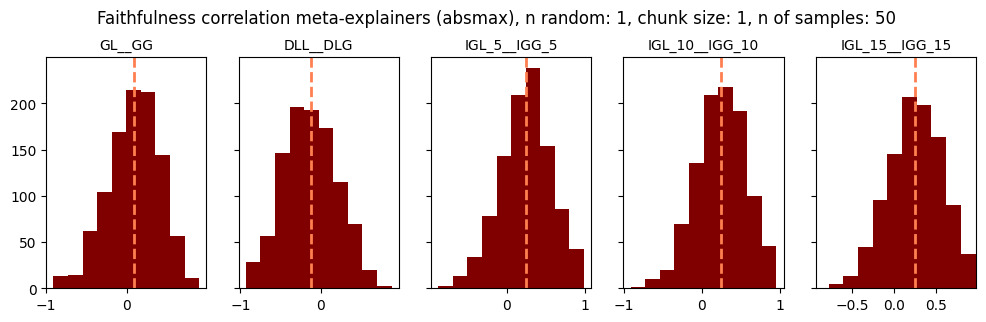

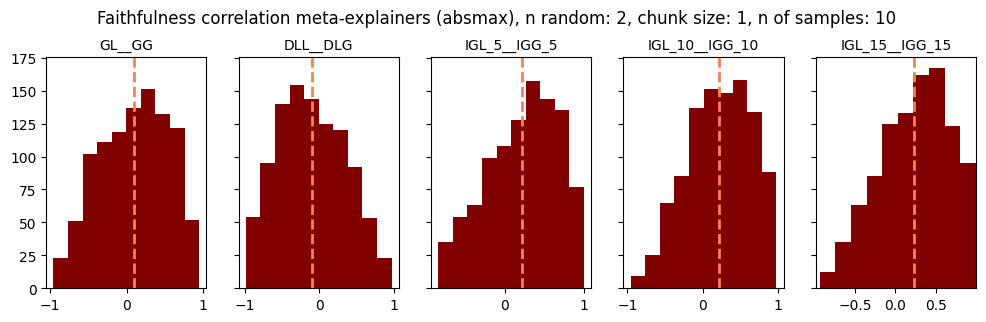

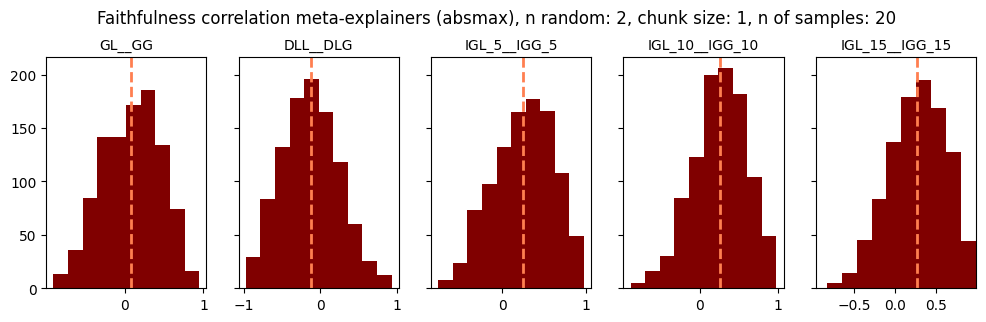

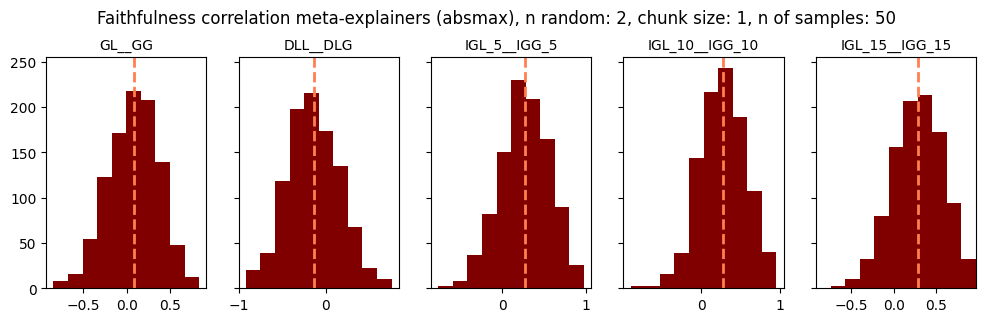

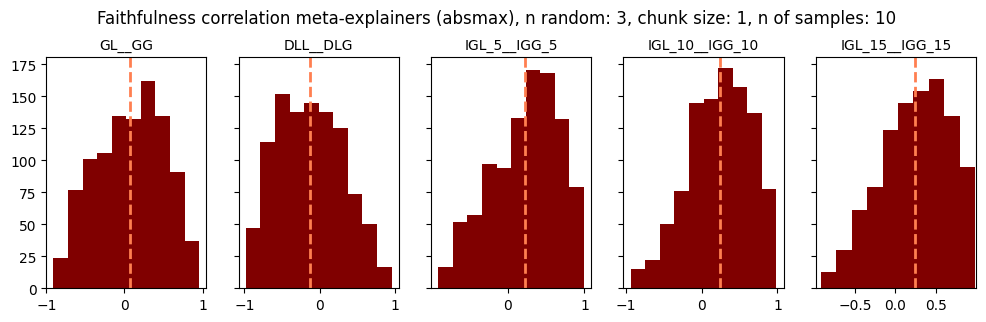

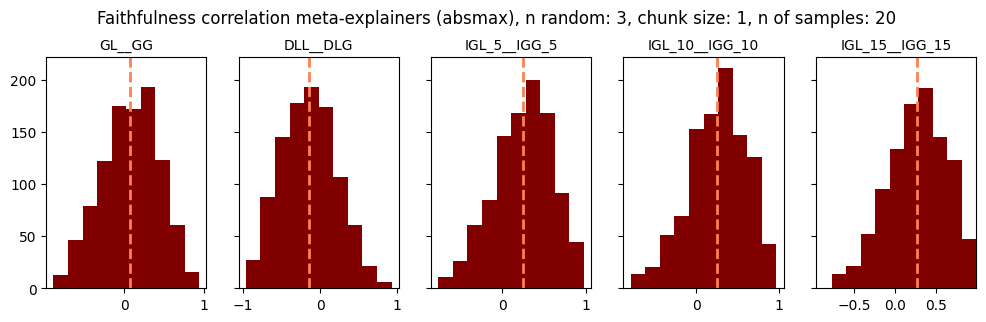

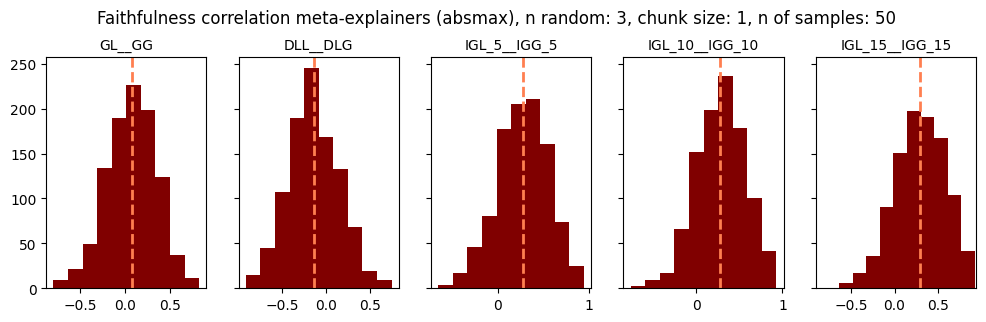

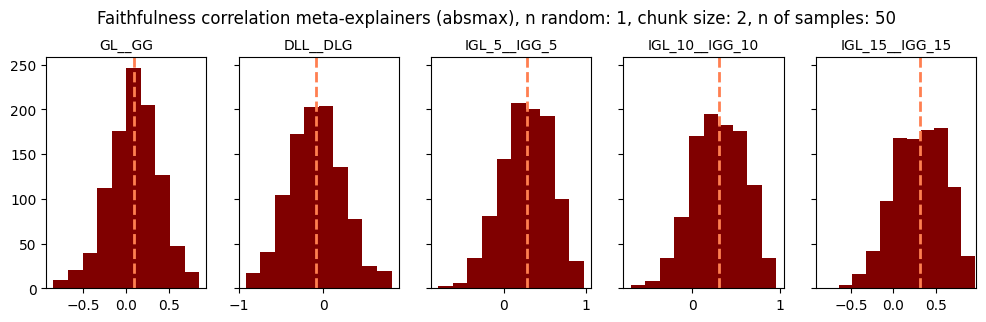

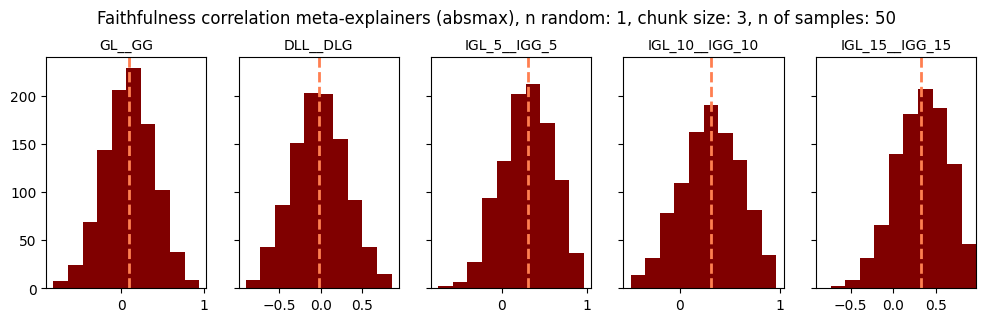

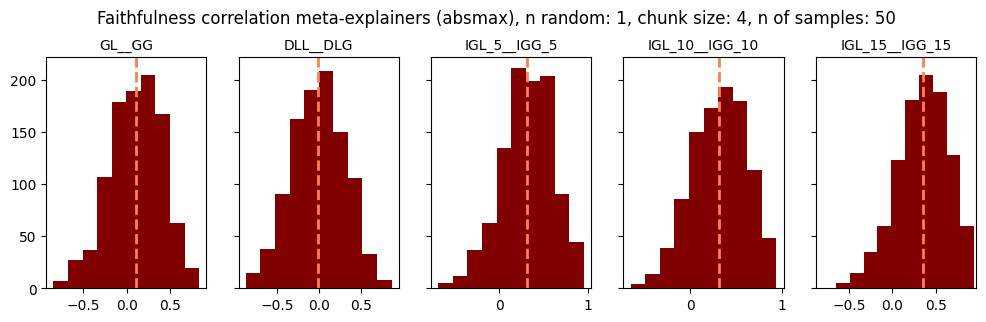

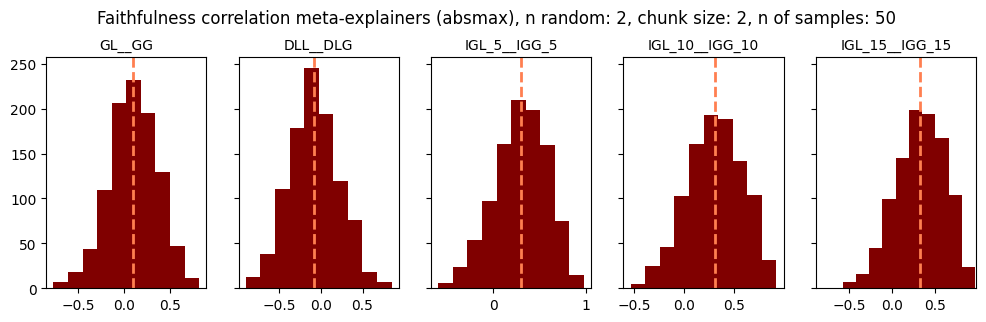

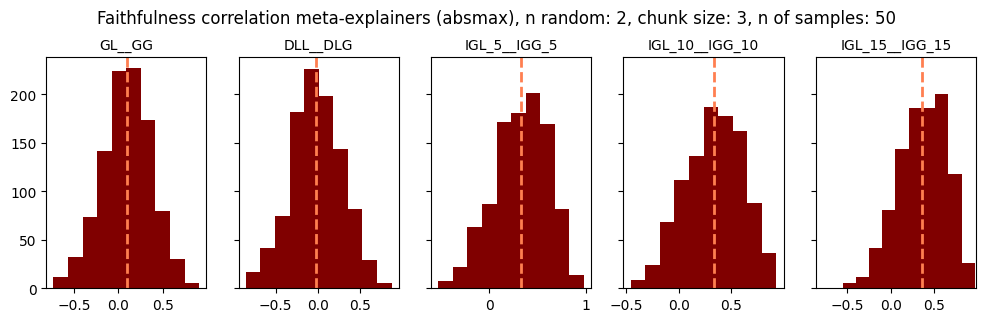

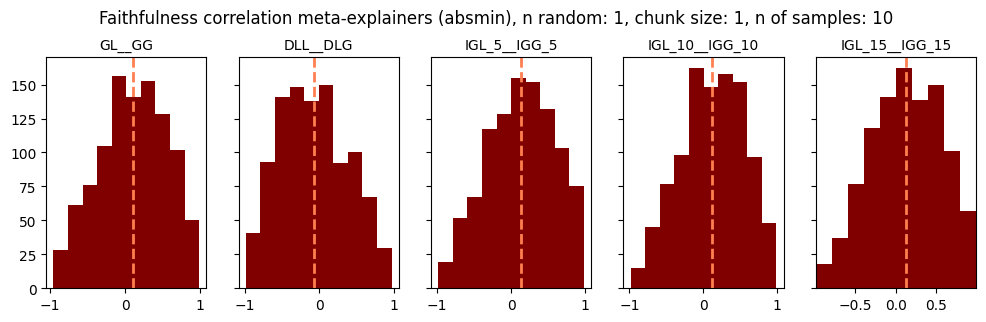

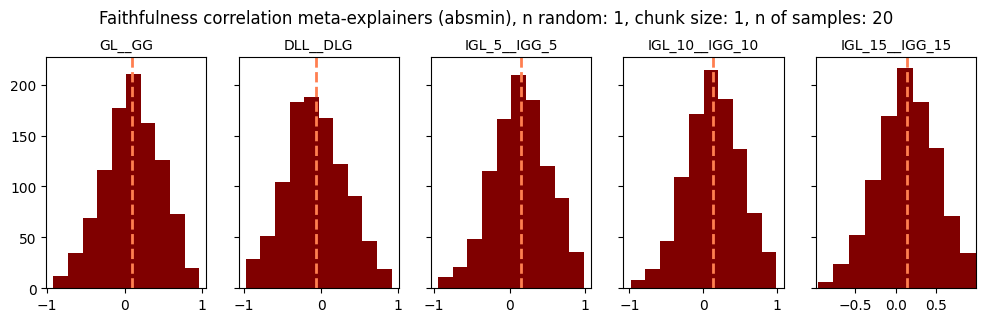

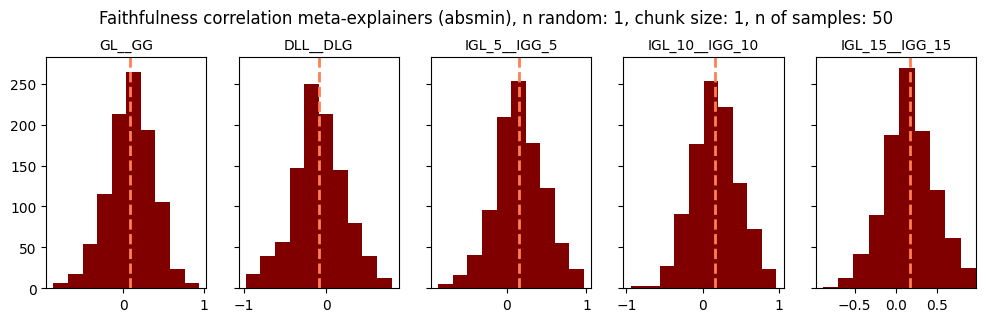

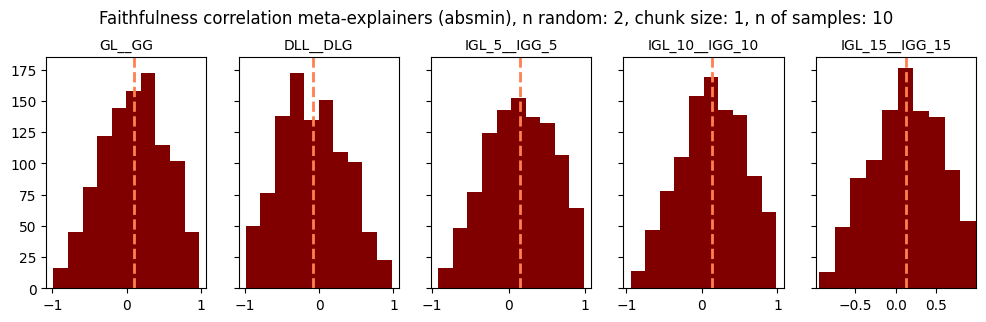

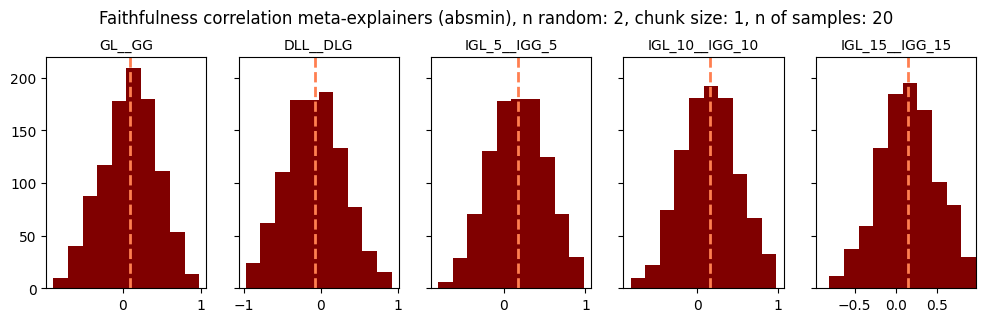

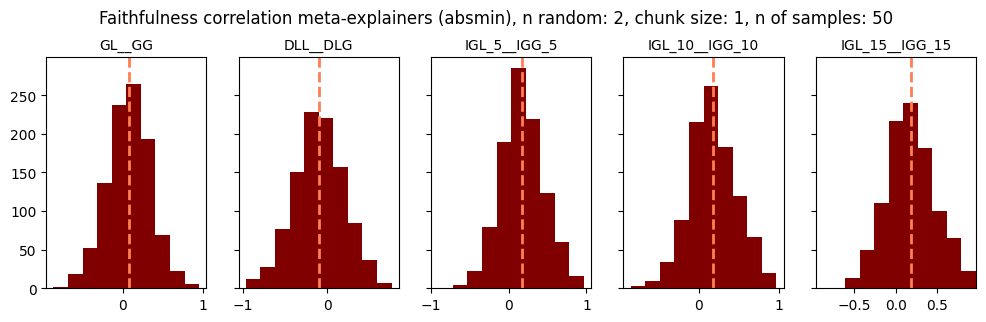

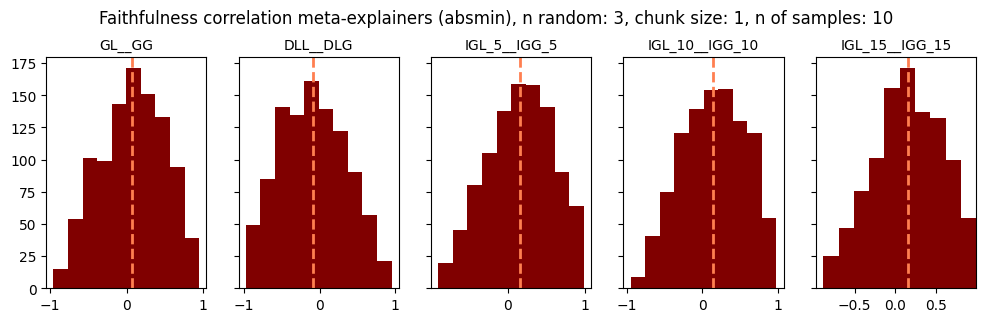

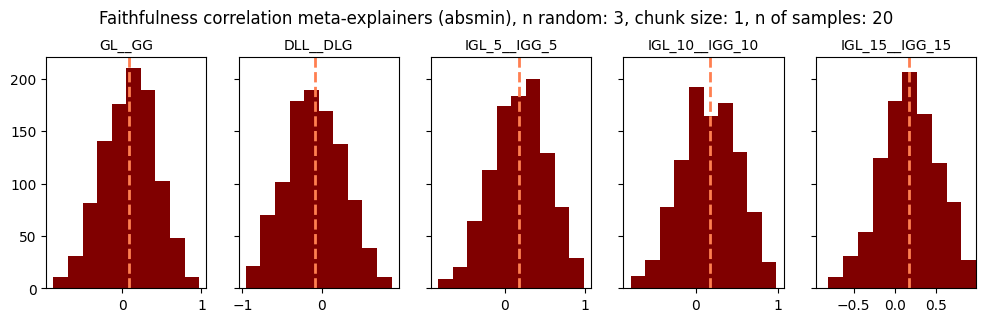

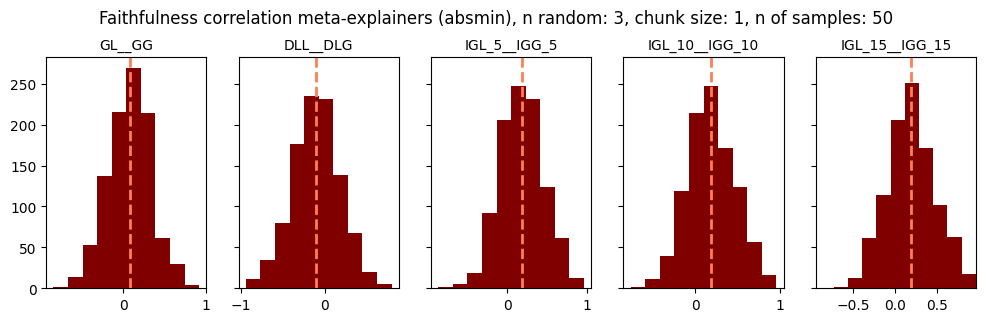

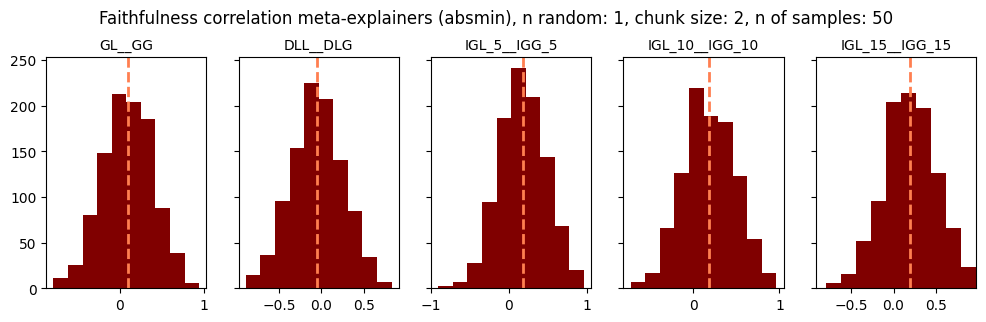

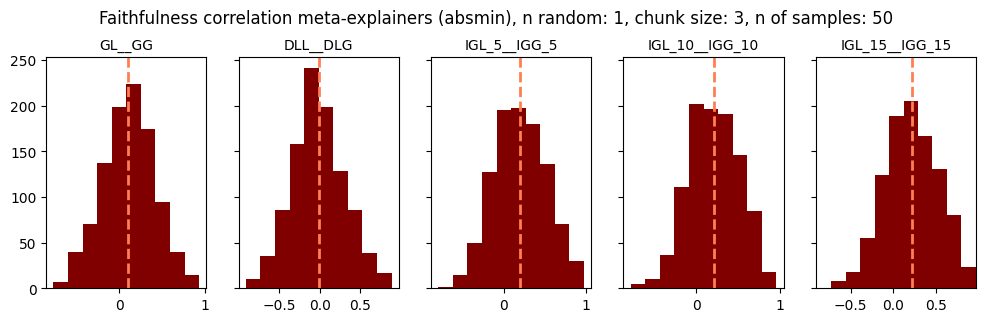

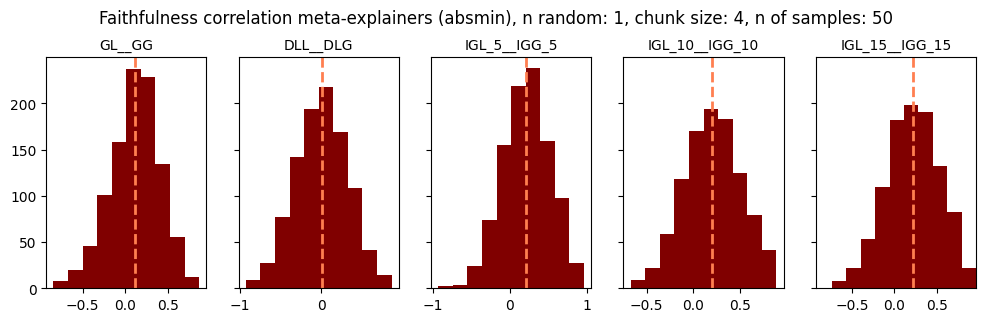

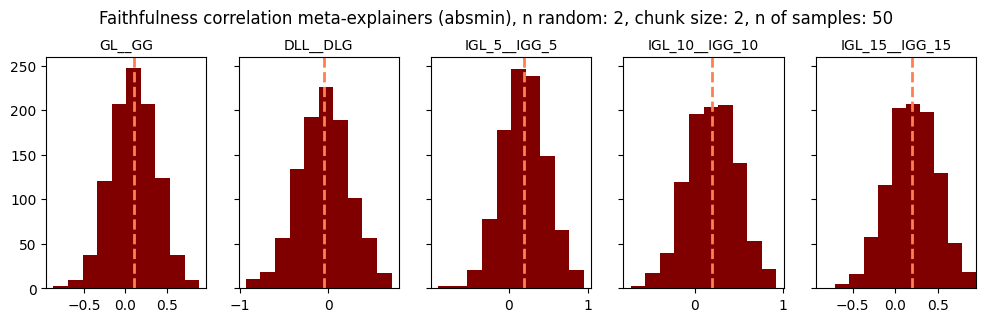

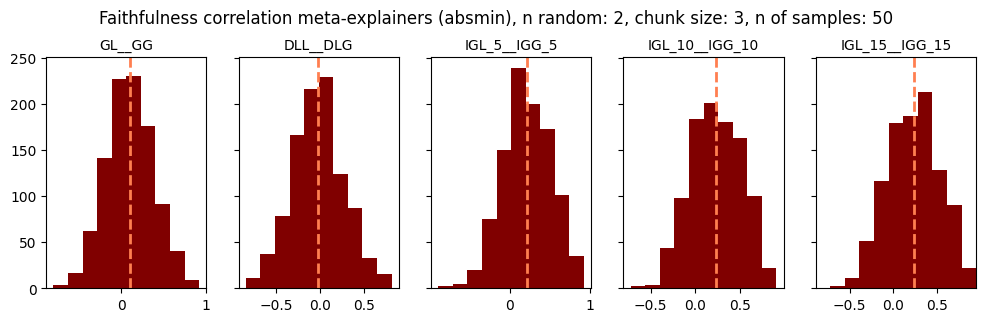

In [184]:
for metric_name in combination_mappings.keys():
  create_fc_histograms(f_corr_meta[metric_name], filename_prefix=f"fc_meta_{metric_name}", title_prefix=f"Faithfulness correlation meta-explainers ({metric_name})")
  create_fc_histograms(f_corr_meta_chunks[metric_name], filename_prefix=f"fc_meta_{metric_name}_chunks", title_prefix=f"Faithfulness correlation meta-explainers ({metric_name})")

#### Selectivity

In [185]:
def get_all_selectivity_results(all_recurrent_sorted_with_originals, selectivity_func, **kwargs):
  return {
    explainer_name: {
        text_id: selectivity_func(
            sorted_exps,
            **kwargs
          ) for text_id, sorted_exps in sorted_exps_by_text_id.items()
      }
    for explainer_name, sorted_exps_by_text_id in all_recurrent_sorted_with_originals.items() if len(sorted_exps_by_text_id) > 0
}

##### Calculation

In [187]:
selectivity_results_og = get_all_selectivity_results(all_recurrent_sorted_with_originals, selectivity_func=selectivity_og, use_label="true", inverse=True)
_df_og = pd.DataFrame(selectivity_results_og)

In [188]:
selectivity_results_abs_diff_first = get_all_selectivity_results(all_recurrent_sorted_with_originals, selectivity_func=selectivity, output_metric=lambda x: np.abs(x[1]-x[0]), use_label=True)
_df_abs_first_diff = pd.DataFrame(selectivity_results_abs_diff_first)

In [189]:
selectivity_results_abs_diff_auc = get_all_selectivity_results(
    all_recurrent_sorted_with_originals,
    selectivity_func=selectivity,
    output_metric=lambda x: get_auc(sorted(np.abs(np.diff(x))), 1/len(sorted(np.abs(np.diff(x))))),
    use_label=True
)
_df_abs_diff_auc = pd.DataFrame(selectivity_results_abs_diff_auc)

In [190]:
selectivity_results_diff_std = get_all_selectivity_results(
    all_recurrent_sorted_with_originals,
    selectivity_func=selectivity,
    output_metric=lambda x: np.std(np.diff(x)),
    use_label=True
    )
_df_diff_std = pd.DataFrame(selectivity_results_diff_std)

In [191]:
selectivity_results_max_abs_diff = get_all_selectivity_results(
    all_recurrent_sorted_with_originals,
    selectivity_func=selectivity,
    output_metric=lambda x: np.max(np.abs(np.diff(x))),
    use_label=True
    )
_df_max_abs_diff = pd.DataFrame(selectivity_results_max_abs_diff)

In [192]:
short_mapping = {
  'original': 'original',
 'abs_first_diff': 'AFD',
 'abs_diff_auc': 'AD-AUC',
 'diff_std': 'D-STD',
 'max_abs_diff': 'MAD'
 }


In [193]:
all_selectivity = {
    "original": _df_og,
    "abs_first_diff": _df_abs_first_diff,
    "abs_diff_auc": _df_abs_diff_auc,
    "diff_std": _df_diff_std,
    "max_abs_diff": _df_max_abs_diff
}
res = defaultdict(list)
for explainer_name in explainers_regular:
  for k, _df in all_selectivity.items():
    res[explainer_name].append(_df[[explainer_name]].rename(columns={explainer_name: k}).T)
final = {}
for k, v in res.items():
  final[k] = pd.concat(v).T

##### Visualization

In [196]:
suffixes_mapping = {
    "original": {
        "title_suffix": "original",
        "filename_suffix": "original"
    },
    "abs_first_diff": {
        "title_suffix": "absolute first difference",
        "filename_suffix": "abs_first_diff"
    },
    "abs_diff_auc": {
        "title_suffix": "absolute difference AUC",
        "filename_suffix": "abs_diff_auc"
    },
    "diff_std": {
        "title_suffix": "standard deviations of differences",
        "filename_suffix": "diff_std"
    },
    "max_abs_diff": {
        "title_suffix": "max absolute difference",
        "filename_suffix": "max_abs_diff"
    },
}

In [197]:
sel_path = figures_path / "selectivity"

In [198]:
def visualize_all_selectivity_results(_df, filename_suffix, title_suffix, path=sel_path):
  filename = f"selectivity_{filename_suffix}"
  title = f"Selectivity: {title_suffix}"
  # create_heatmap(_df.describe().drop("count"), figsize=(9, 4), annot=True, title=title, filename=filename, path=path)

  create_multiple_histograms_from_df(_df.rename(columns=columns_mapping_short), nrows=1, ncols=len(_df.columns), figsize=(12, 6), title_y=1.04, title=title, filename=filename, path=path)
  # create_violin_plot(_df, figsize=(12, 4), title=title, filename=filename, path=path)

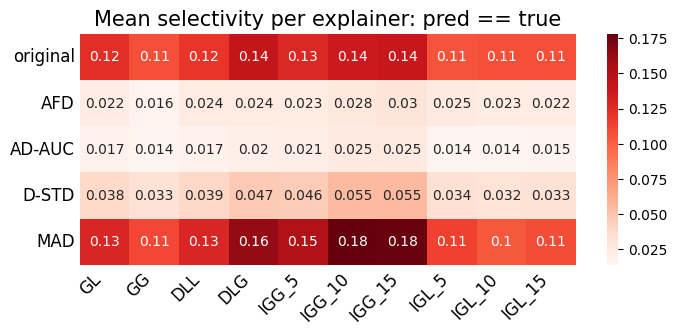

In [200]:
create_heatmap(
    pd.concat([
        pd.merge(v.rename(columns=columns_mapping_short), pred_label_equal_true_df, left_index=True, right_index=True)\
        .groupby("pred==true").mean().loc[True, :].rename(short_mapping[k]).to_frame().T
          for k, v in all_selectivity.items()]),
    annot=True, figsize=(8, 3),
    filename="mean_selectivity_pred_true_true",
    title="Mean selectivity per explainer: pred == true",
    path=sel_path
)

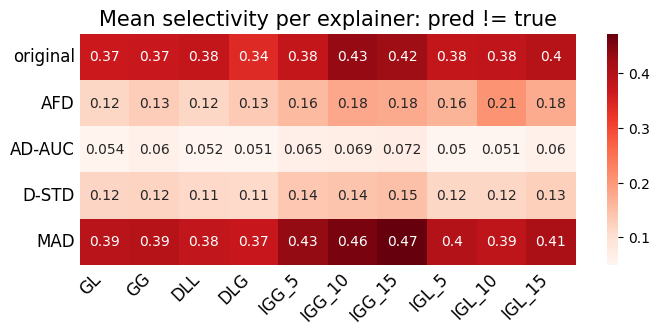

In [201]:
create_heatmap(
    pd.concat([
        pd.merge(v.rename(columns=columns_mapping_short), pred_label_equal_true_df, left_index=True, right_index=True)\
        .groupby("pred==true").mean().loc[False, :].rename(short_mapping[k]).to_frame().T
          for k, v in all_selectivity.items()]),
    annot=True, figsize=(8, 3),
    filename="mean_selectivity_pred_true_false",
    title="Mean selectivity per explainer: pred != true",
    path=sel_path
)

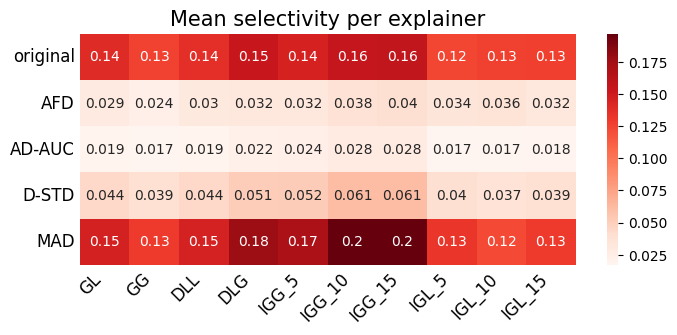

In [202]:
create_heatmap(
    pd.concat([v.rename(columns=columns_mapping_short).mean().rename(short_mapping[k]).to_frame().T for k, v in all_selectivity.items()]),
    annot=True, figsize=(8, 3),
    filename="mean_selectivity",
    title="Mean selectivity per explainer",
    path=sel_path
)

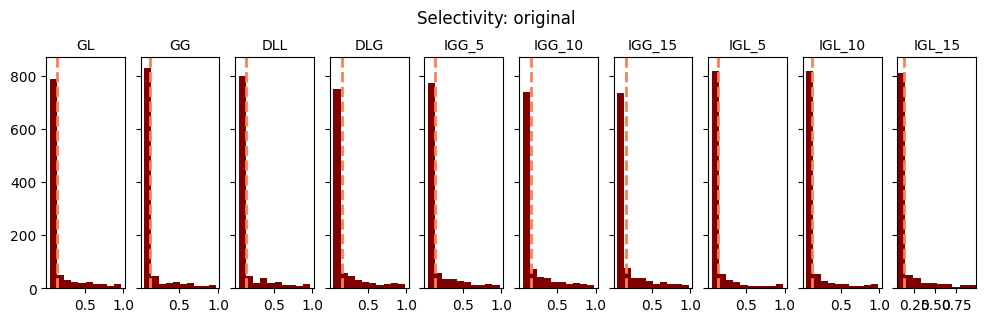

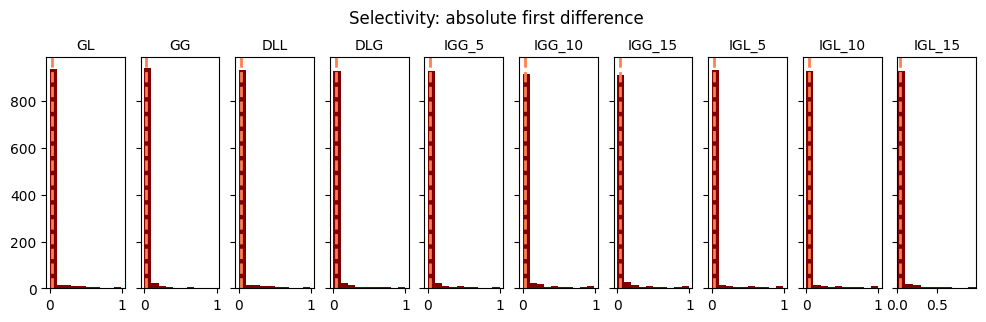

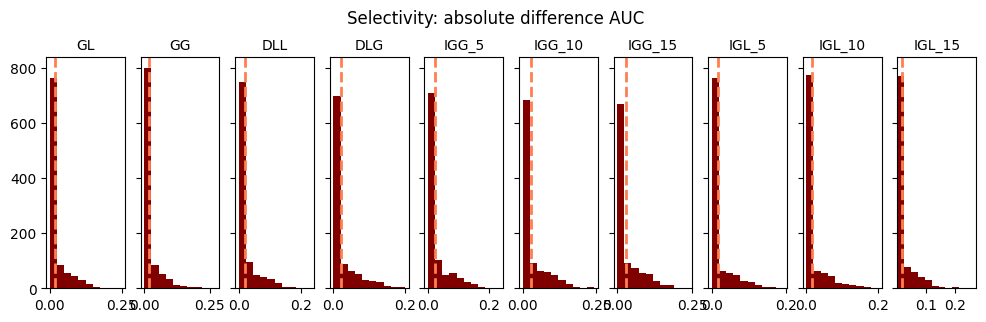

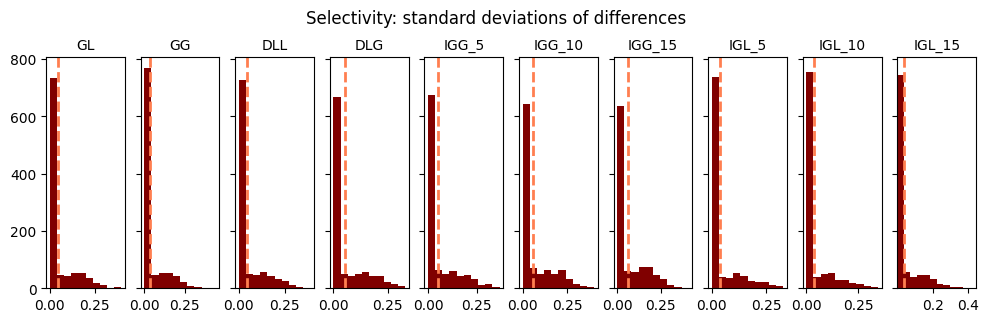

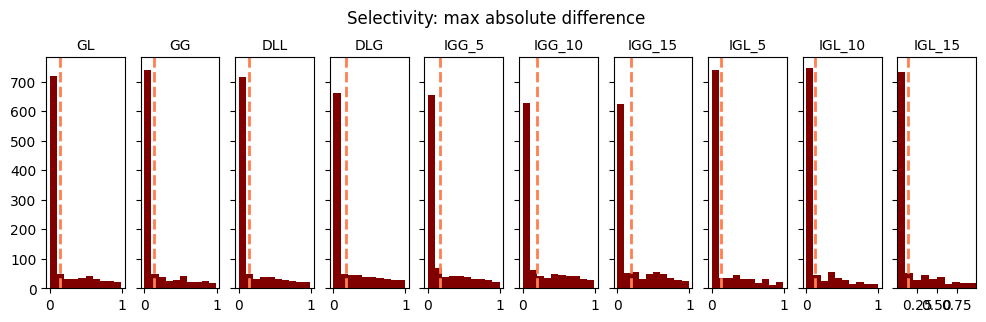

In [203]:
for k, df in all_selectivity.items():
  visualize_all_selectivity_results(df, path=figures_path / "selectivity", **suffixes_mapping[k])

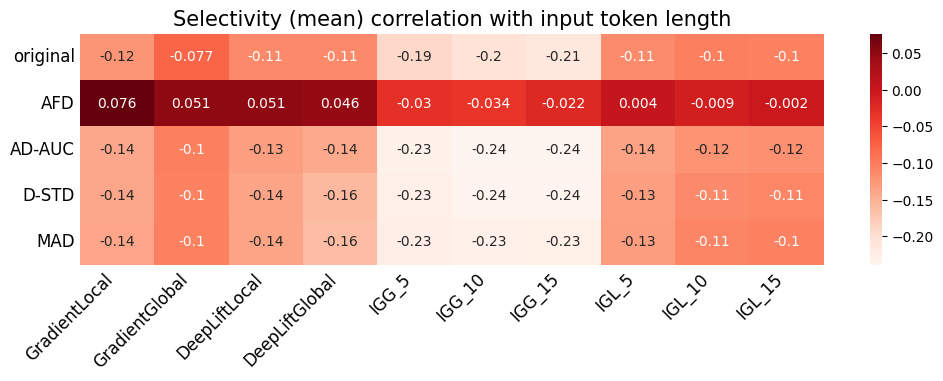

In [207]:
create_heatmap(pd.concat([
    pd.merge(_df, exp_len_df, left_index=True, right_index=True).corr("spearman").drop("Token Length")["Token Length"].rename(short_mapping[k]).to_frame().T
    for k, _df in all_selectivity.items()
]), path=figures_path / "selectivity", filename="selectivity_token_len_corr", title="Selectivity (mean) correlation with input token length", annot=True)

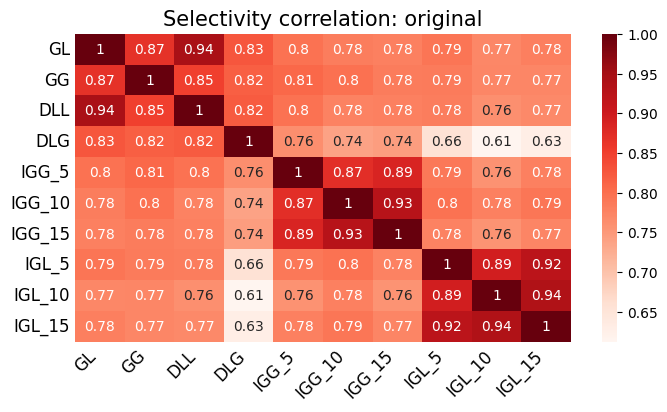

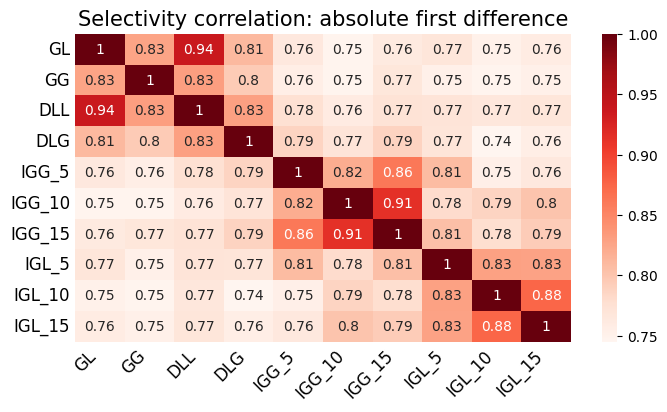

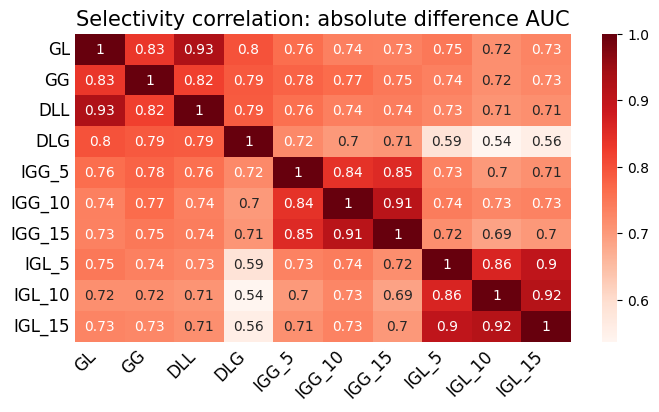

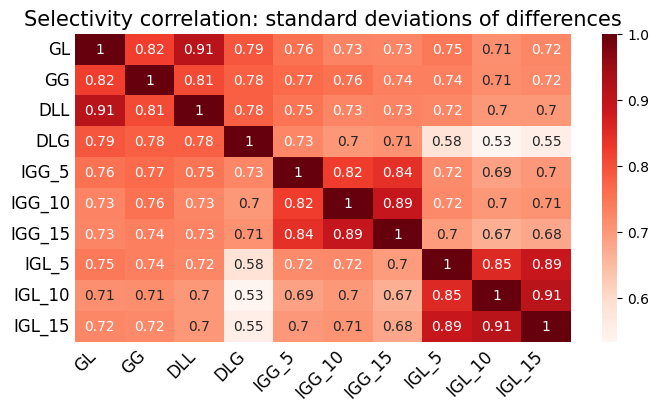

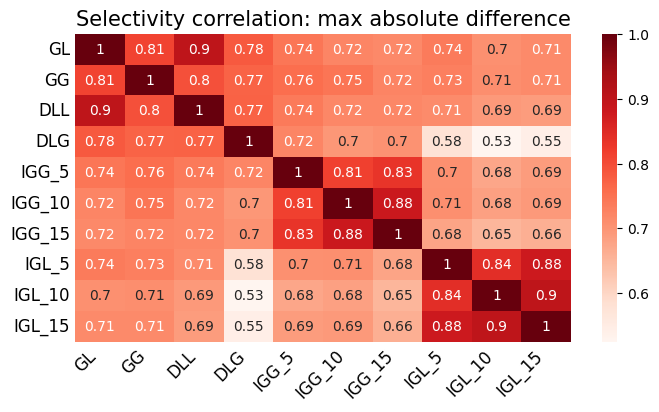

In [208]:
for k, df in all_selectivity.items():
  create_heatmap(df.rename(columns=columns_mapping_short).corr("spearman"), annot=True, figsize=(8, 4),
                 filename=f"sel_corr_{k}", title=f"Selectivity correlation: {suffixes_mapping[k]['title_suffix']}", path=figures_path/"selectivity")

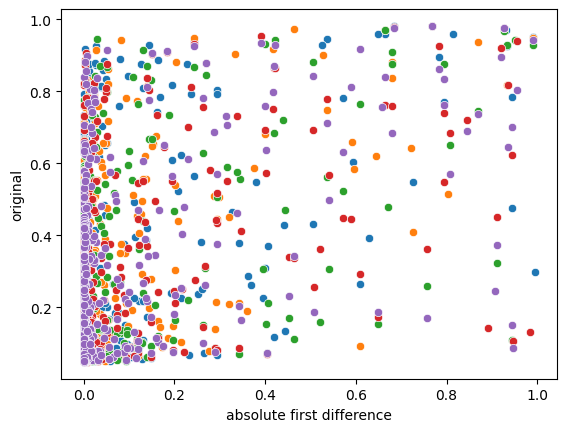

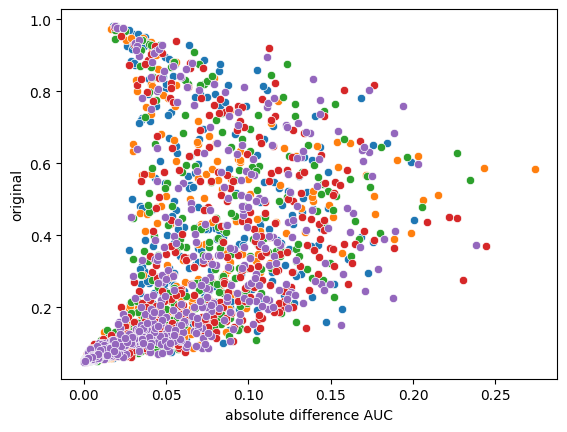

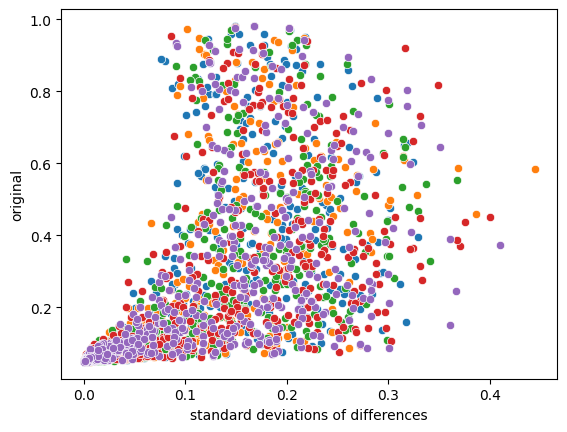

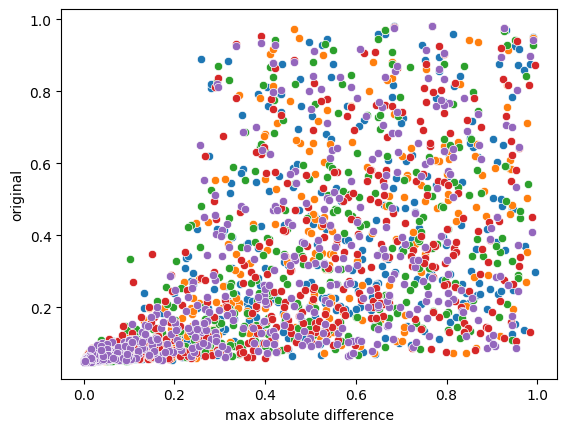

In [209]:
for k, _df in all_selectivity.items():
  if k == "original":
    continue
  fig, ax = plt.subplots()
  _df_og = all_selectivity["original"]
  m_global = pd.merge(_df_og[explainers_global], _df[explainers_global], left_index=True, right_index=True, suffixes=["_og", f"_{k}"])
  for explainer_name in explainers_global:
    y, x = [col for col in m_global.columns if col.startswith(explainer_name)]
    sns.scatterplot(ax=ax, data=m_global, x=x, y=y)
    ax.set_xlabel(suffixes_mapping[k]["title_suffix"])
    ax.set_ylabel("original")
  save_plot(path=figures_path / "selectivity", filename=f"og_vs_{k}", suffix="scatter", title=None)

### Stability

In [210]:
st_path = figures_path / "stability"

#### Utils

#### Continuity

In [211]:
rb_by_explainer_n_by_text_id[1]["DeepLiftGlobal"][20000][0].perturbation_info

{'name': 'random_token_baseline_replacement',
 'lvl': '0',
 'n_tokens_to_replace': '1',
 'attr_kwargs': {}}

##### Utils

In [212]:
# get the change in the prediction function as well

In [213]:
def apply_func_all_rb(rb_by_explainer_by_text_id, all_default_mapping, explainers_to_use, aggr_func, use_original=False, **aggr_func_kwargs):
  res = {k: defaultdict(dict) for k in rb_by_explainer_by_text_id.keys()}
  for k, v in rb_by_explainer_by_text_id.items():
    for explainer_name, exps_by_text_id in v.items():
      if explainer_name not in explainers_to_use:
        continue
      for text_id, exps in exps_by_text_id.items():
        exps = exps if not use_original else [all_default_mapping[text_id][explainer_name]] + exps
        res[k][explainer_name][text_id] = aggr_func(exps, **aggr_func_kwargs)
  return res

##### Calculation

In [214]:
comb_rb_reversed = reverse_order_nested_dict(combinations_rb_mappings)

In [215]:
explainers_meta = ['GL__GG', 'DLL__DLG', 'IGL_5__IGG_5', 'IGL_10__IGG_10', 'IGL_15__IGG_15']

In [216]:
results_cont_custom = apply_func_all_rb(
    random_custom_n_by_text_id,
    custom_attr_mapping,
    aggr_func=cont_wrapper,
    explainers_to_use=["RandomUniform", "Constant"],
    use_original=True
)

In [217]:
results_cont_meta = {metric_name: apply_func_all_rb(
    comb_rb_reversed[metric_name],
    combination_mappings[metric_name],
    aggr_func=cont_wrapper,
    explainers_to_use=explainers_meta,
    use_original=True
) for metric_name in comb_rb_reversed.keys()}

In [218]:
results_cont = apply_func_all_rb(
    rb_by_explainer_n_by_text_id,
    all_default_mapping,
    aggr_func=cont_wrapper,
    explainers_to_use=list(all_default.keys()),
    use_original=True
)

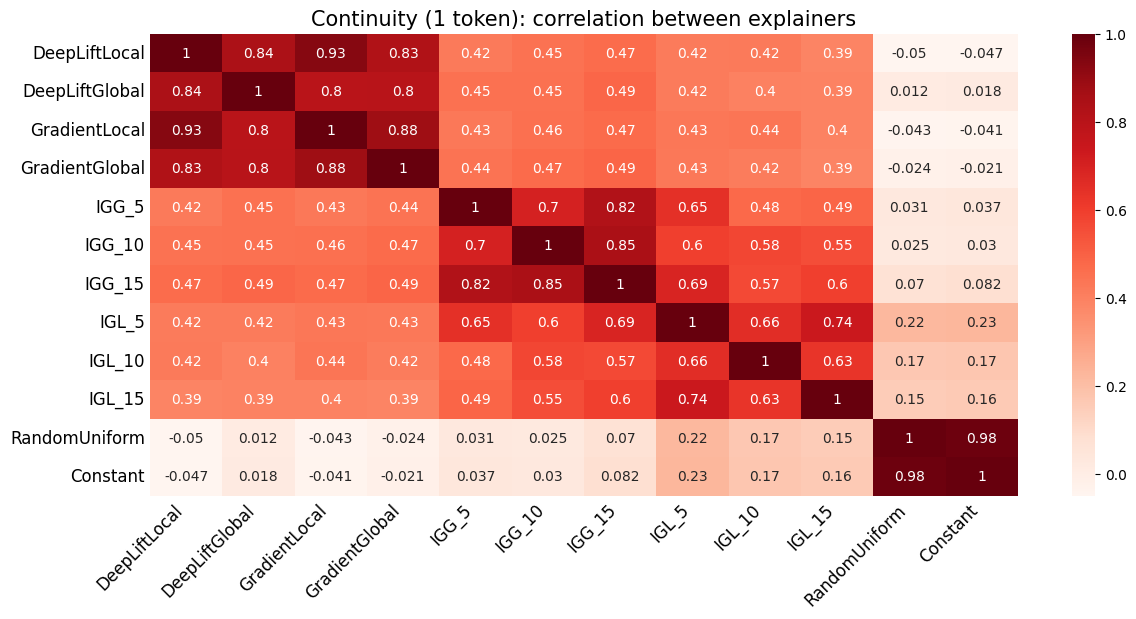

In [219]:
a = results_cont[1]
c = results_cont_custom[1]
cont_per_explainer1 = pd.merge(pd.DataFrame(a), pd.DataFrame(c), left_index=True, right_index=True).applymap(lambda x: x[0])
create_heatmap(cont_per_explainer1.corr("spearman"), annot=True, title="Continuity (1 token): correlation between explainers", filename="cont_1_corr", path=st_path)

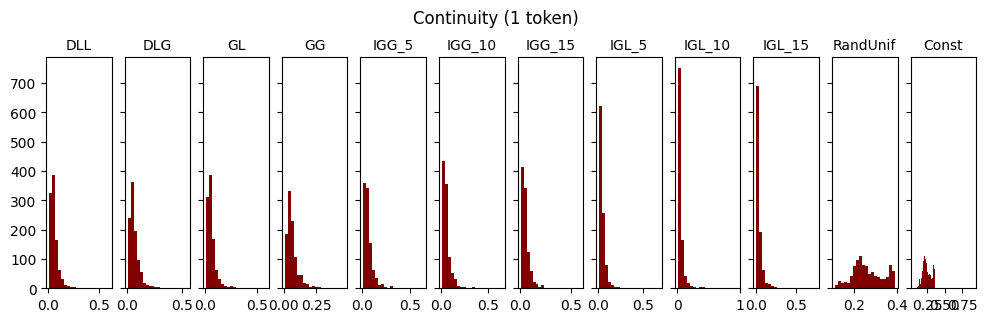

In [220]:
create_multiple_histograms_from_df(cont_per_explainer1.rename(columns=columns_mapping_short).rename(columns=custom_mapping_short),
                                   nrows=1, ncols=len(cont_per_explainer1.columns), figsize=(18, 5), add_mean=False,
                                   title="Continuity (1 token)", filename="cont_1", path=st_path, title_y=1.04, bins=20
                                   )

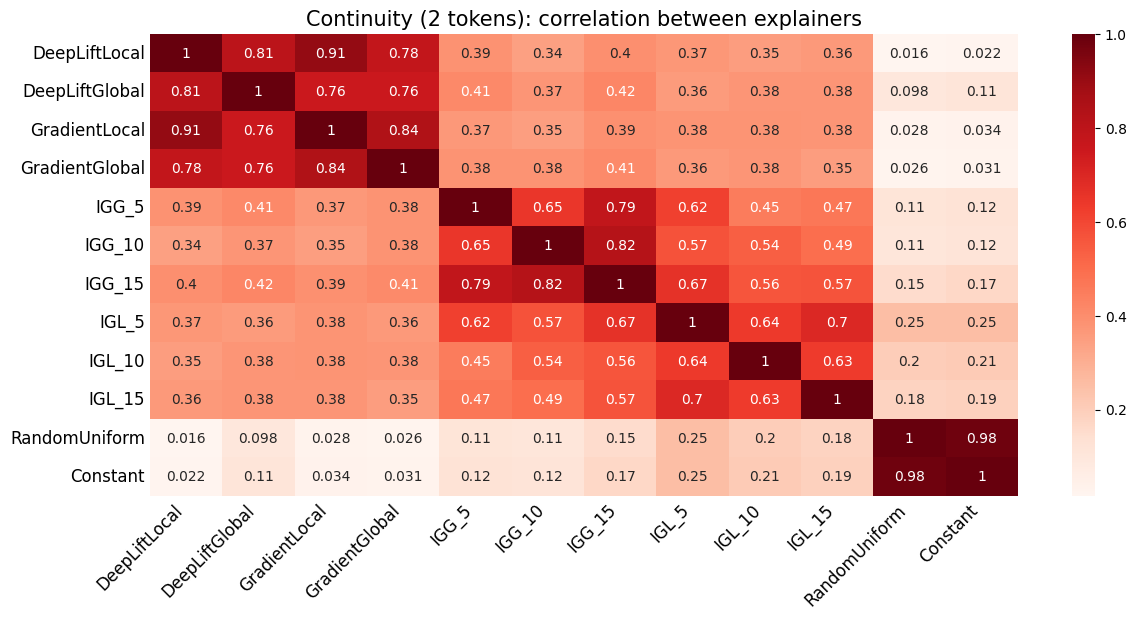

In [221]:
b = results_cont[2]
d = results_cont_custom[2]
cont_per_explainer2 = pd.merge(pd.DataFrame(b), pd.DataFrame(d), left_index=True, right_index=True).applymap(lambda x: x[0])
create_heatmap(cont_per_explainer2.corr("spearman"), annot=True, title="Continuity (2 tokens): correlation between explainers", filename="cont_2_corr", path=st_path)

In [222]:
res = {}
for k in a.keys():
  df = pd.merge(
      pd.DataFrame(a[k]).T.rename(columns={0: "cont1", 1: "output_abs_diff1"}),
      pd.DataFrame(b[k]).T.rename(columns={0: "cont2", 1: "output_abs_diff2"}),
      left_index=True, right_index=True
  )
  res[k] = df.corr("spearman").loc["cont1", "cont2"]

In [223]:
pd.Series(res).rename("Continuity: correlation 1 and 2 tokens").to_frame().T

DeepLiftLocal  DeepLiftGlobal  \
Continuity: correlation 1 and 2 tokens          0.662           0.626   

                                        GradientLocal  GradientGlobal  IGG_5  \
Continuity: correlation 1 and 2 tokens          0.655           0.675  0.608   

                                        IGG_10  IGG_15  IGL_5  IGL_10  IGL_15  
Continuity: correlation 1 and 2 tokens   0.634   0.625  0.710   0.734   0.728

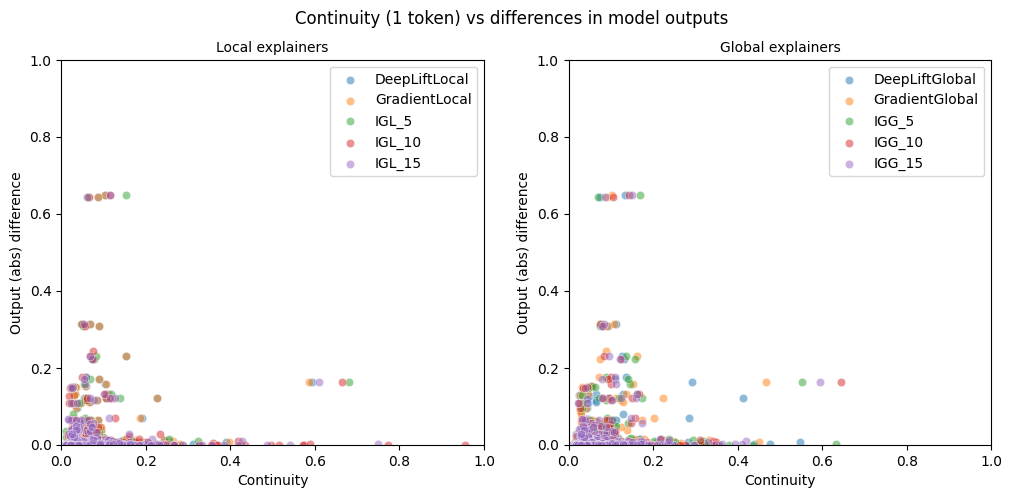

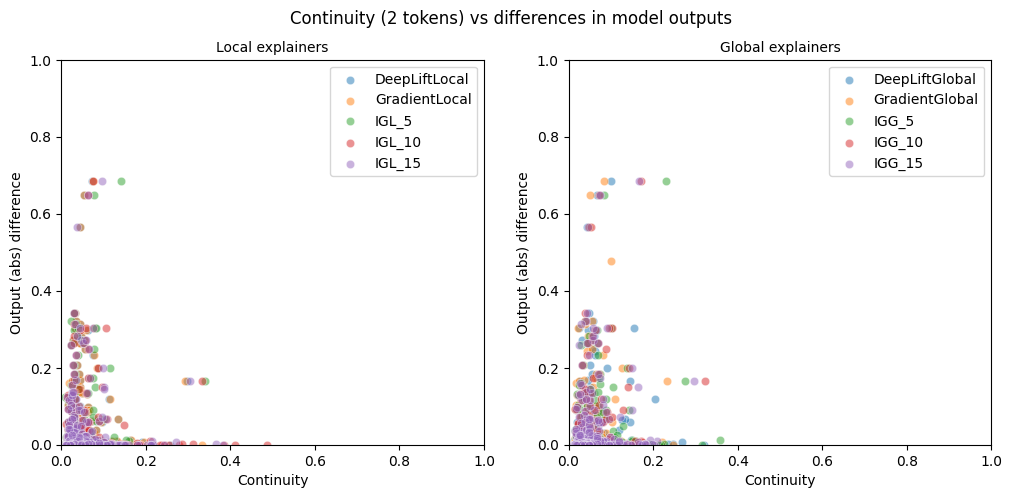

In [224]:
for i, item in enumerate([a, b]):
  fig, axes = plt.subplots(1, 2, figsize=(12, 5))
  for k in a.keys():
    df = pd.DataFrame(item[k]).T.rename(columns={0: "Continuity", 1: "Output (abs) difference"})
    kwargs = dict(data=df, x="Continuity", y="Output (abs) difference", alpha=0.5, label=k)
    j = 0 if k in explainers_local else 1
    sns.scatterplot(ax=axes[j], **kwargs)
  axes[0].set_xlim(0, 1)
  axes[1].set_xlim(0, 1)
  axes[0].set_ylim(0, 1)
  axes[1].set_ylim(0, 1)
  axes[0].set_title("Local explainers")
  axes[1].set_title("Global explainers")
  t = "(1 token)" if i==0 else f"(2 tokens)"
  fig.suptitle(f'Continuity {t} vs differences in model outputs')
  save_plot(path=st_path, filename=f"cont_{i+1}_vs_output_diff", suffix="scatter", title=None)

##### Meta-explainers

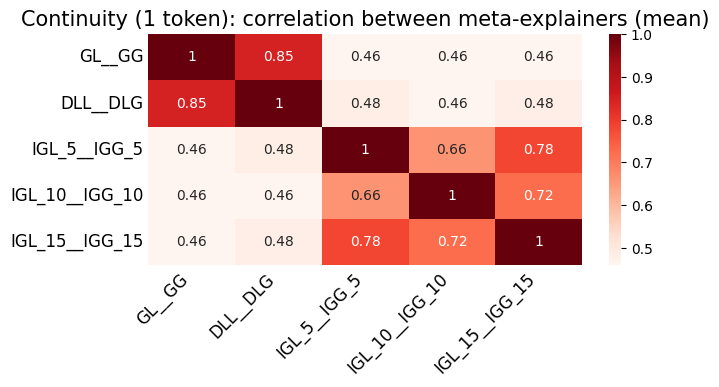

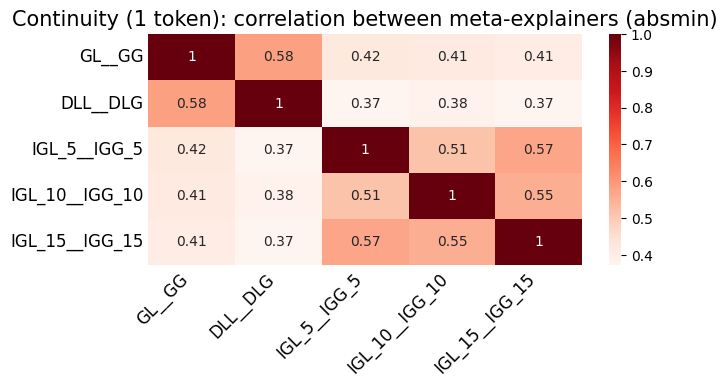

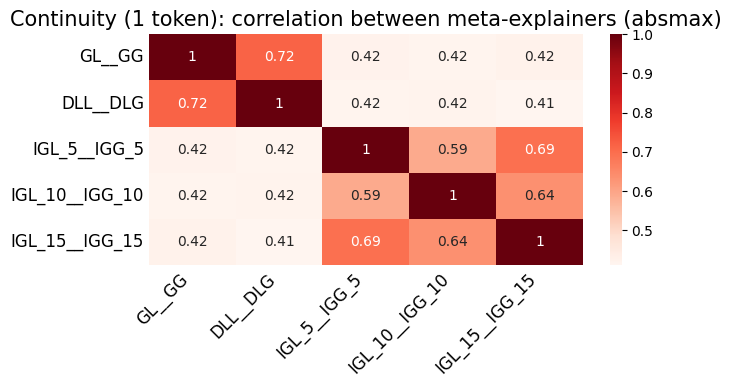

In [225]:
cont_per_meta_explainer1 = {metric_name: pd.DataFrame(results_cont_meta[metric_name][1]).applymap(lambda x: x[0]) for metric_name in ["mean", "absmin", "absmax"]}
for metric_name, df in cont_per_meta_explainer1.items():
  create_heatmap(
      df.corr("spearman"), annot=True, title=f"Continuity (1 token): correlation between meta-explainers ({metric_name})", filename=f"cont_1_corr_meta_{metric_name}", path=st_path)

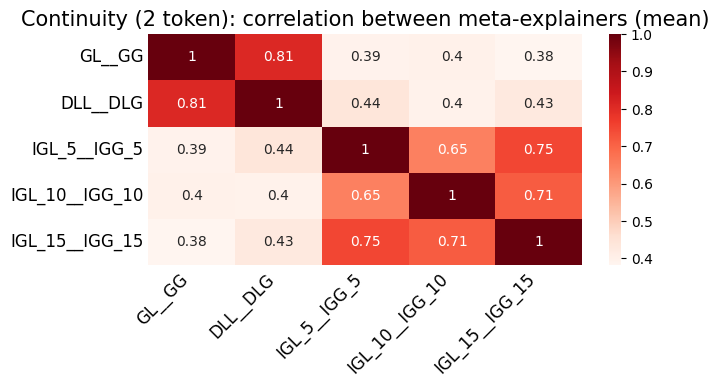

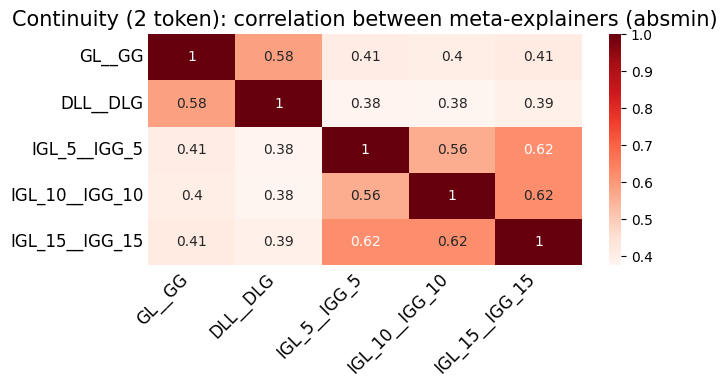

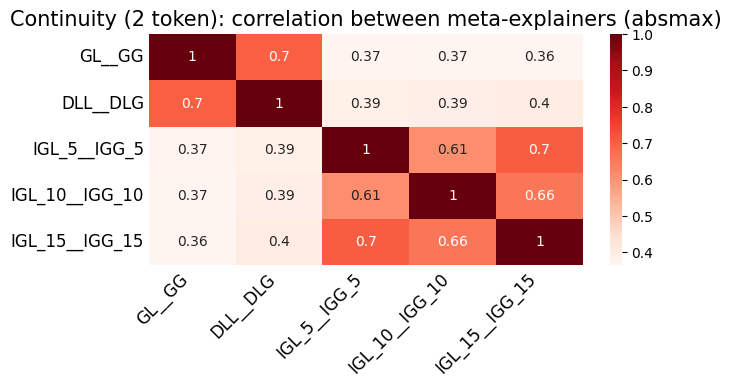

In [226]:
cont_per_meta_explainer2 = {metric_name: pd.DataFrame(results_cont_meta[metric_name][2]).applymap(lambda x: x[0]) for metric_name in ["mean", "absmin", "absmax"]}
for metric_name, df in cont_per_meta_explainer2.items():
  create_heatmap(
      df.corr("spearman"), annot=True, title=f"Continuity (2 token): correlation between meta-explainers ({metric_name})", filename=f"cont_2_corr_meta_{metric_name}", path=st_path)

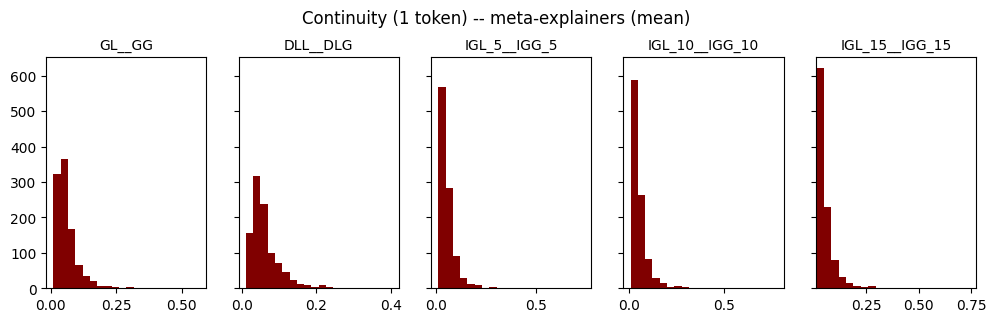

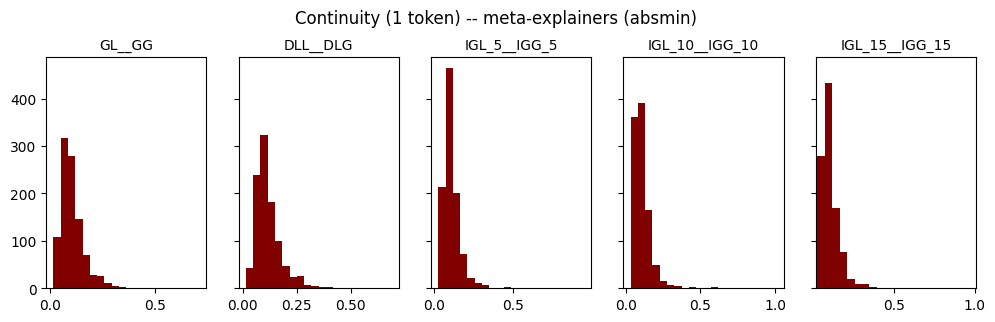

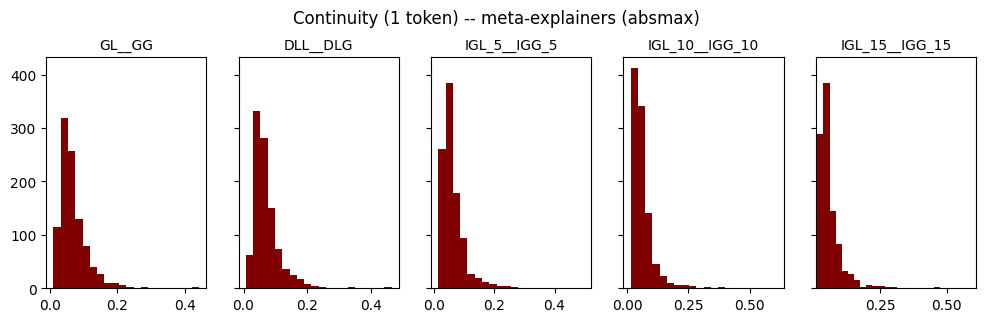

In [227]:
for metric_name in ["mean", "absmin", "absmax"]:
  df = cont_per_meta_explainer1[metric_name]
  create_multiple_histograms_from_df(df.rename(columns=columns_mapping_short),
                                   nrows=1, ncols=len(df.columns), figsize=(15, 5), add_mean=False,
                                   title=f"Continuity (1 token) -- meta-explainers ({metric_name})", filename=f"cont_1_meta_{metric_name}", path=st_path, title_y=1.04, bins=20
                                   )

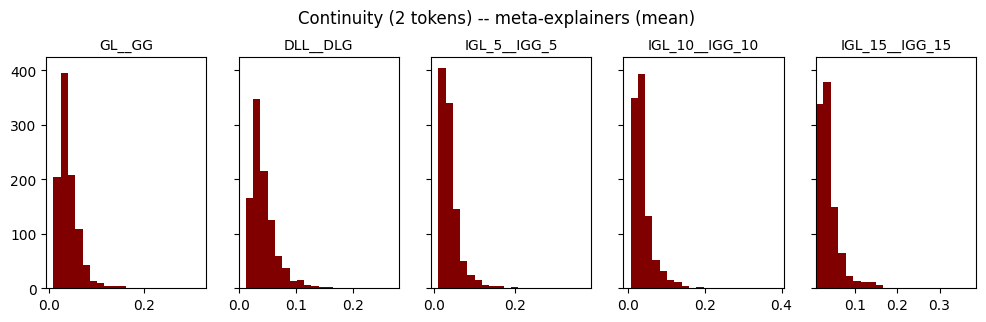

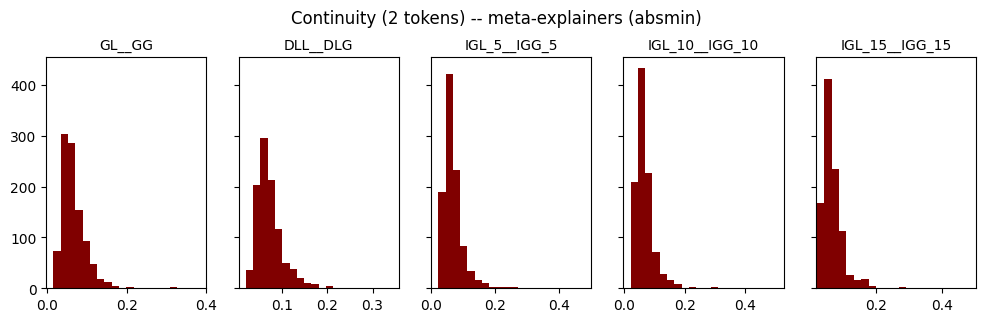

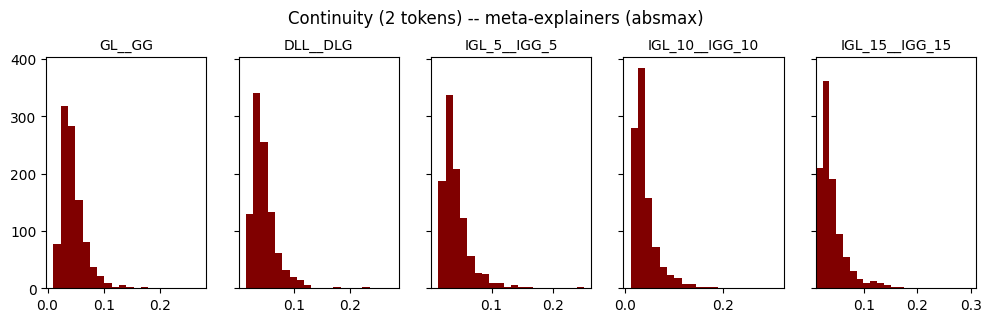

In [228]:
for metric_name in ["mean", "absmin", "absmax"]:
  df = cont_per_meta_explainer2[metric_name]
  create_multiple_histograms_from_df(df.rename(columns=columns_mapping_short),
                                   nrows=1, ncols=len(df.columns), figsize=(15, 5), add_mean=False,
                                   title=f"Continuity (2 tokens) -- meta-explainers ({metric_name})", filename=f"cont_2_meta_{metric_name}", path=st_path, title_y=1.04, bins=20
                                   )